<a href="https://colab.research.google.com/github/pushkar633/Cricket_Predictor/blob/master/Deloitte-SAC%20NLP%20Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Covid Tweets Analysis

### Pre-process

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import zipfile
!pip install us
import us
import re
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import spacy
from IPython.core.display import display, HTML
from IPython.display import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD
from collections import Counter

In [ ]:
zf = zipfile.ZipFile('/content/drive/My Drive/Deloitte/covid-extract_cleaned_tweets_10_24_LOCATION_LEMM.zip') 
df = pd.read_csv(zf.open('covid-extract_cleaned_tweets_10_24_LOCATION_LEMM.csv'))

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df['Processed_Tweet'][0]

'bet tyrannical dem governor end covid stay home order citizen require wear “ …'

In [ ]:
def check_re(S):
    return bool(re.search('\d', str(S)))

In [ ]:
df['flag']=df['Location'].apply(check_re)

In [ ]:
df_new=df[df['flag']==False]

In [ ]:
df_new=df_new[df_new['ID']!='ID']

In [ ]:
df_re=df_new[(df_new.Location != 'fm') & (df_new.Location != 'pw') & (df_new.Location != 'palau') & (df_new.Location != 'mh')]

In [ ]:
df_re['State']=df_re['Location'].apply(lambda x: us.states.lookup(x).name)

In [ ]:
df_tweet=df_re[['ID','State','Processed_Tweet']]

In [ ]:
def pre_pipe(doc_tweets):
    tweet_lemm = ' '.join(token.lemma_ for token in doc_tweets if not (token.is_stop or token.lemma_ == '-PRON-'))
    t_pos = ','.join(token.pos_ for token in doc_tweets if not (token.is_stop or token.lemma_ == '-PRON-'))
    return tweet_lemm, t_pos

def processing_pipe(raw_tweets):
    covid_tweets=[]
    pos=[]
    t_num = 1
    # it's performant to use 'nlp.pipe' since it allows for multi-threaded batch processing of individual tweets or 'docs'
    for doc in nlp.pipe(raw_tweets, batch_size=7500, disable=["parser"]): # batch_size dependent on system CPU/RAM
        covid_tweets.append(pre_pipe(doc)[0])
        pos.append(pre_pipe(doc)[1])
        t_num += 1
        print(f'Appending Tweet: #{t_num} / {total_tweets}')
    return covid_tweets, pos


In [ ]:
nlp = spacy.load('en_core_web_sm')

total_tweets = len(df_tweet.index) # pulling total # of tweets
t_clean = processing_pipe(df_tweet['Processed_Tweet'])

df_tweet['Processed_Tweet'] = pd.Series(t_clean[0][:])

In [ ]:
# Final dataset with states and cleaned tweets
df_tweet.head(25)

ID  ...                                    Processed_Tweet
0    7.968997458894029e+17  ...  bet tyrannical dem governor end covid stay hom...
1             1143848268.0  ...  accord ons , 40,000 uk die coronavirus . doubl...
2     9.55538060434989e+17  ...  try .. editorial leftist editorial board convi...
3               37076194.0  ...  careful . crazy nancy total disaster , usa com...
4              274263703.0  ...  fuck mitch , putin puppet !   make donation   ...
5    7.645380899266888e+17  ...  nuclear level piss - bs!dying wwii veteran den...
6    9.268464173139026e+17  ...  joe biden choose defend china day credibly acc...
7   1.0804107810559672e+18  ...  hear lot minister protect vulnerablethat inclu...
8    9.980938357701263e+17  ...  health kit supply # covid19 + have pt & amp ; ...
9              216400920.0  ...  think . desciphering excess death covid . case...
10             145362719.0  ...  u expect charge professional fee ! u people 10...
11              47307465.0  ...                 new video series !   human right .
12             261234333.0  ...  strongly condemn kind prejudice & amp ; appeal...
13            2241412758.0  ...  son admit child hospital . corona virus . good...
14             435380429.0  ...                         corona shit live well life
15             957068550.0  ...  guy 😭 😷 social distance / quarantine period , ...
16   1.216372566962557e+18  ...  # howtoend_coronapandemiconly saint rampal ji ...
17   1.242052284781146e+18  ...  point come messiah , pleague locust , outbreak...
18              18636235.0  ...  want stop spread corona , break cycle infectio...
19             341489584.0  ...  bore bore guy ! get job definitely worth ! bat...
20  1.2125627336960492e+18  ...           mum phd corona virus whatsapp university
21            3399247427.0  ...                     think mum whatsapp groupchat .
22  1.0949605537124064e+18  ...                                  : try corona time
23  1.2033087031658906e+18  ...  cate people employ , u decide home early.the w...
24            3915580214.0  ...  cdc announce corona spread instagram story cha...

[25 rows x 3 columns]

### Basic Visualization

Overall

In [ ]:
number=df_tweet.groupby(['State']).agg(np.size)['ID'].to_frame()
number=number.reset_index()
number.columns=['state','num']
number=number.sort_values('num').reset_index(drop=True)

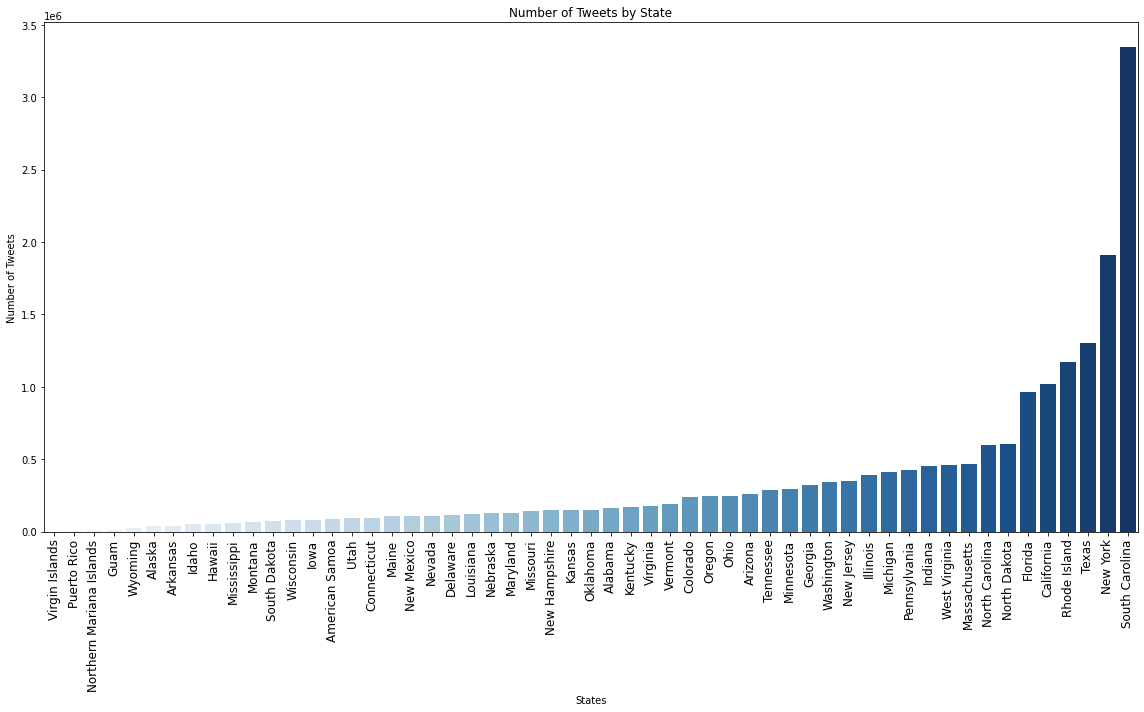

In [ ]:
plt.figure(figsize=(16,10))
ax = sns.barplot(x="state", y="num", data=number, palette='Blues')
ax.set_xticklabels(ax.get_xticklabels(),fontsize=12,rotation=90)
plt.ylabel("Number of Tweets")
plt.xlabel("States")
plt.title("Number of Tweets by State")
plt.tight_layout()
plt.savefig('Number_State.png')
plt.show()

Mask

In [ ]:
mask_p=df_tweet.groupby('State').apply(lambda g: g[g['Processed_Tweet'].str.contains('mask')]['ID'].count()/g['ID'].count()).to_frame()
mask_p=mask_p.reset_index()
mask_p.columns=['state','proportion']
mask_p['proportion']=mask_p['proportion']*100
mask_p=mask_p.sort_values('proportion').reset_index(drop=True)

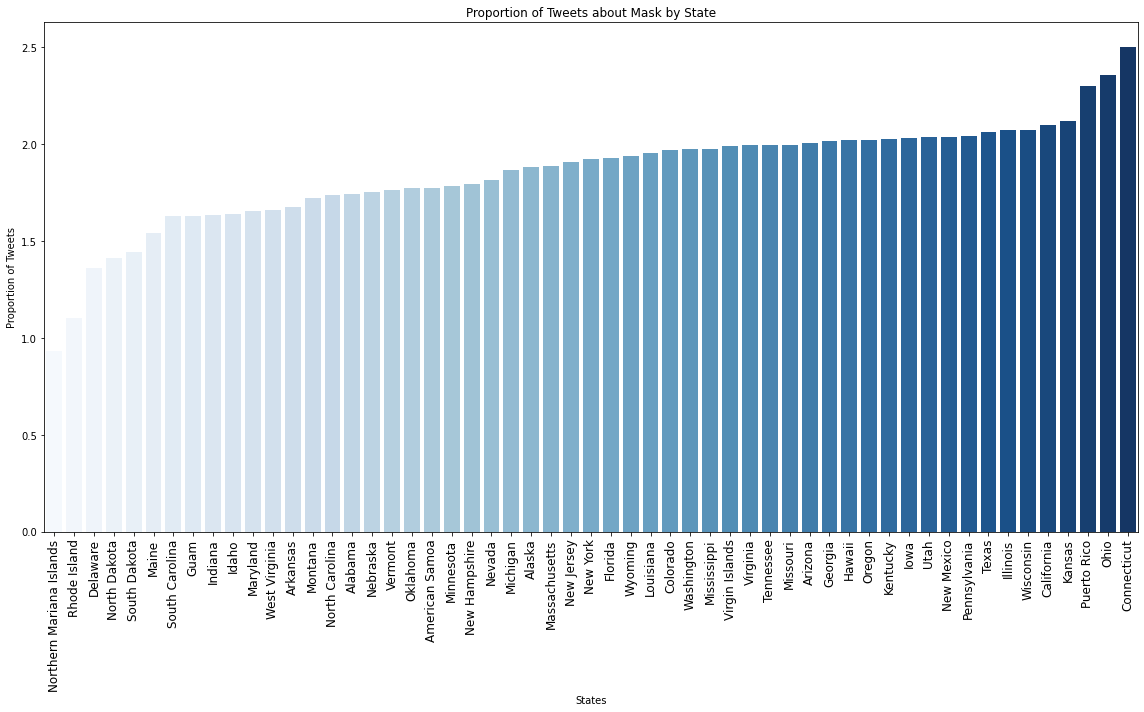

In [ ]:
plt.figure(figsize=(16,10))
ax = sns.barplot(x="state", y="proportion", data=mask_p, palette='Blues')
ax.set_xticklabels(ax.get_xticklabels(),fontsize=12,rotation=90)
plt.ylabel("Proportion of Tweets")
plt.xlabel("States")
plt.title("Proportion of Tweets about Mask by State")
plt.tight_layout()
plt.savefig('Mask_Pro_State.png')
plt.show()

Social Distance

In [ ]:
distance_p=df_tweet.groupby('State').apply(lambda g: g[g['Processed_Tweet'].str.contains('social distance')]['ID'].count()/g['ID'].count()).to_frame()
distance_p=distance_p.reset_index()
distance_p.columns=['state','proportion']
distance_p['proportion']=distance_p['proportion']*100
distance_p=distance_p.sort_values('proportion').reset_index(drop=True)

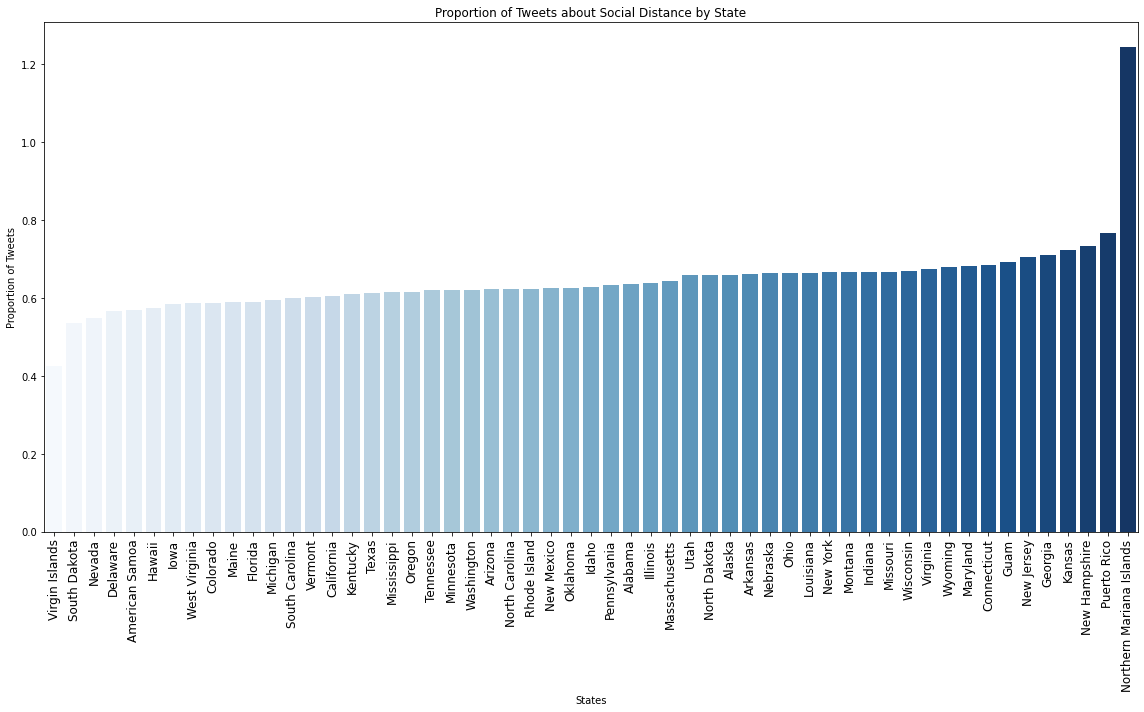

In [ ]:
plt.figure(figsize=(16,10))
ax = sns.barplot(x="state", y="proportion", data=distance_p, palette='Blues')
ax.set_xticklabels(ax.get_xticklabels(),fontsize=12,rotation=90)
plt.ylabel("Proportion of Tweets")
plt.xlabel("States")
plt.title("Proportion of Tweets about Social Distance by State")
plt.tight_layout()
plt.savefig('Distance_Pro_State.png')
plt.show()

Reopen

In [ ]:
reopen_p=df_tweet.groupby('State').apply(lambda g: g[g['Processed_Tweet'].str.contains('reopen')]['ID'].count()/g['ID'].count()).to_frame()
reopen_p=reopen_p.reset_index()
reopen_p.columns=['state','proportion']
reopen_p['proportion']=reopen_p['proportion']*100
reopen_p=reopen_p.sort_values('proportion').reset_index(drop=True)

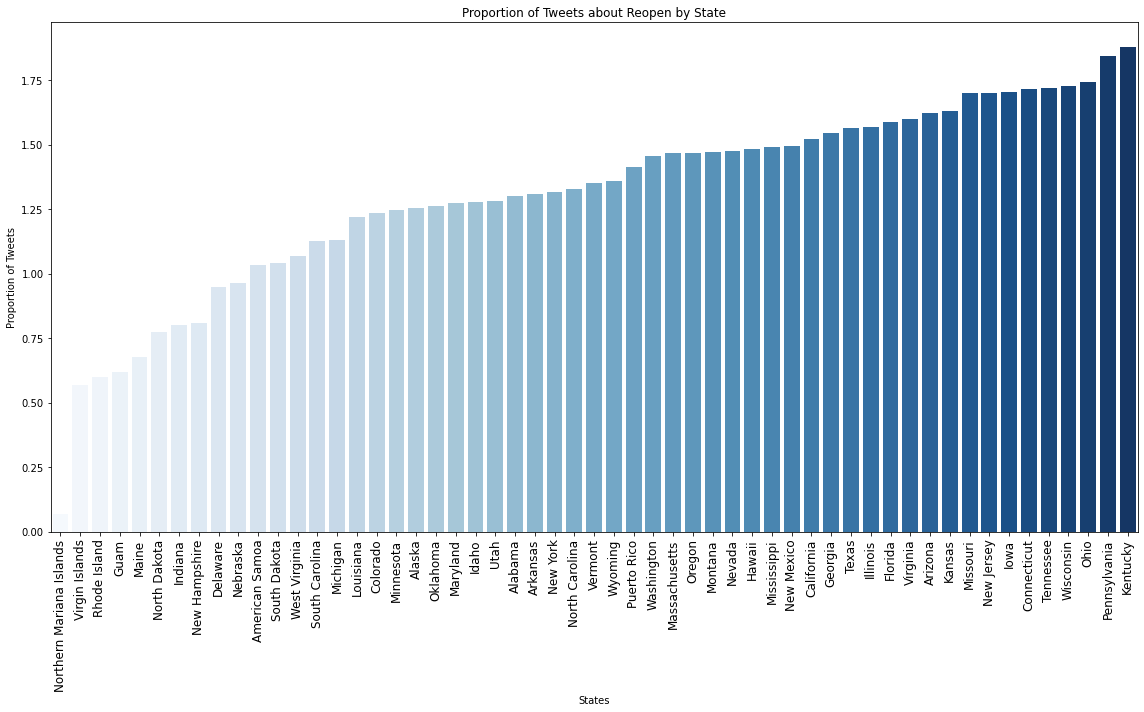

In [ ]:
plt.figure(figsize=(16,10))
ax = sns.barplot(x="state", y="proportion", data=reopen_p, palette='Blues')
ax.set_xticklabels(ax.get_xticklabels(),fontsize=12,rotation=90)
plt.ylabel("Proportion of Tweets")
plt.xlabel("States")
plt.title("Proportion of Tweets about Reopen by State")
plt.tight_layout()
plt.savefig('Reopen_Pro_State.png')
plt.show()

### WordCloud

In [ ]:
def show_wordcloud(df_state,title):
  print(title+":")
  ls_tweet = df_state['Processed_Tweet'].to_list()
  r_tweet = " ".join(ls_tweet)
  # Create a basic wordcloud
  print(f'Generating WordCloud across {len(r_tweet)} characters.')
  wordcloud = WordCloud(background_color="white", collocations=False, max_words=100).generate(r_tweet)
  # Display the generated image:
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.title(title)
  plt.savefig(title+'.png')
  plt.show()

In [ ]:
df_tweet.groupby('State').apply(
    lambda x: show_wordcloud(x,title=f"{x.name}")
)

### Word Count

In [ ]:
def count_word(data):
  all_words = []
  for line in data['Processed_Tweet']:
      words = line.split()
      for word in words:
        all_words.append(word.lower())

  word_count = Counter(all_words).most_common(1000) # can manipulate the total number of words counted (e.g. 10,000; 30,000, etc.)
  word_count_x = []
  word_count_y = []
  for word, count in word_count:
      word_count_x.append(word)
      word_count_y.append(count)

  print(word_count_x)
  plt.figure(figsize=(22,10))
  plt.plot(word_count_x[850:], word_count_y[850:], linestyle='-', linewidth=1) # play around with the values within x and y to slice the data differently
  plt.ylabel("Count")
  plt.xlabel("Word")
  plt.xticks(fontsize='small', rotation=90)
  plt.title('Plot of words frequency in corpus')
  plt.show()

Pulling out indivdual words.
Words extracted.
['want', 'point', 'anifa', 'innovation', 'covid-19', 'induce', '.', 'lot', 'brand', 'come', '…', ',', 'give', 'begin', ',', 'entire', 'yearly', 'salary', ',', '$', '400,000', '$', '450,000', ',', 'government']


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128165 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128165 missing from current font.
  font.set_text(s, 0, flags=flags)


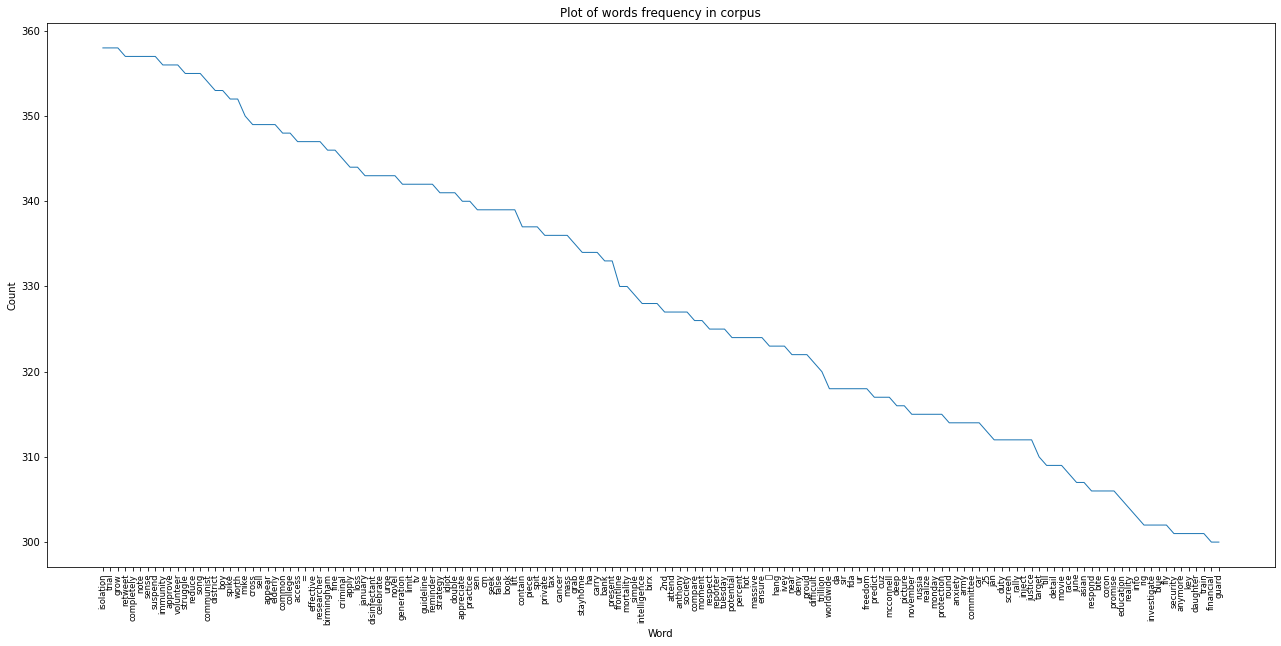

Pulling out indivdual words.
Words extracted.
['see', 'headline', '"', 'spike', 'case', 'wi', 'election"i', 'check', 'add', 'arrow', '14', 'day', 'l', '…', 'update', ':', '#', 'zambia', '#', 'covid-19', 'case', ',', 'stand', '252', ',']


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129440 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127466 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127996 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128077 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129318 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 129440 missing from current font.
  fon

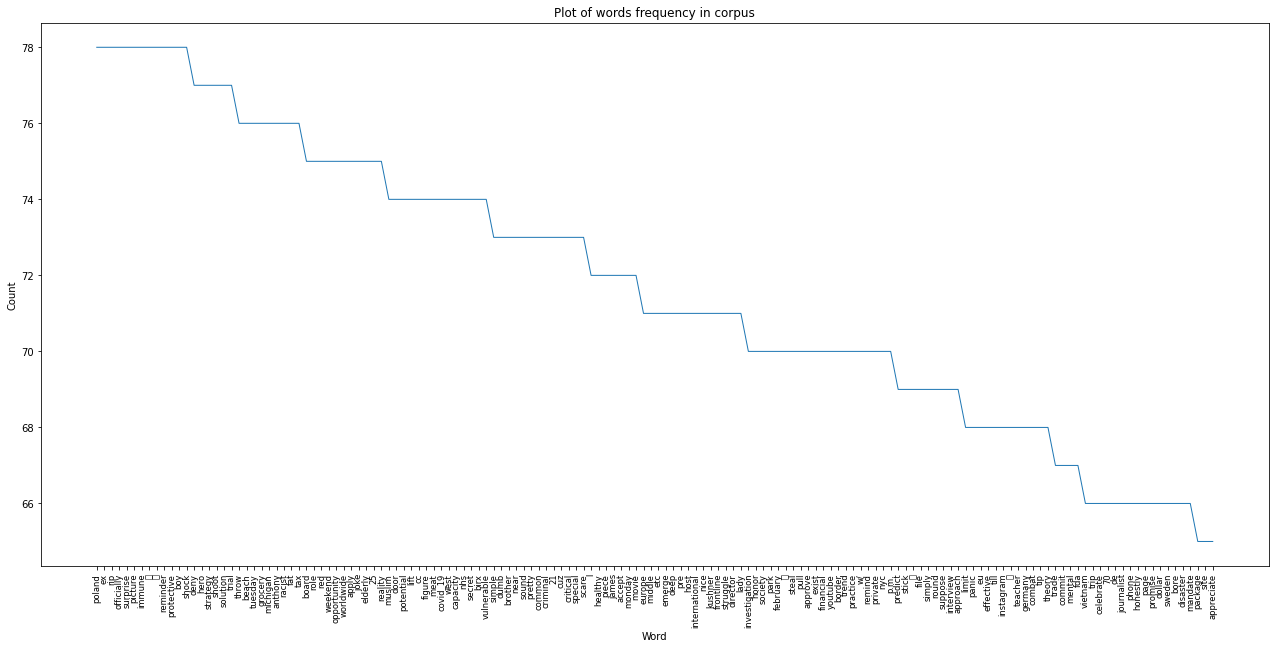

Pulling out indivdual words.
Words extracted.
['want', 'risk', 'get', 'corona', 'job', 'essential', 'keep', 'stock', 'thing', 'nee', '…', 'joe', ',', 'stay', 'basement#trump2020', '#', 'kag2020', '#', 'ccot', '#', 'tcot', '#', 'saturdaythoughts', '#', 'covid']


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128293 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128580 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128293 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128580 missing from current font.
  font.set_text(s, 0, flags=flags)


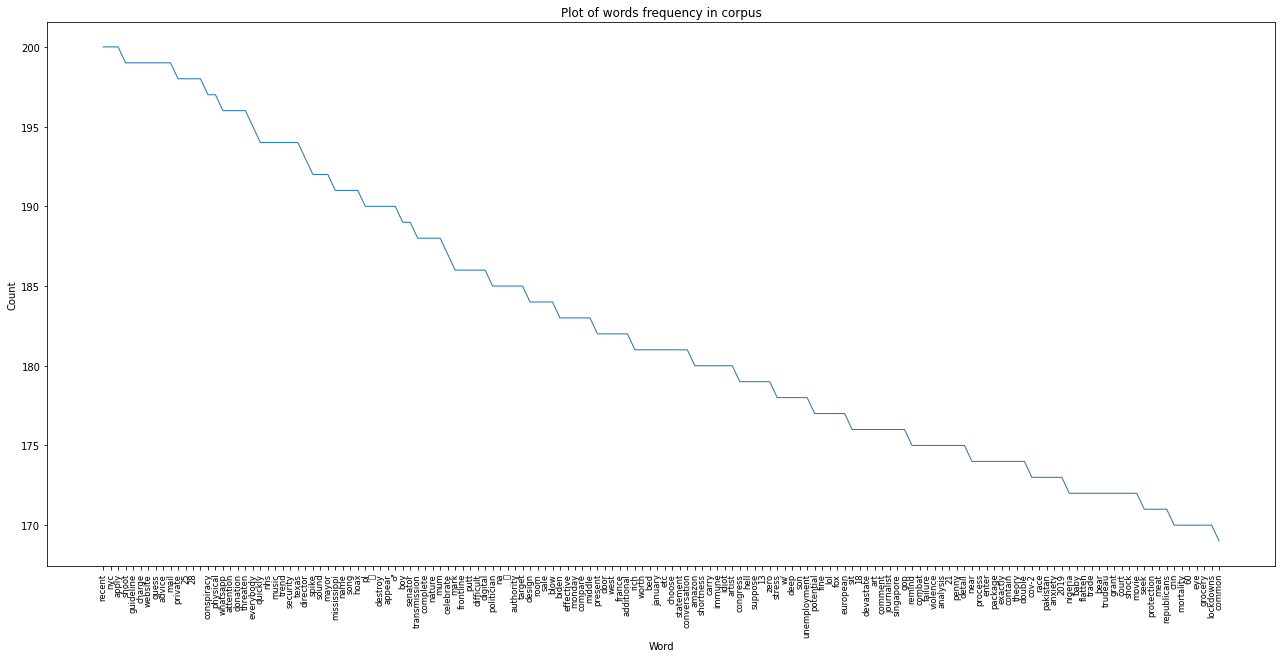

Pulling out indivdual words.
Words extracted.
['think', 'corona', 'virus', 'bad', ',', 'match', 'virus', '!', '!', '60', 'day', 'ago', '(', 'write', ')', 'cross', '500', 'death', '.', 'remember', 'republicans', 'think', 'state', 'run', 'election']


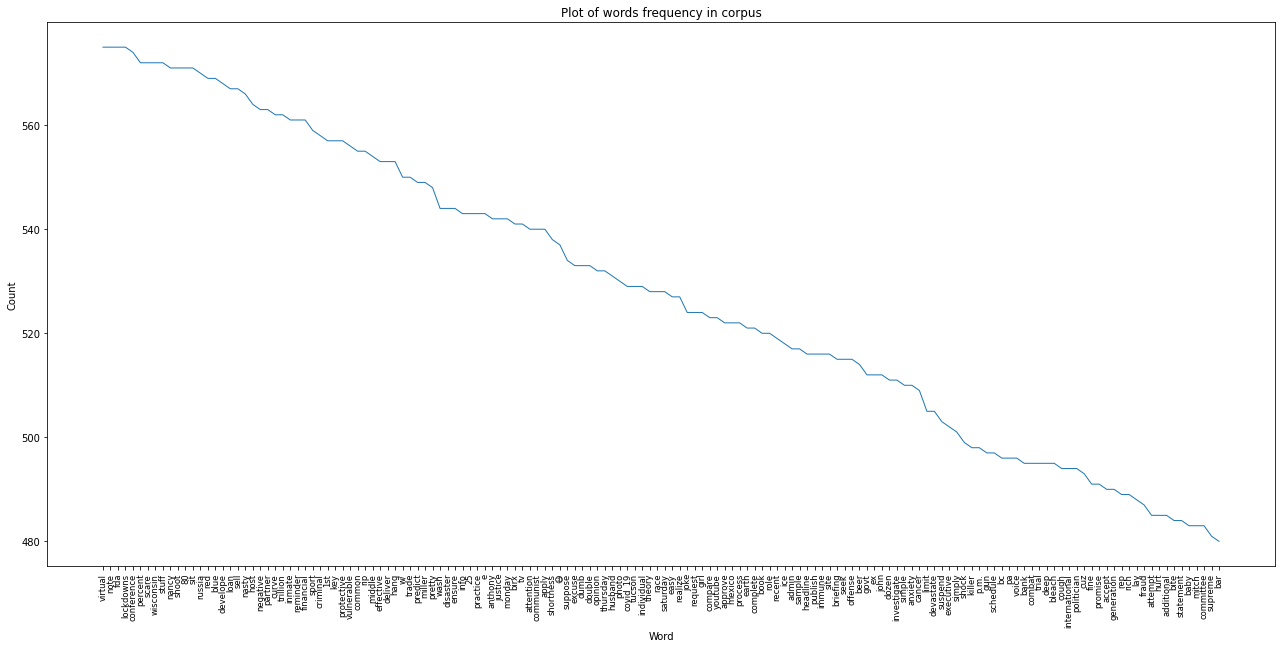

Pulling out indivdual words.
Words extracted.
['niggas', 'move', 'like', 'covid', 'real', 'thing', 'anymore', 'generation', 'z.', 'want', 'folk', 'love', 'call', 'everybody', '40', 'millennials.millennials', '…', 'identify', 'mei', 'steal', 'cowi', 'butcher', '&', 'amp', ';']


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128073 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128314 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128073 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128314 missing from current font.
  font.set_text(s, 0, flags=flags)


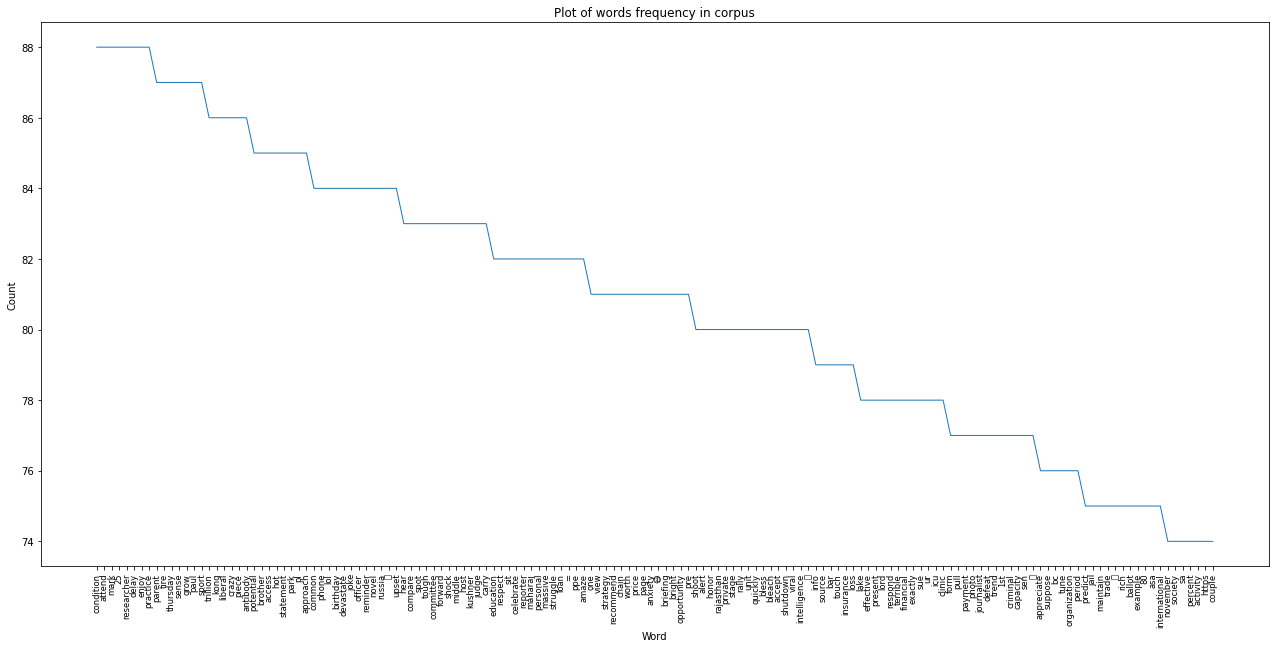

Pulling out indivdual words.
Words extracted.
['mfs', 'want', 'nba', 'come', '...', '3', 'day', 'weekend.it', 'nice', 'outside.that', 'mean', '#', 'covid19', 'go', 'away.wash', 'hands.stay', '6', 'foot', 'apart', '.', '…', 'covid19', 'middle', 'pandemic', ',']


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129402 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127995 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 129402 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127995 missing from current font.
  font.set_text(s, 0, flags=flags)


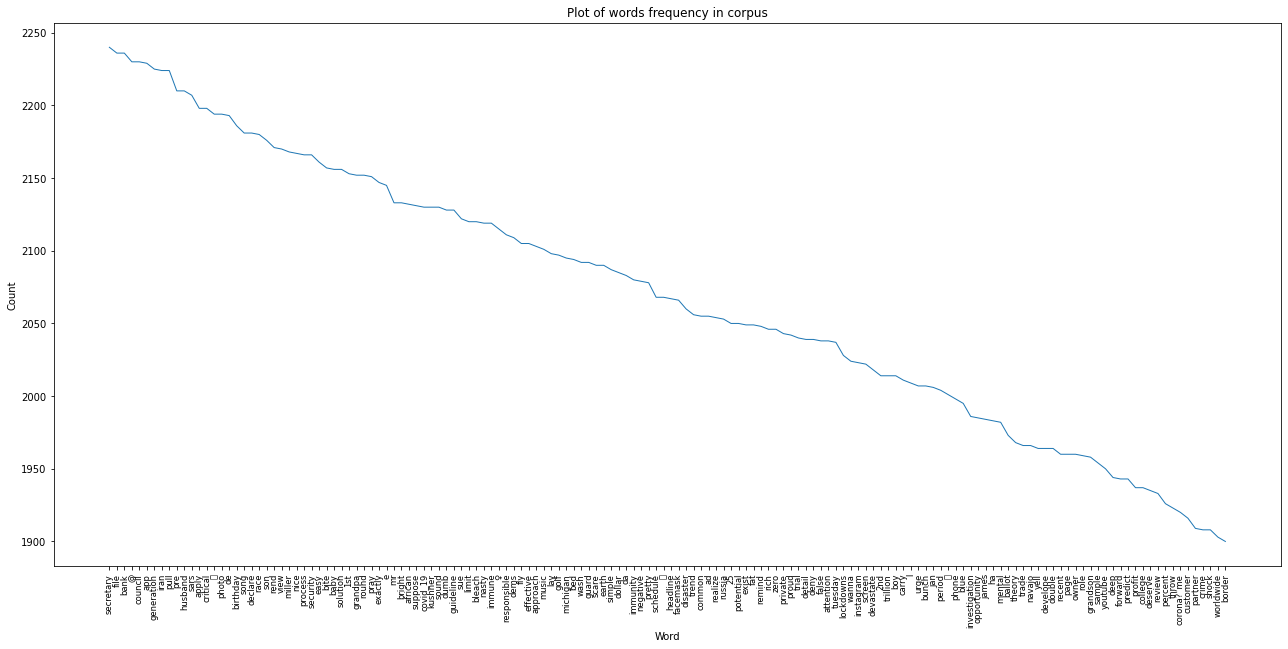

Pulling out indivdual words.
Words extracted.
['know', ':', 'people', 'die', 'result', 'new', 'york', '&', 'amp', ';', 'new', 'jersey', 'disastrous', 'nurse', 'home', 'policy', 'corona', '…', 'corona', 'virus', 'america', 'need', 'bite', 'hope', '...']


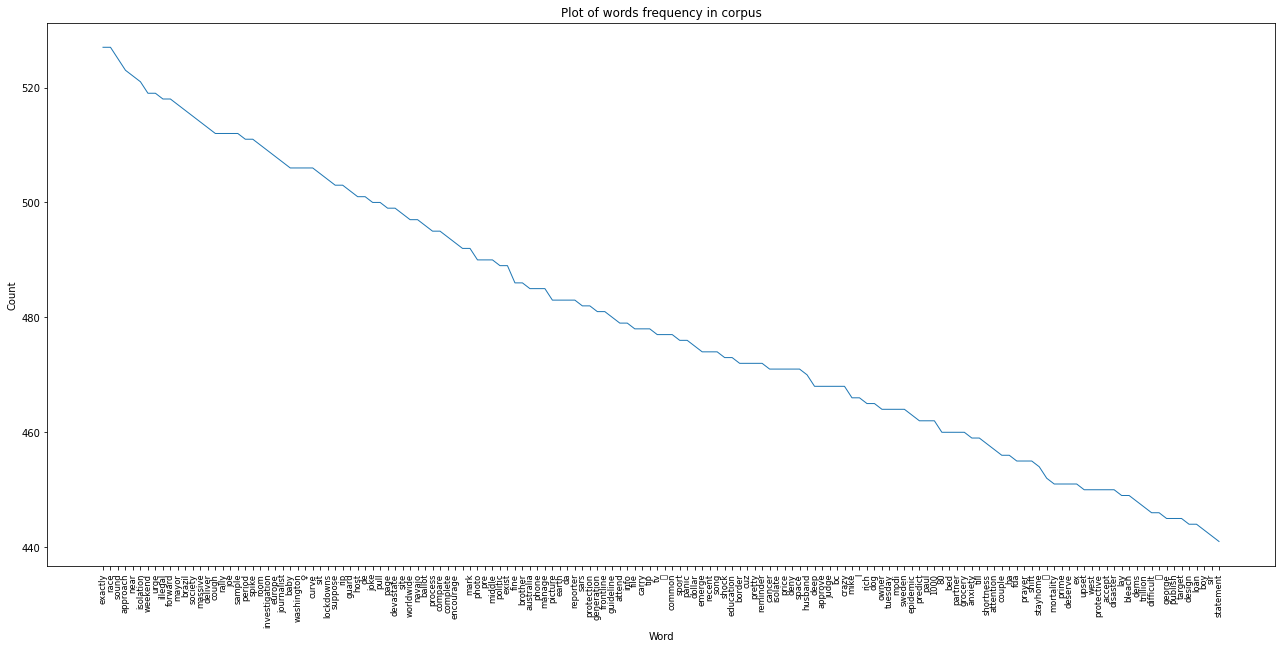

Pulling out indivdual words.
Words extracted.
['chromatica', 'report', 'single', 'case', 'covid-19', '.', 'true', 'leadership', 'look', 'like', '.', 'restaurant', 'corona', 'virus', 'system', 'weird', 'af', 'cousin', 'pull', 'life', 'support', 'tomorrow', '.', 'suffer', 'multiple']


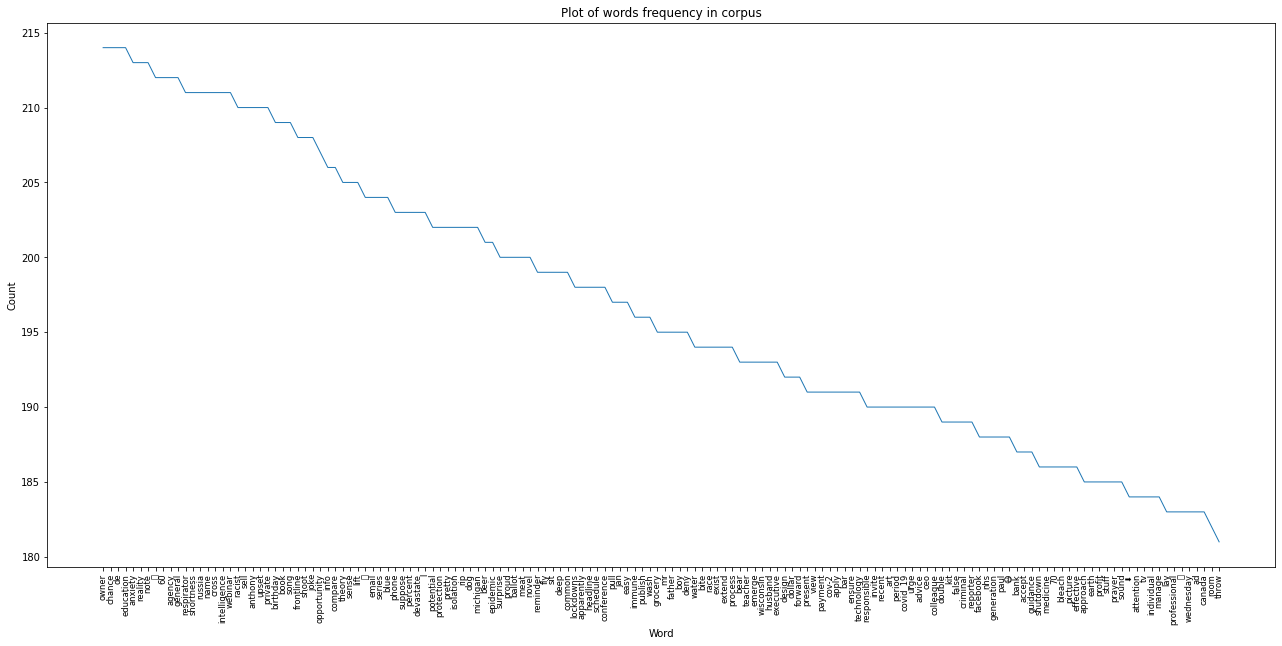

Pulling out indivdual words.
Words extracted.
['neath', 'port', 'talbot', 'cvs', '&', 'amp', ';', 'fareshare', 'cymru', 'support', 'food', 'bank', 'covid-19', '?', 'hhashhahaha', 'send', 'president', 'email', 'demand', 'corona', 'virus', 'bill', 'send', 'congress', 'demand']


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129300 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127480 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127482 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127463 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 129300 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127480 missing from current font.
  font.

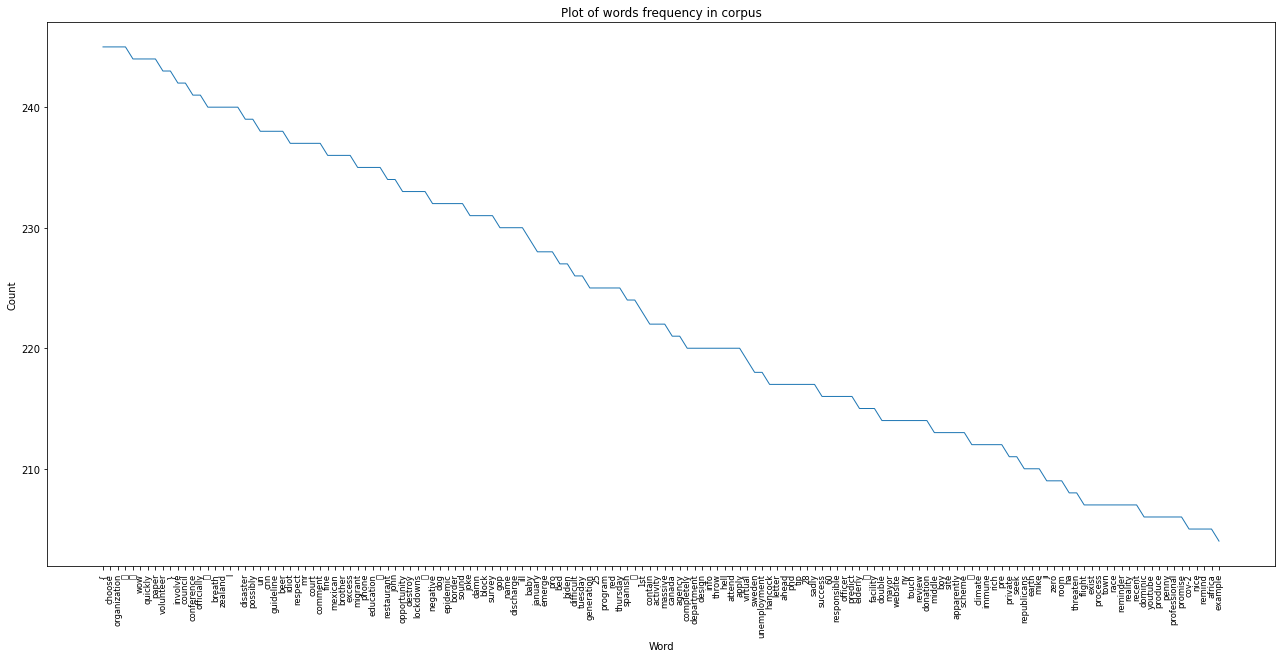

Pulling out indivdual words.
Words extracted.
['corona', 'shit', 'live', 'well', 'life', 'hop', 'border', 'come', 'san', 'francisco', 'free', 'shit', '?', 'okay', ',', 'right', '?', 'far', 'hospital', 'lack', 'basic', 'infrastructure', ',', 'brazil', 'indigenous']


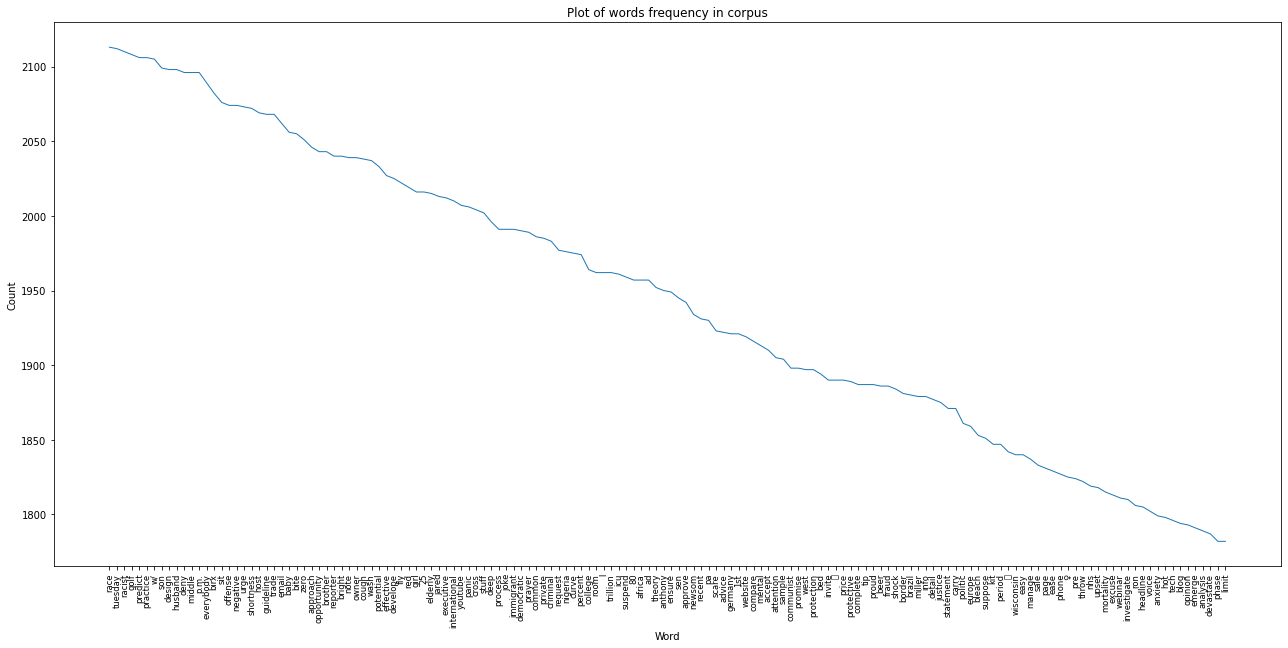

Pulling out indivdual words.
Words extracted.
['...', 'pretty', 'impressive', ',', '.', 'hope', 'conway', 'learn', 'solution', 'die', 'april', 'covid-19', '.', ',', '#', 'animalcrossing', 'officially', 'way', 'afford', 'pick', 'public', 'right', '.', 'sad', '.']


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127997 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129396 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129335 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127997 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 129396 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 129335 missing from current font.
  font.se

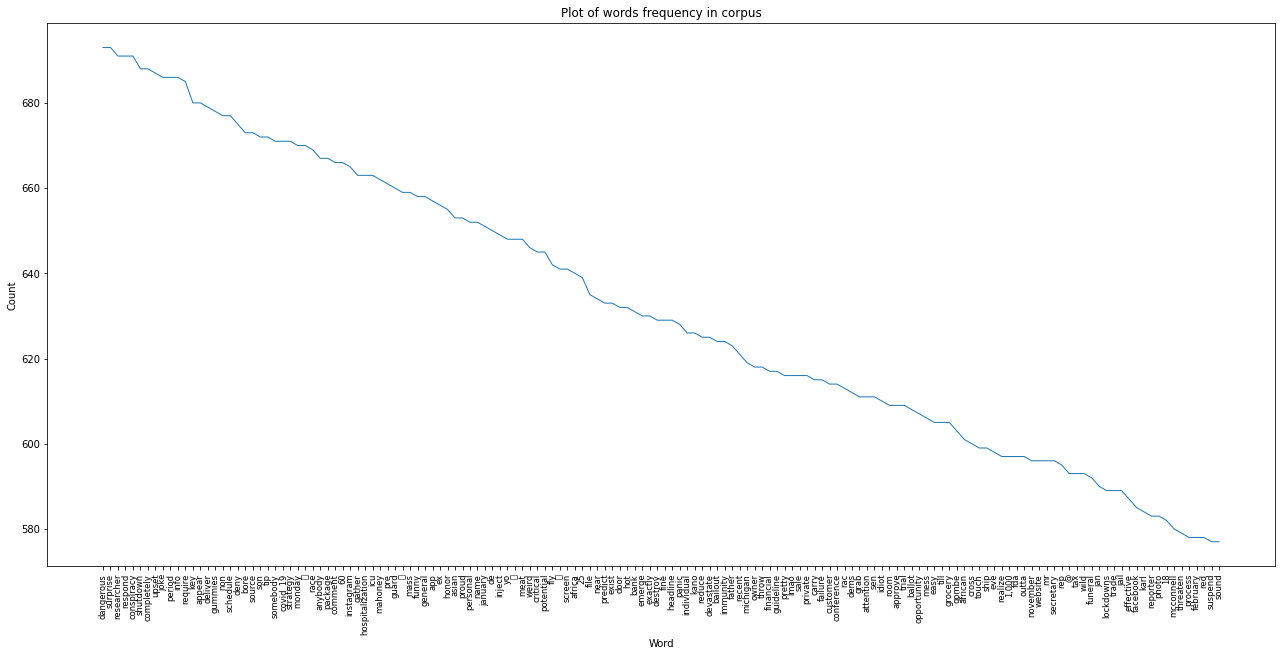

Pulling out indivdual words.
Words extracted.
['sad', 'news', 'come', '.', 'seven', 'people', 'test', 'positive', 'corona', 'virus', 'kashmir', '.', 'pope', 'francis', 'invite', 'people', 'faith', 'unite', 'today', 'prayer', ',', 'fast', 'work', 'charity', 'end']


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127465 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127479 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9989 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127465 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127479 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9989 missing from current font.
  font.set_te

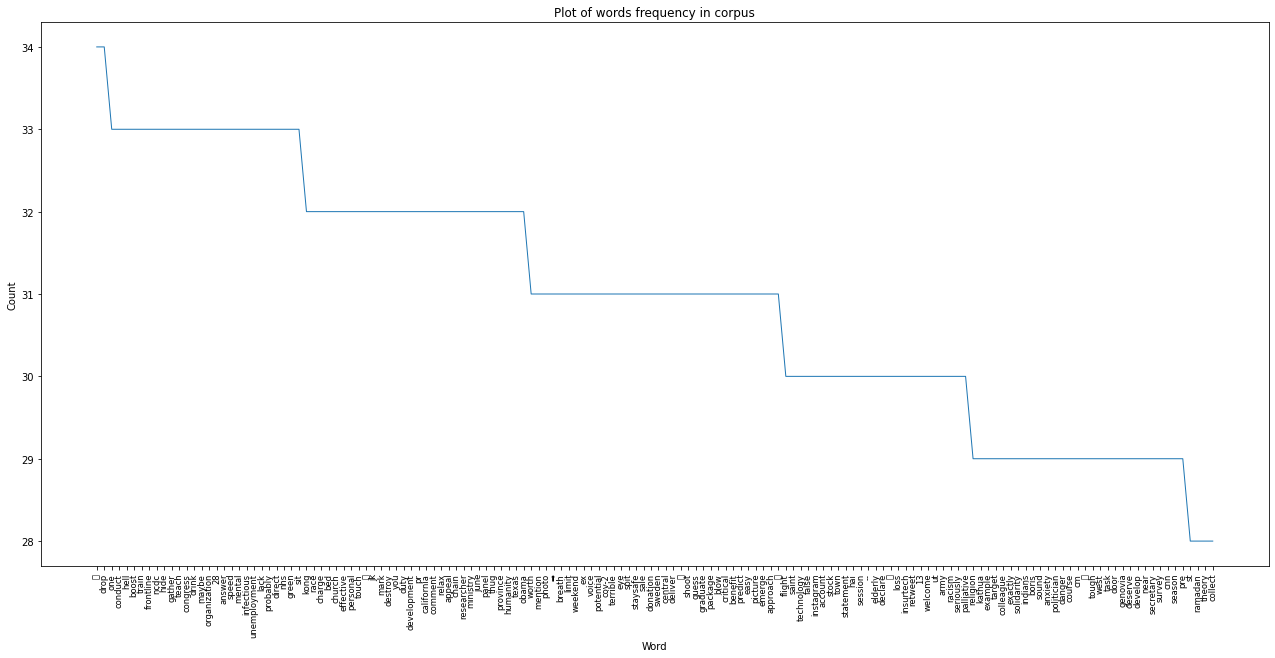

Pulling out indivdual words.
Words extracted.
['cnn', ':', 'accord', 'johns', 'hopkins', 'university', 'tally', 'case', 'unite', 'state', ',', '80,087', 'people', 'die', 'coronav', '…', 'lmfao', 'piss', 'tf', 'whencultural', 'club', 'spend', 'close', 'year', 'prepare']


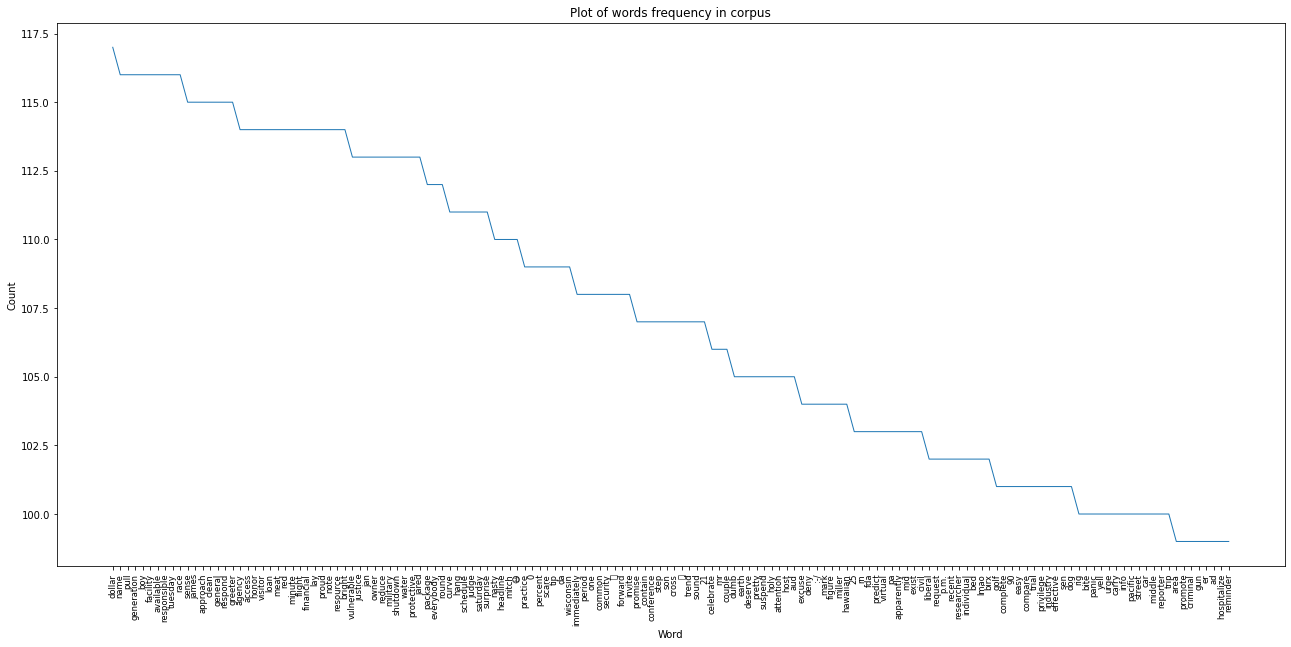

Pulling out indivdual words.
Words extracted.
['prevent', '#', 'covid19', 'use', 'thing', '.', 'good', 'prevent', '.', 'india', ':', '“', 'infect', 'muslims', 'want', 'spread', 'corona', 'infidel', 'die', 'hundred', 'thousand', '”', 'good', 'corona', ',']


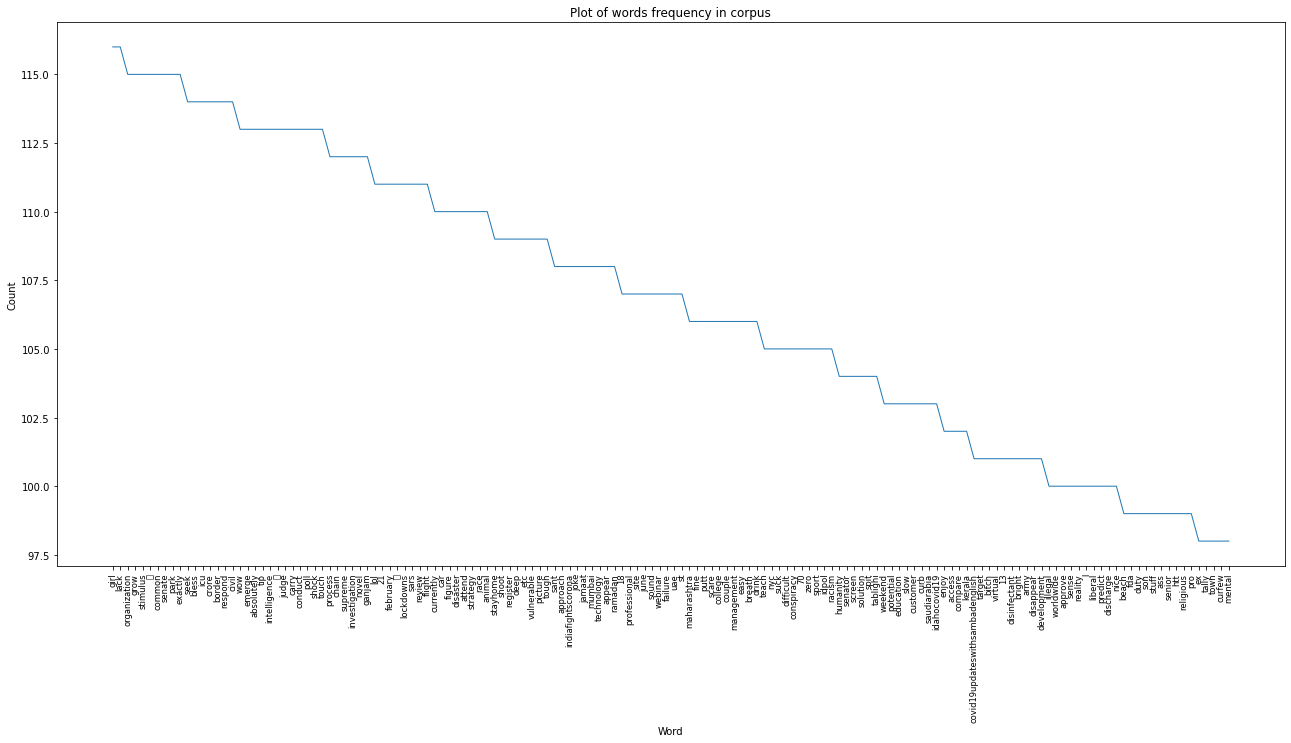

Pulling out indivdual words.
Words extracted.
['upset', 'wellness', 'grifters', 'take', 'advantage', 'corona', 'sell', 'dangerous', 'garbageyou', 'thank', 'th', '…', ',', 'say', 'want', '#', 'illinois', 'citizen', 'cross', 'state', 'line', '#', 'covid19', '\U0001f9a0', ',']


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127998 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127998 missing from current font.
  font.set_text(s, 0, flags=flags)


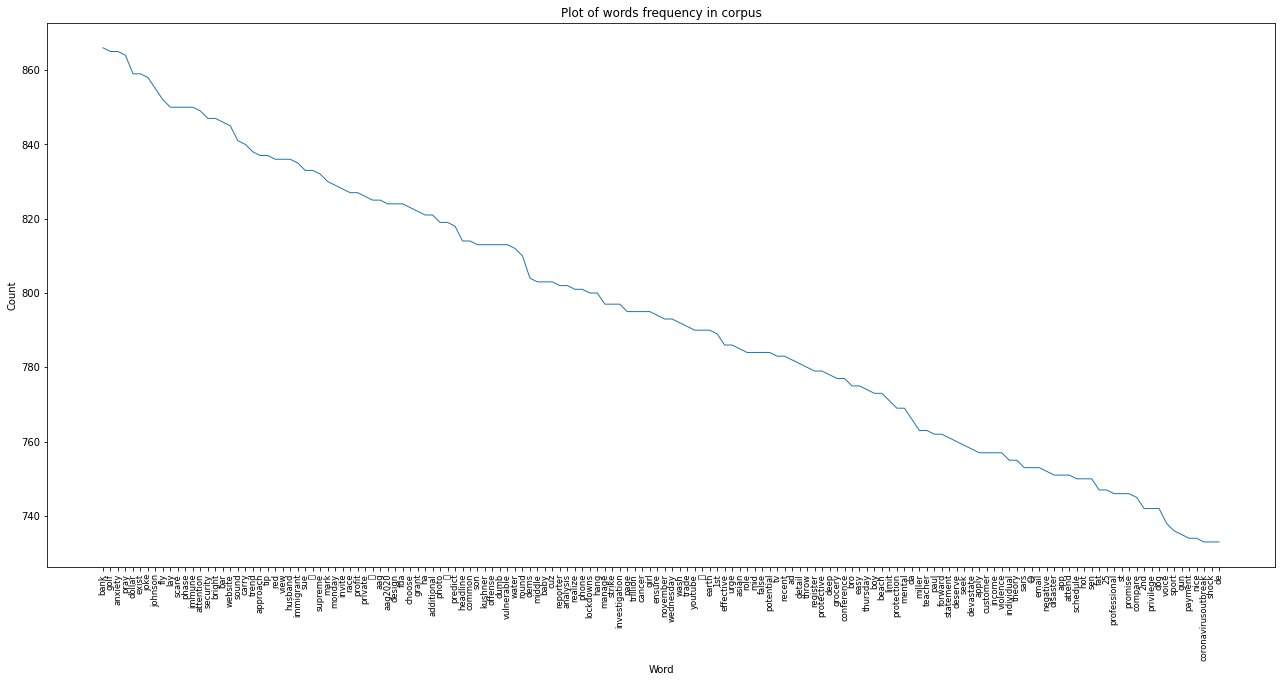

Pulling out indivdual words.
Words extracted.
['guy', '😭', '😷', 'social', 'distance', '/', 'quarantine', 'period', ',', '#', 'bigfish', 'close', 'untill', 'notice', ',', 'well', '…', 'stick', 'comedy.facts', ':', 'n95', '(', 'mask', ')', 'meansn']


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128680 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128680 missing from current font.
  font.set_text(s, 0, flags=flags)


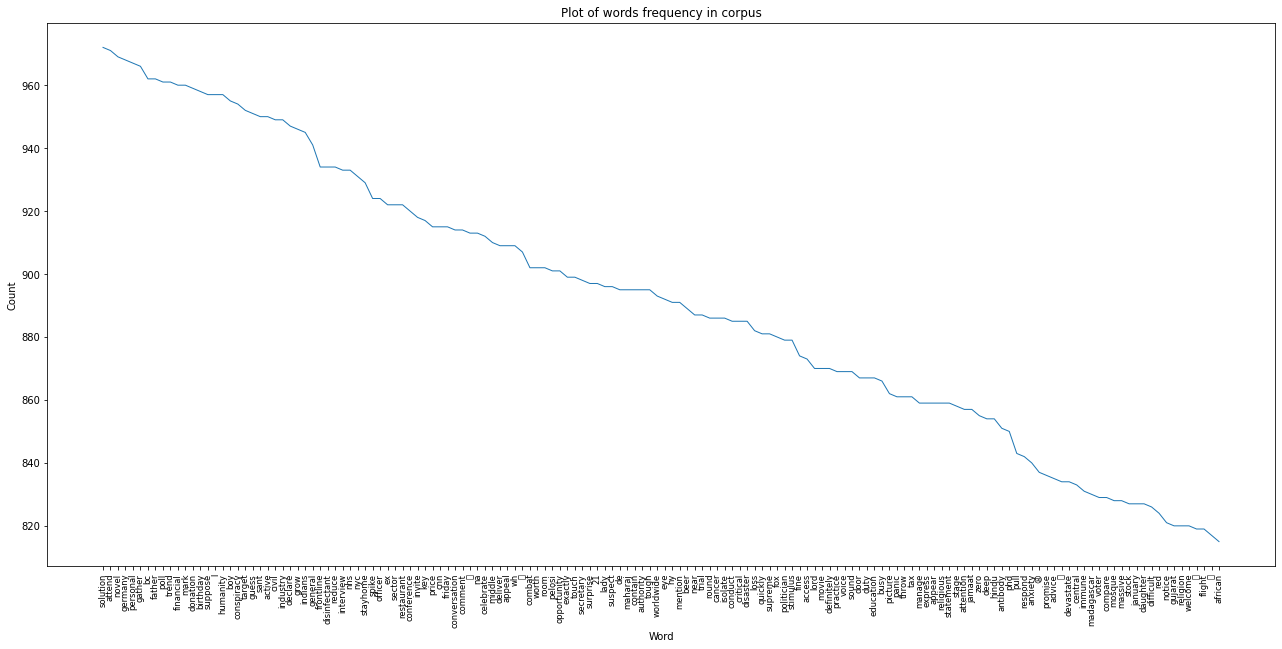

Pulling out indivdual words.
Words extracted.
['tom', 'brady', 'tell', 'leave', 'florida', 'park', 'close', 'coronavirus', ':', 'report', '"', 'individual', 'dementia', 'difficulty', 'abide', 'social', 'distance', 'rules"a', 'message', 'dr', '.', 'andrew', 'frank', ',', 'cognitive']


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127464 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127464 missing from current font.
  font.set_text(s, 0, flags=flags)


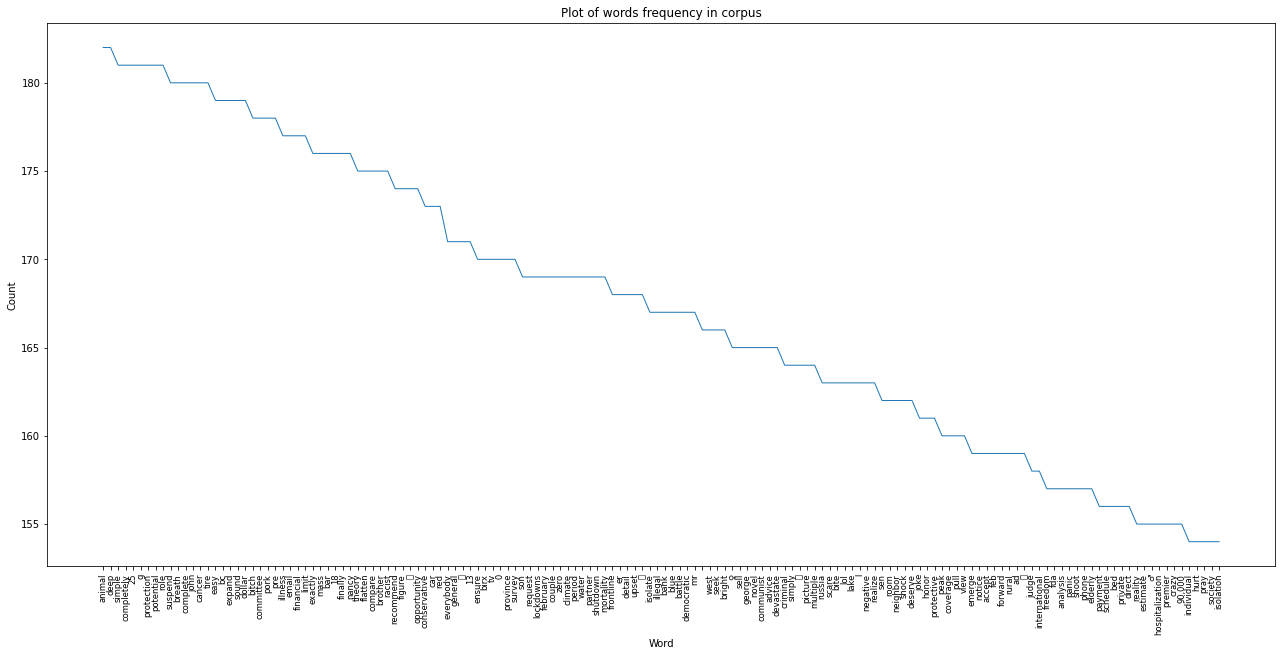

Pulling out indivdual words.
Words extracted.
[',', 'give', 'begin', ',', 'entire', 'yearly', 'salary', ',', '$', '400,000', '$', '450,000', ',', 'government', '.', '…', 'corona', '😬', 'covid', '-19', 'warm', 'hit', '2nd', 'wave', 'summer']


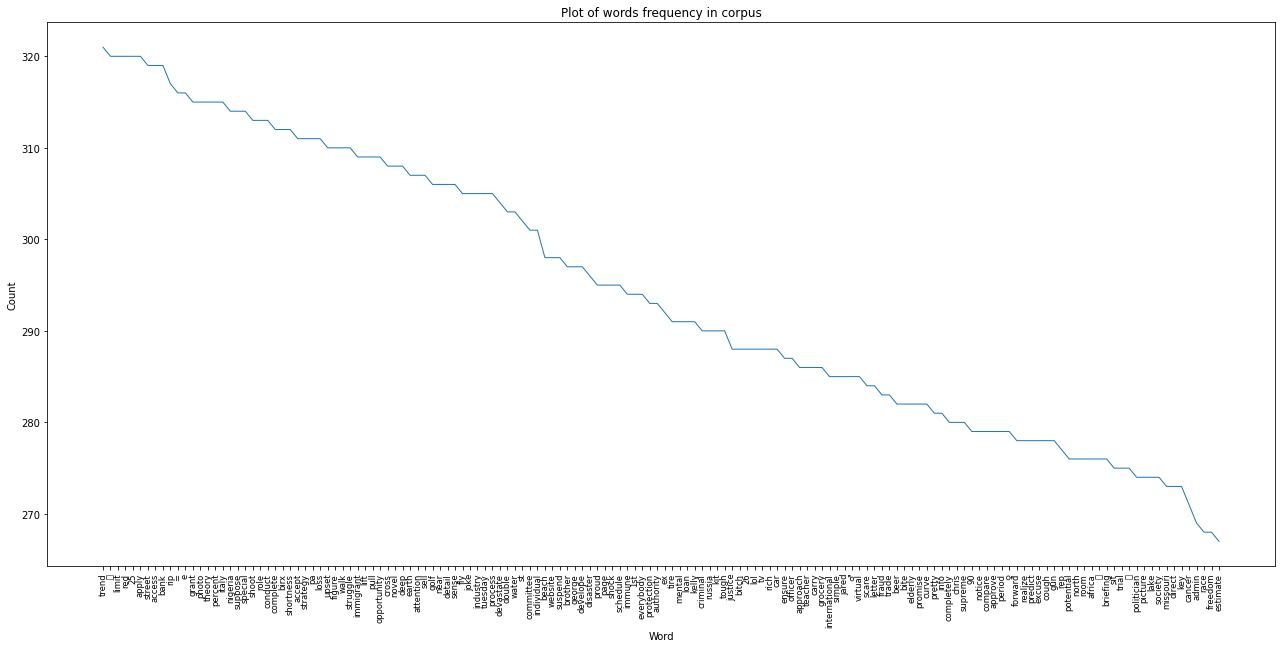

Pulling out indivdual words.
Words extracted.
['acceptable', 'place', 'profit', 'people', '.', '#', 'greed', '#', 'kill', '#', 'cnnchina', '#', 'covidー19', 'ohio', 'judge', 'deem', 'state', 'coronavirus', 'lockdown', 'illegal', 'honestly', ',', 'covid', 'aside', ',']


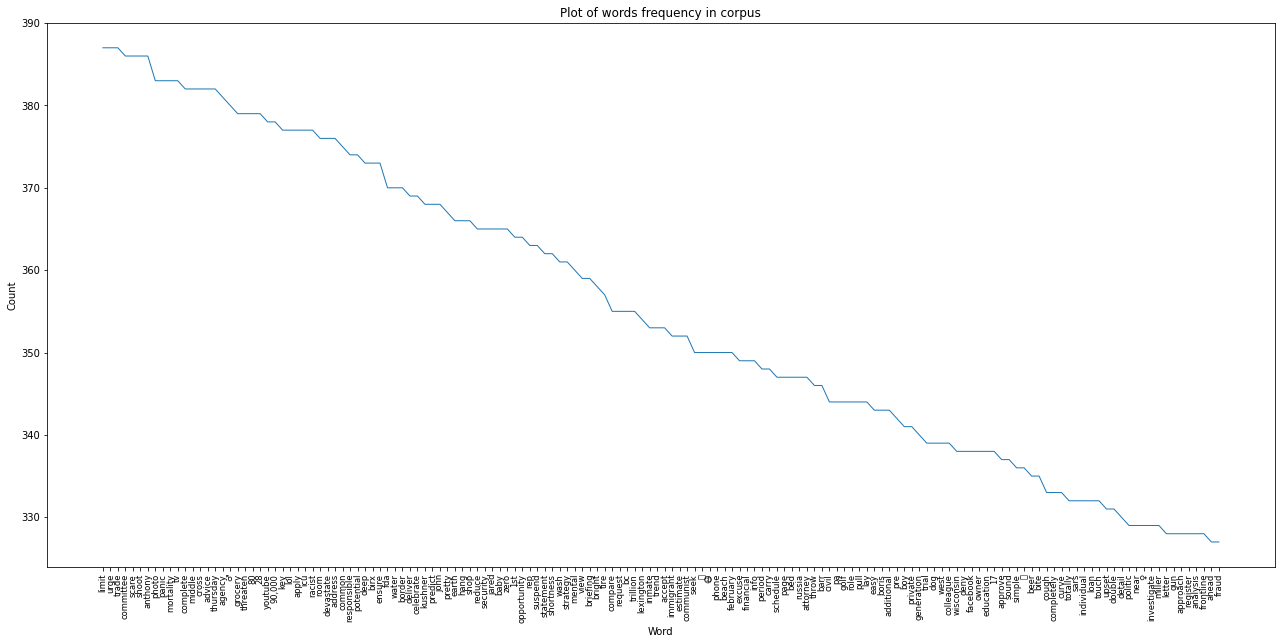

Pulling out indivdual words.
Words extracted.
['joe', 'biden', 'choose', 'defend', 'china', 'day', 'credibly', 'accuse', 'try', 'hack', 'company', 'try', '…', ',', 'give', 'begin', ',', 'entire', 'yearly', 'salary', ',', '$', '400,000', '$', '450,000']


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127476 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127476 missing from current font.
  font.set_text(s, 0, flags=flags)


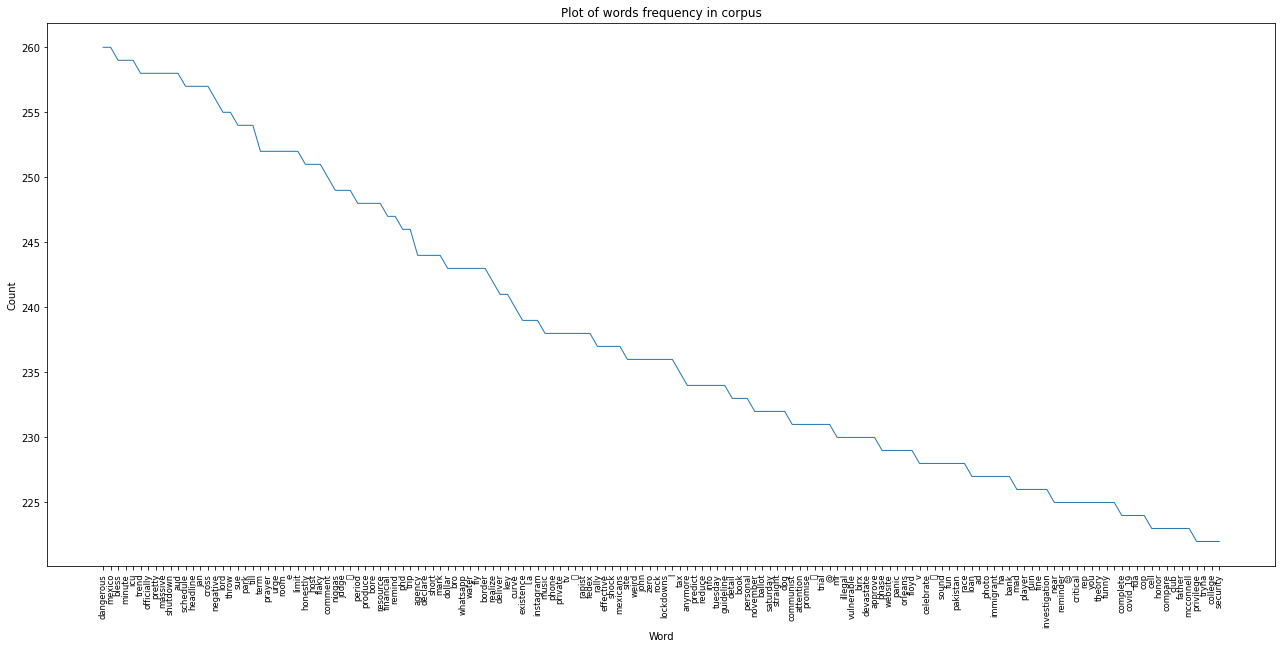

Pulling out indivdual words.
Words extracted.
['think', 'mum', 'whatsapp', 'groupchat', '.', 'recognize', 'privilege', 'refer', 'covid-19', '“', 'bless', 'disguise', '.', '”', 'absolutely', 'stun', '-', 'useful', '-', 'datum', 'visualisation', 'look', 'migrant', 'worker', '#']


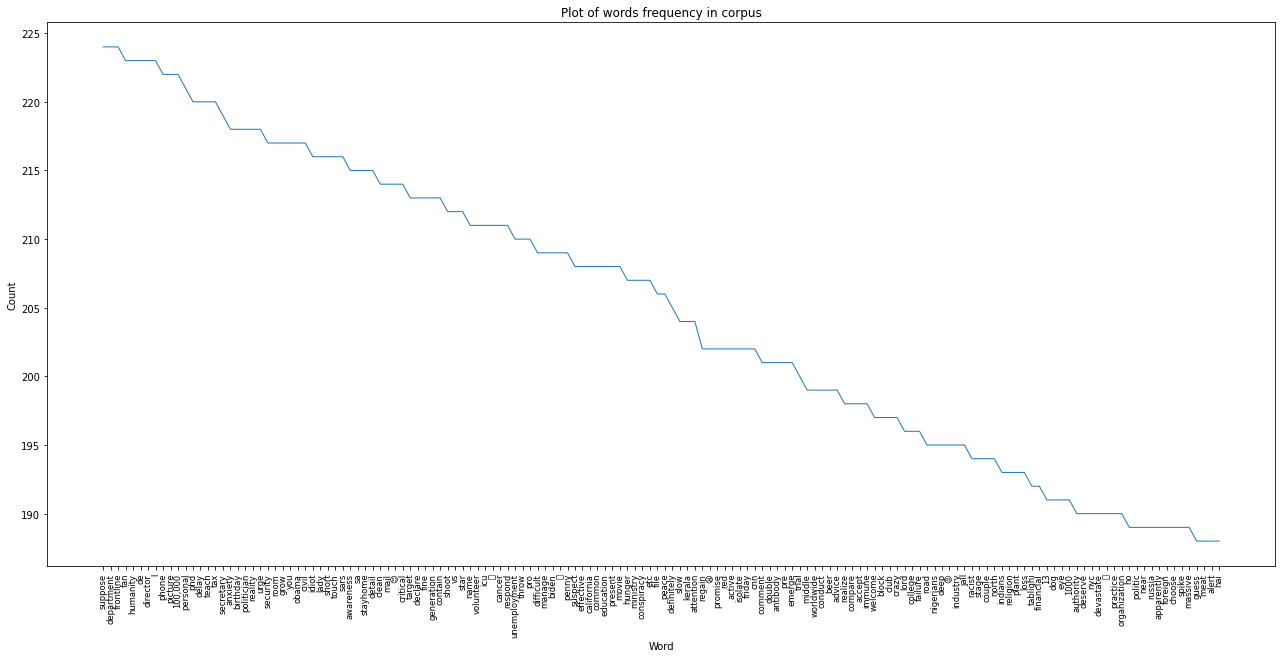

Pulling out indivdual words.
Words extracted.
['genovia', 'report', 'single', 'case', 'covid-19', '.', 'true', 'leadership', 'look', 'like', '.', 'johnson', '‘', 'behavioural', 'sage', '’', 'group', 'slam', 'car', '-', 'crash', 'cummings', 'defence', ':', '“']


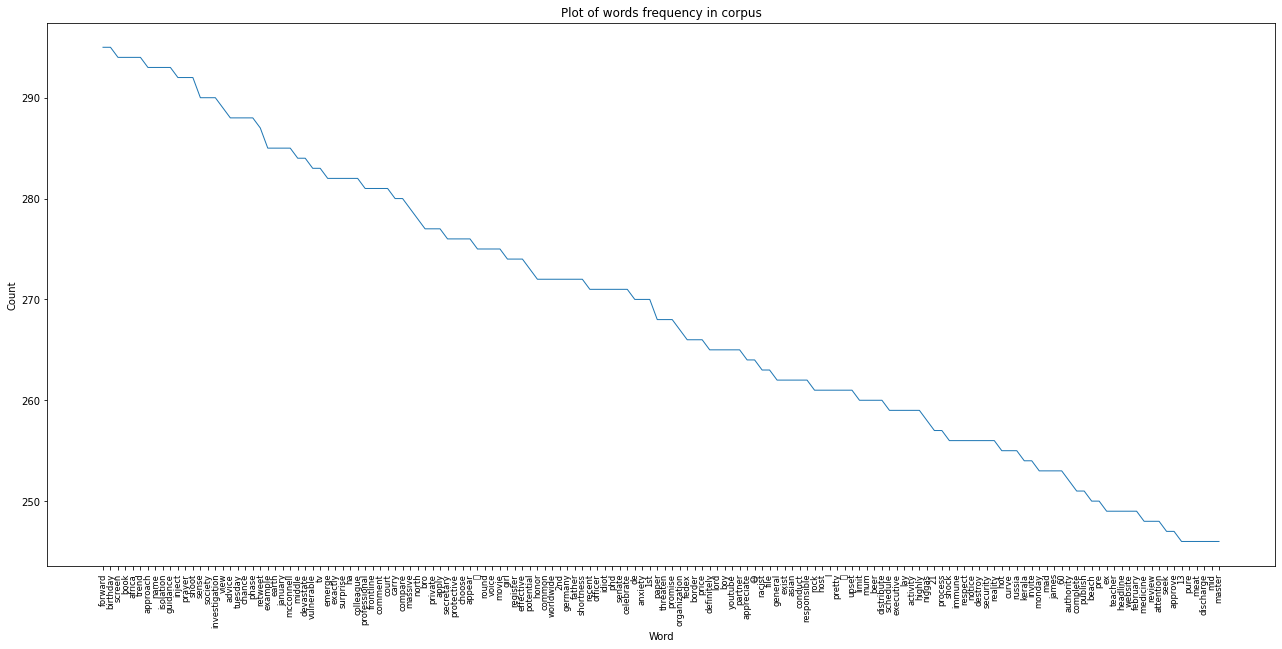

Pulling out indivdual words.
Words extracted.
['niggas', 'move', 'like', 'covid', 'real', 'thing', 'anymore', 'raab', 'like', 'rabbit', 'headlight', '.', 'starmer', 'cool&amp;calm', 'pull', 'piece', '#', 'test', '#', 'carehomes', '#', 'coronavirus', '#', 'pmqs', 'dad']


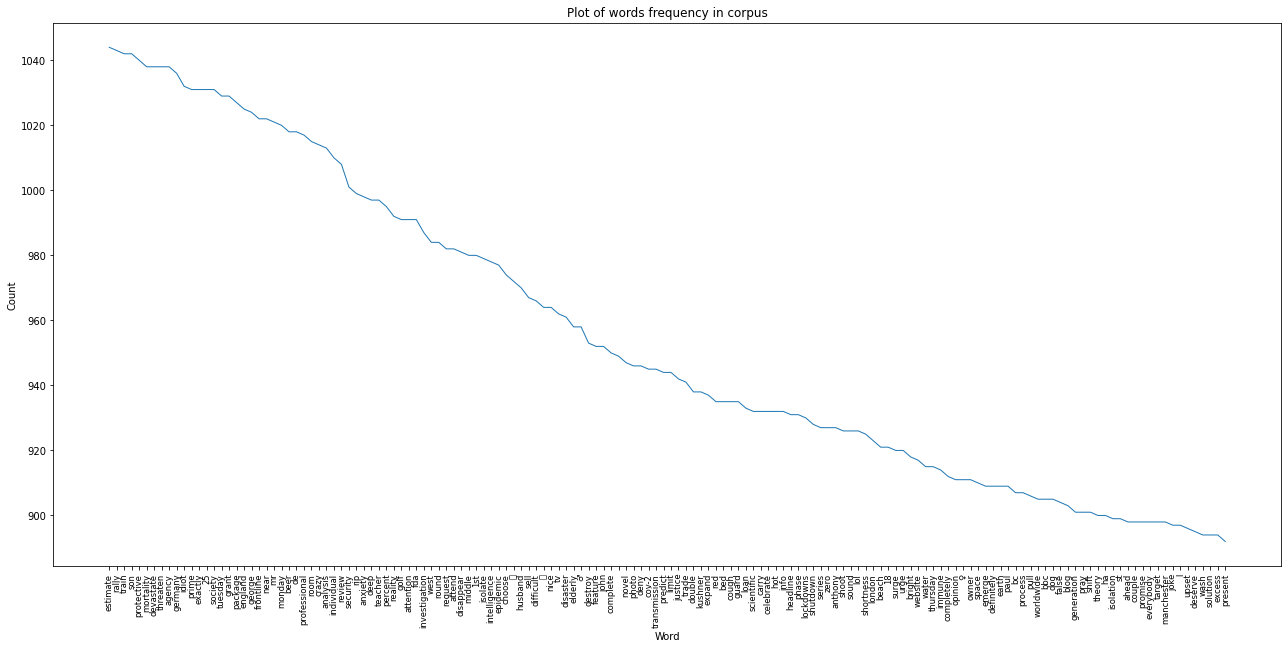

Pulling out indivdual words.
Words extracted.
['u', 'expect', 'charge', 'professional', 'fee', '!', 'u', 'people', '100', 'million', 'dollar', '?', 'u', 'chop', 'finish', '🤦', '\u200d', '♂', '️', 'navarro', 'ask', 'marty', 'byrde', 'wash', 'billion']


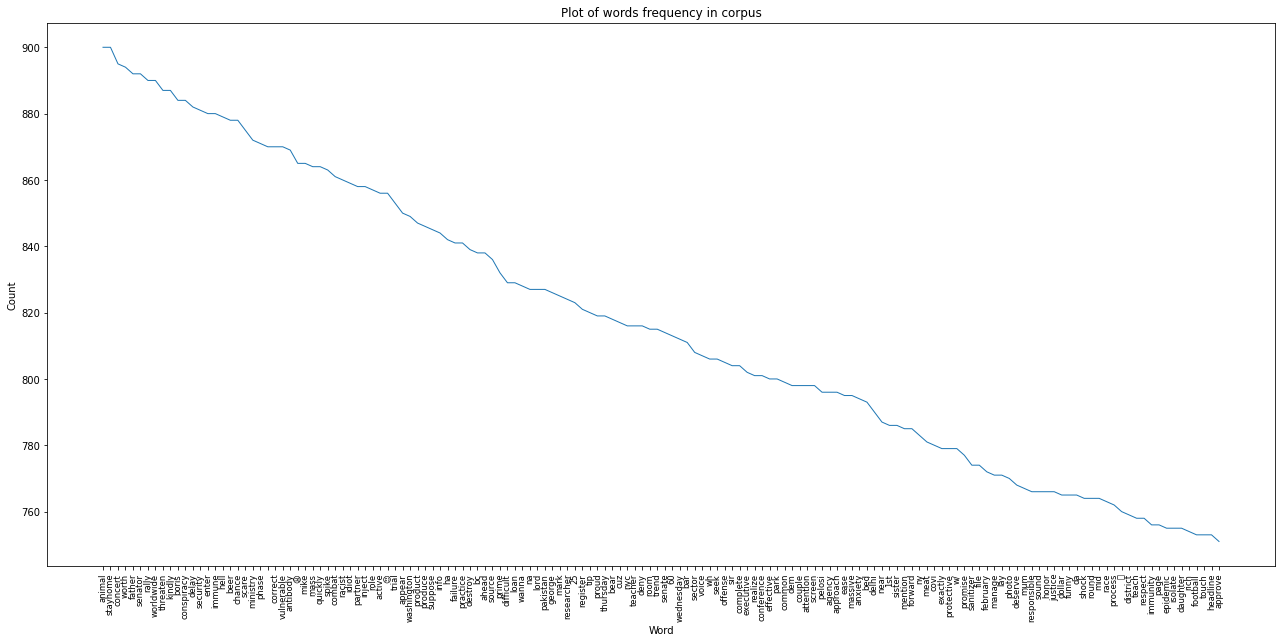

Pulling out indivdual words.
Words extracted.
['new', 'video', 'series', '!', 'human', 'right', '.', ',', 'give', 'begin', ',', 'entire', 'yearly', 'salary', ',', '$', '400,000', '$', '450,000', ',', 'government', '.', '…', 'lol', '.....']


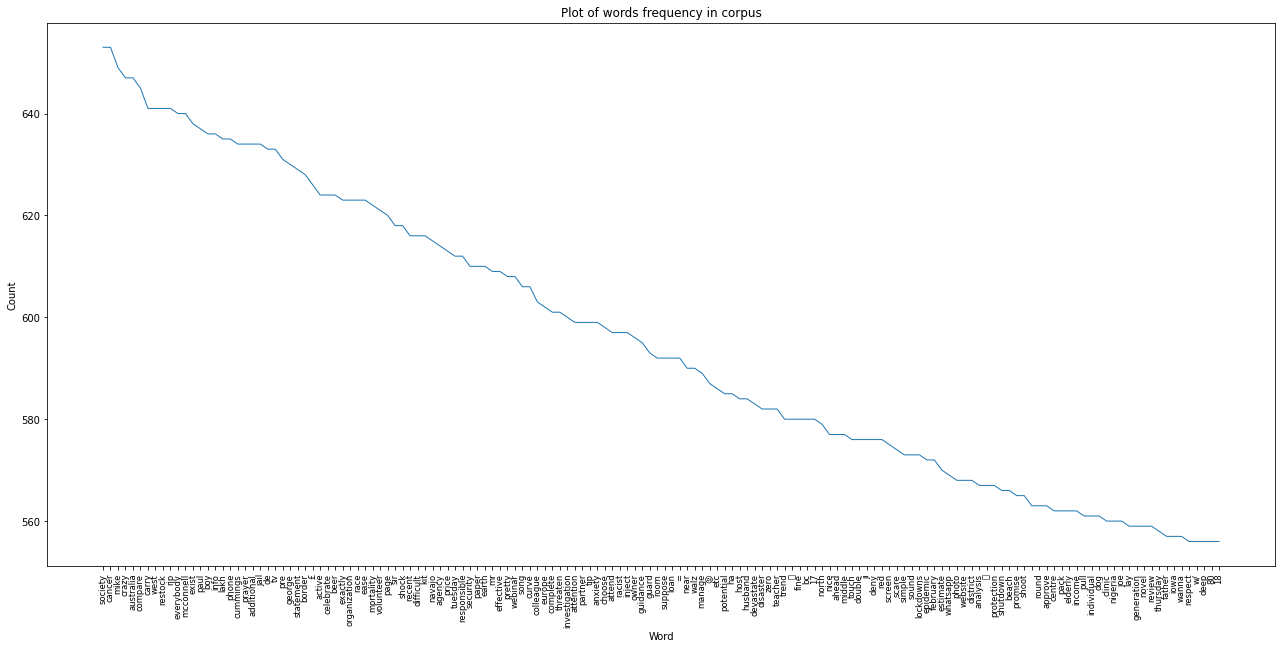

Pulling out indivdual words.
Words extracted.
['cbs', 'exec', '#', '1', ':', '“', 'hey', ',', 'run', 'content', 'covid', 'stuff', ',', 'fill', 'time?”cbs', 'exec', '#', '2', ':', '“', 'get', '!', 'let', 'run', 'movie']


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128588 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128128 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128588 missing from current font.
  font.set_text(s, 0, flags=flags)


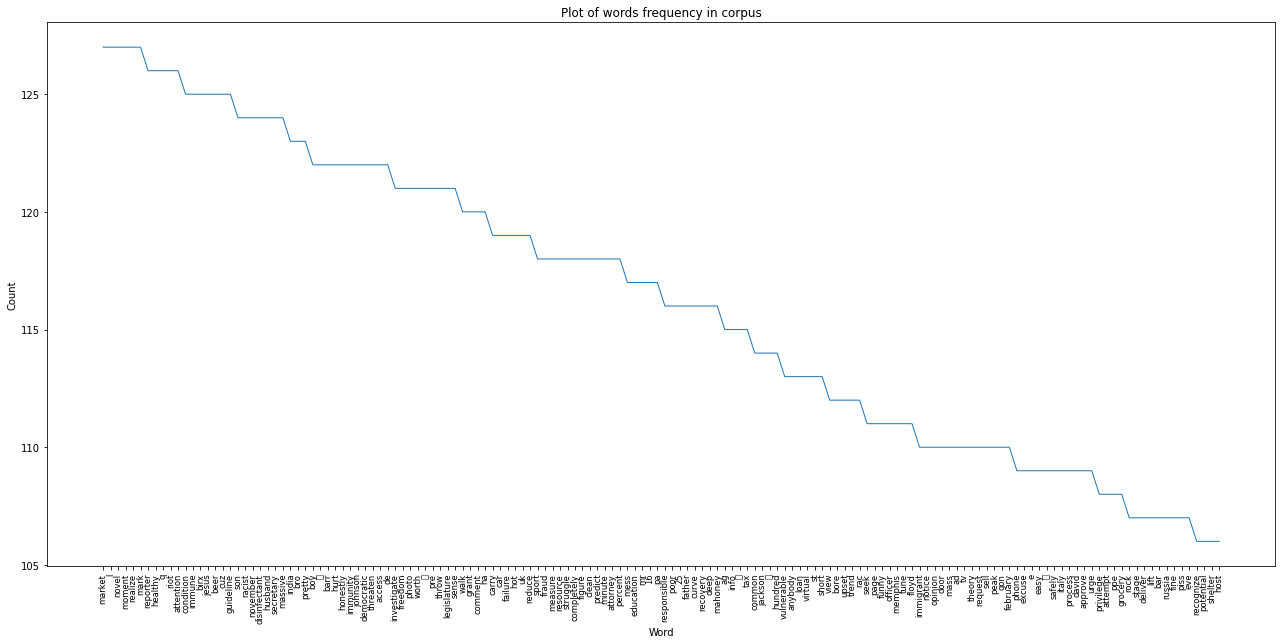

Pulling out indivdual words.
Words extracted.
['point', 'come', 'messiah', ',', 'pleague', 'locust', ',', 'outbreak', 'corona', 'virus', 'people', 'reluctant', 'seek', 'lord', 'enter', 'eternity', '.', '#', 'featuringapocalypse', 'bro', '3', 'song', 'hear', 'tl', '😂']


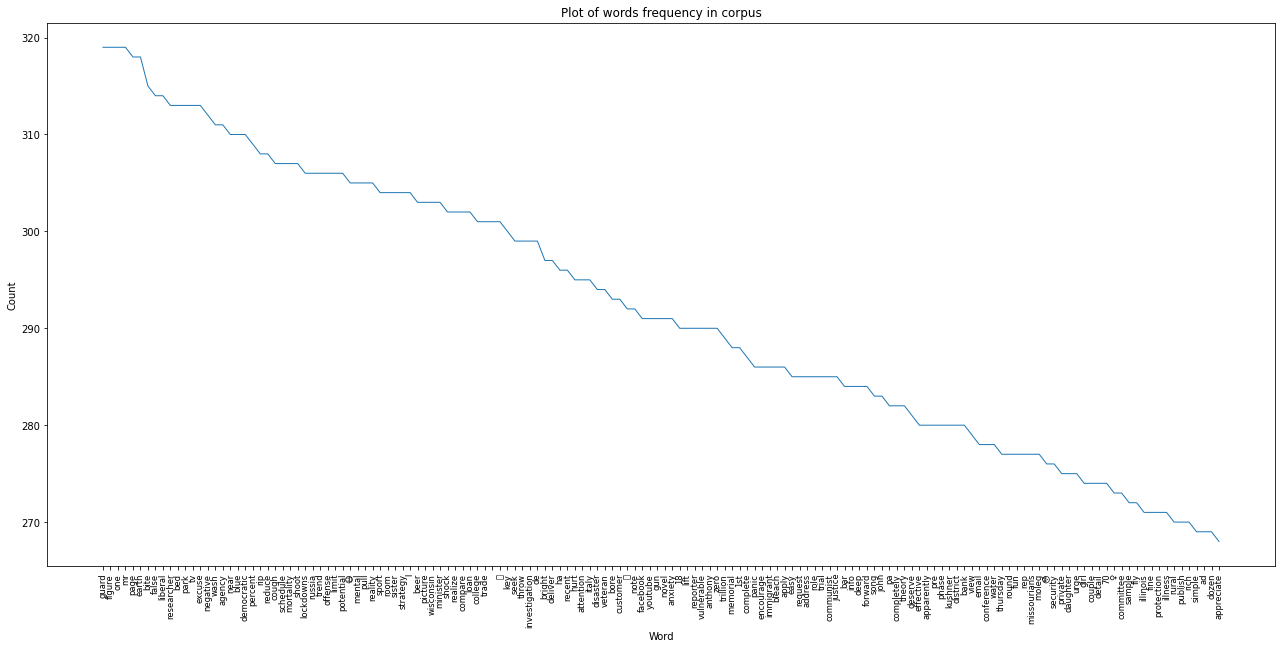

Pulling out indivdual words.
Words extracted.
['people', 'dye', 'global', 'pandemic', ',', 'south', 'african', 'man', 'mind', 'occupy', '“', 'slay', 'queen', '”', '?', '?', '?', '?', '?', 'u.s', '.', 'test', '250,000', 'individual', 'day']


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127468 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127468 missing from current font.
  font.set_text(s, 0, flags=flags)


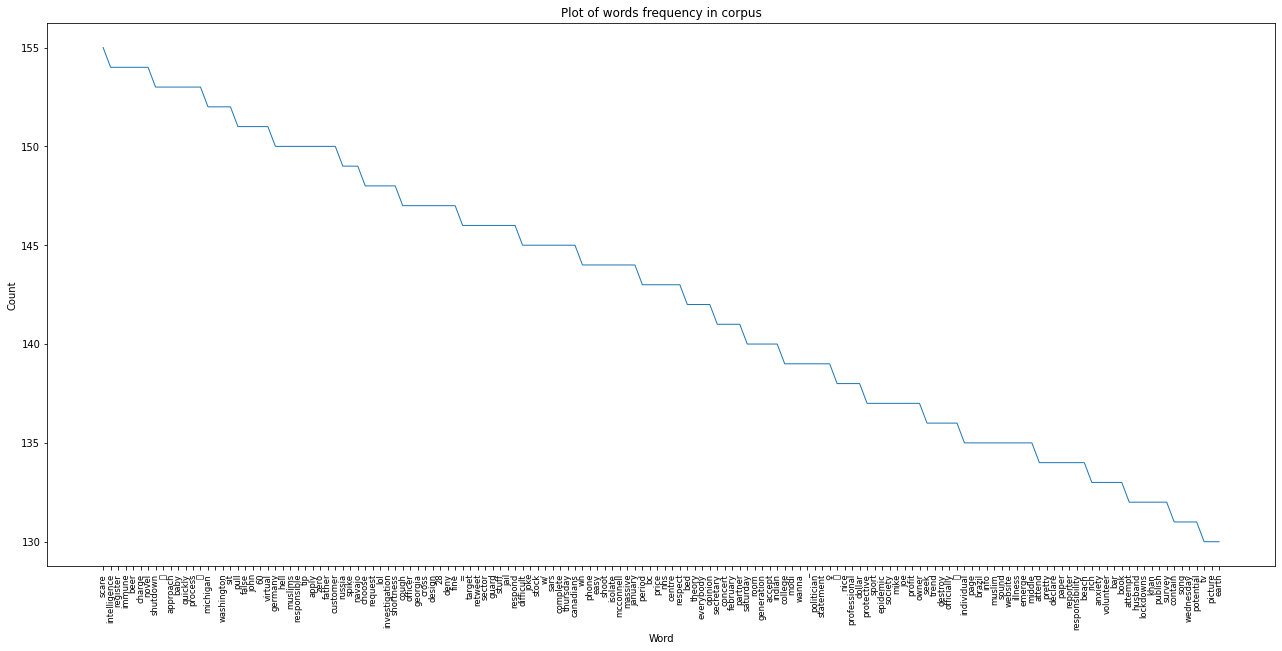

Pulling out indivdual words.
Words extracted.
['strongly', 'condemn', 'kind', 'prejudice', '&', 'amp', ';', 'appeal', 'fellow', 'indians:-let', 'allow', 'panic', '&', 'amp', ';', 'fear', 'provoke', 'b', '…', 'revelation', 'chapter', '15', '7', 'plague', 'god']


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127475 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127470 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127475 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127470 missing from current font.
  font.set_text(s, 0, flags=flags)


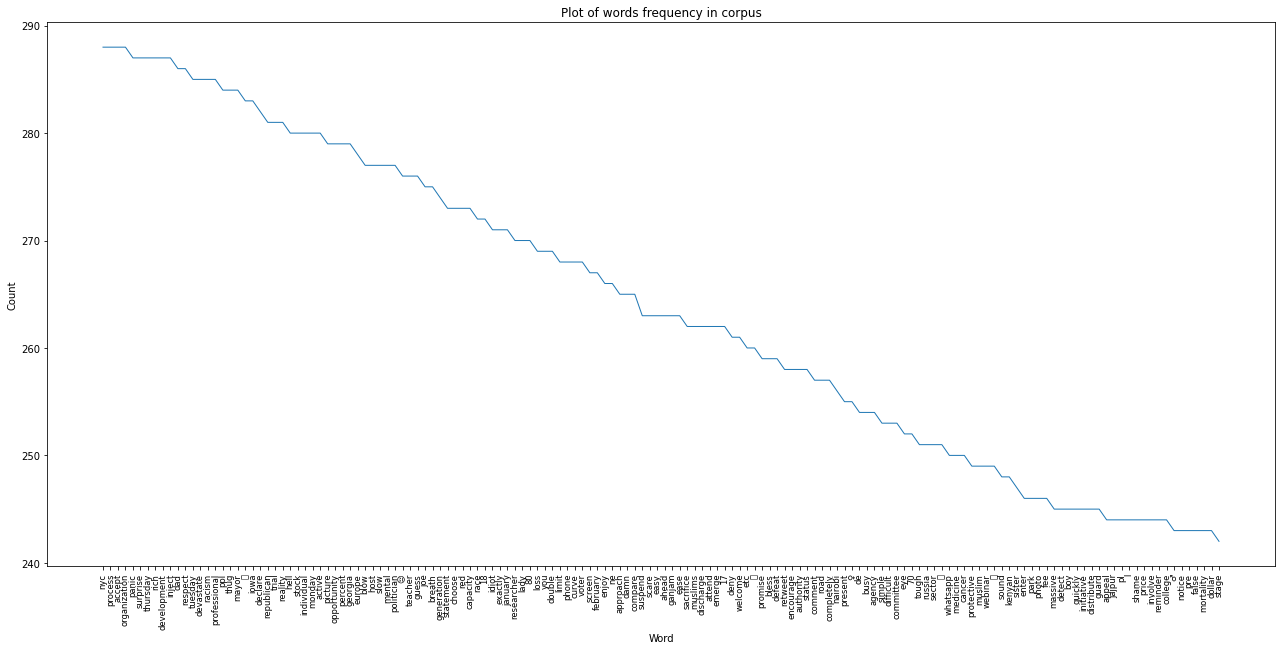

Pulling out indivdual words.
Words extracted.
['\U0001f92f', 'sub', 'unreal', 'mami', '😍', 'fun', 'play', '.', '#', 'onlyfans', '#', 'onlyfansgirl', '#', 'onlyfansleak', '#', 'onlyfansbabe', '#', 'onlyfanspromo', '#', 'sellingudes', '#', 'sellingcontent', '#', 'buyingcontent', '#']


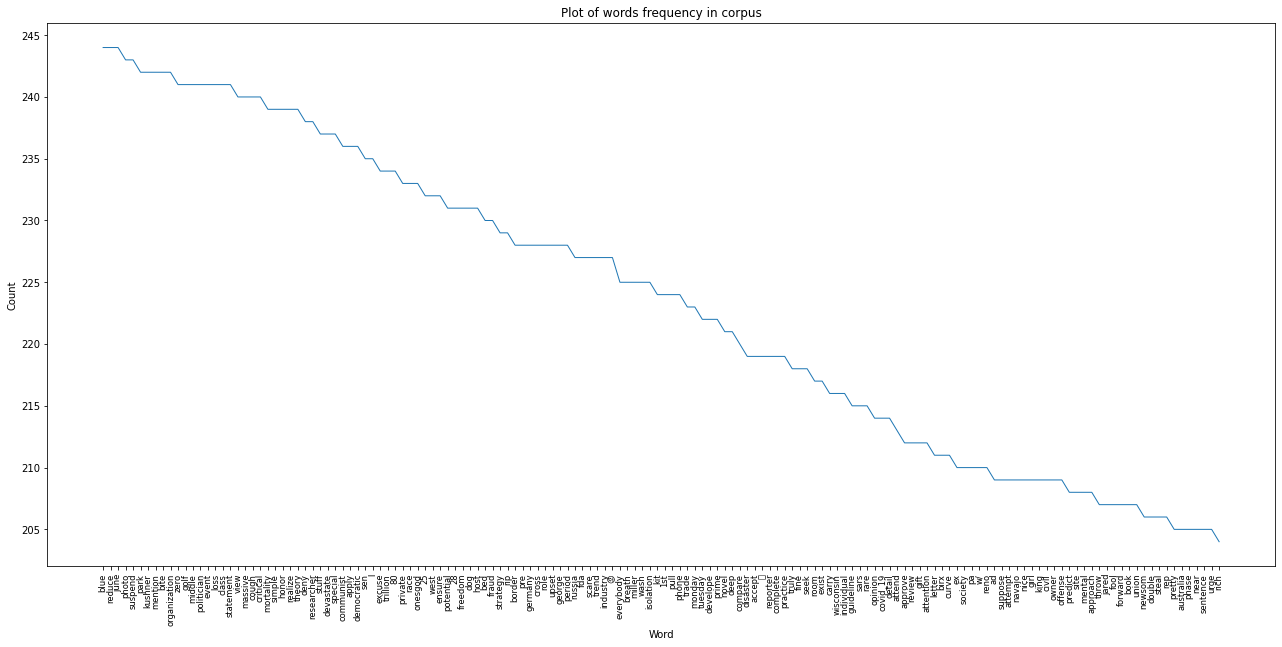

Pulling out indivdual words.
Words extracted.
['gosh', ',', 'get', 'wrong', '.', 'michigan', 'beat', 'suspect', 'move', 'nurse', 'home', 'diagnose', 'covid-19', ',', 'say', 'h', '…', '#', 'covid19', 'magnify', 'exist', 'inequalitiesthe', 'correlation', 'woman', 'unvalued']


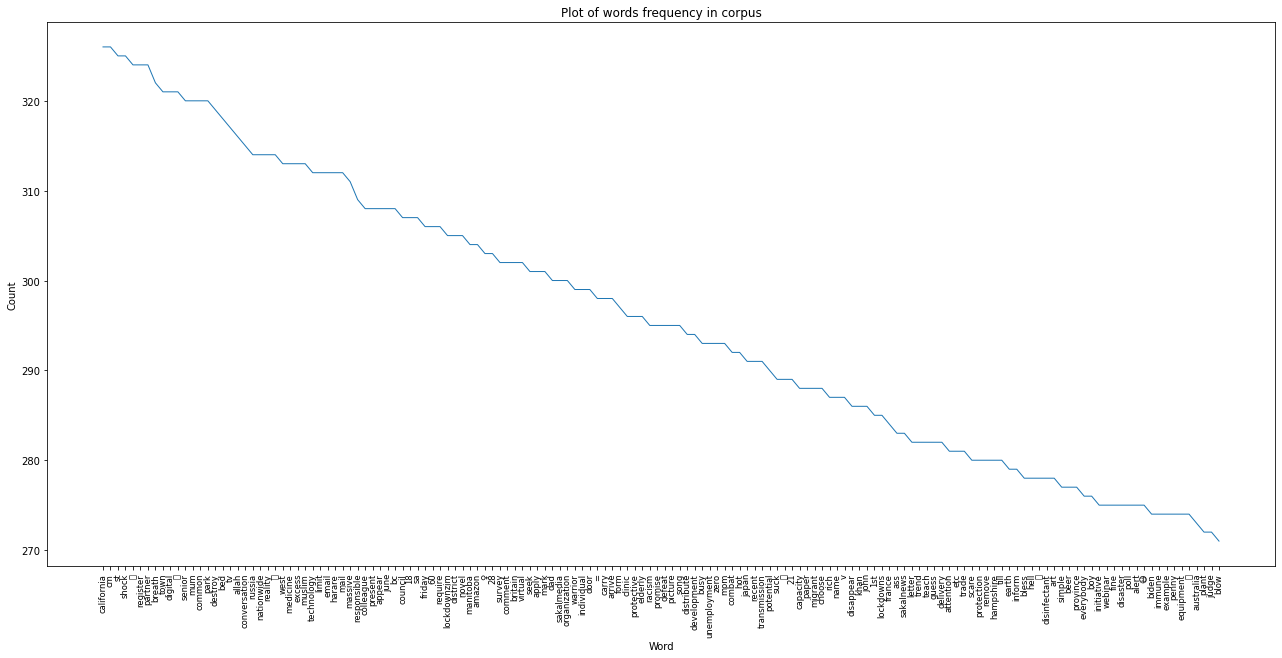

Pulling out indivdual words.
Words extracted.
['son', 'admit', 'child', 'hospital', '.', 'corona', 'virus', '.', 'good', 'thought', 'appreciate', '.', 'bro', 'go', 'to', 'ruth', 'langmore', 'beat', 'asse', '2nd', 'wave', 'covid-19', 'stretch', 'outfit', 'lay']


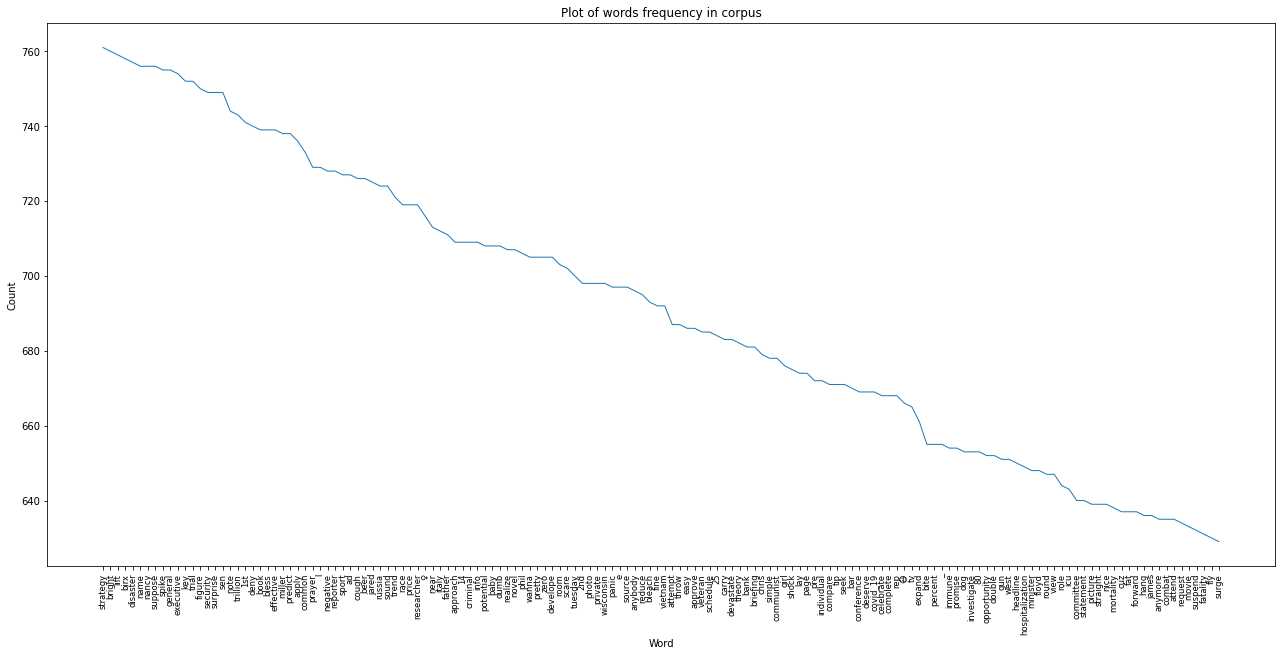

Pulling out indivdual words.
Words extracted.
['theory', 'push', 'trump', 'coronavirus', 'begin', 'laboratory', 'wuhan', "'", 'pure', 'fabrication', ',', "'", 'accord', 'lab', 'director', 'tell', 'march', '#', 'endlockdown', '"', 'cdc', 'new', '"', 'well', 'estimate']


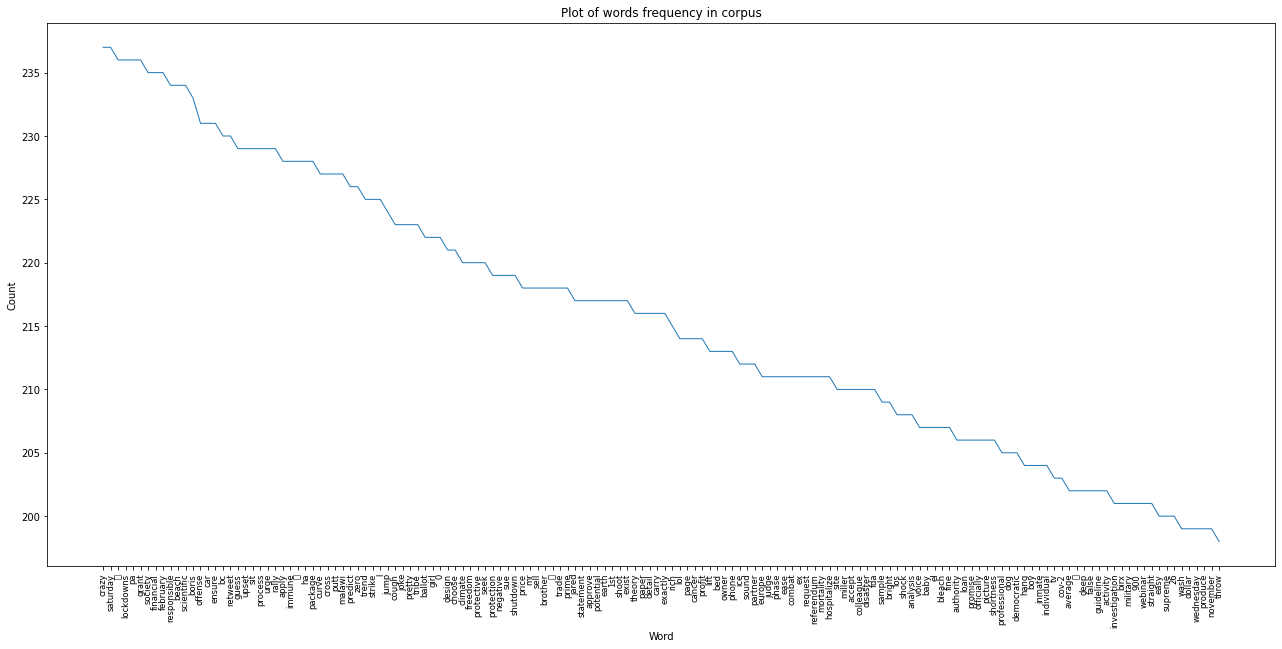

Pulling out indivdual words.
Words extracted.
['fuck', 'mitch', ',', 'putin', 'puppet', '!', 'make', 'donation', 'sure', 'retire', '!', 'cate', 'people', 'employ', ',', 'u', 'decide', 'home', 'early.the', 'way', 'fight', 'corona', 'lockdown.simple.one', 'pt', 'heal']


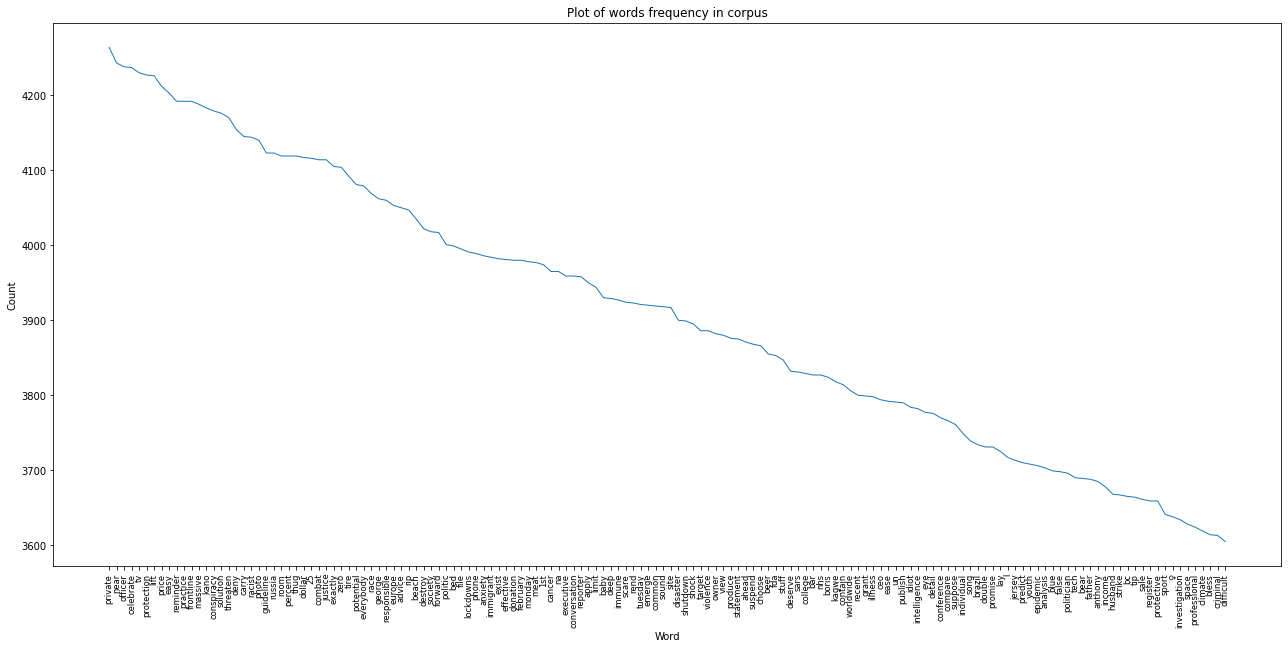

Pulling out indivdual words.
Words extracted.
['accord', 'ons', ',', '40,000', 'uk', 'die', 'coronavirus', '.', 'double', 'figur', '…', 'try', '..', 'editorial', 'leftist', 'editorial', 'board', 'convince', '.', 'address', 'obvious', 'financial', 'benefit', 'count', 'covid']


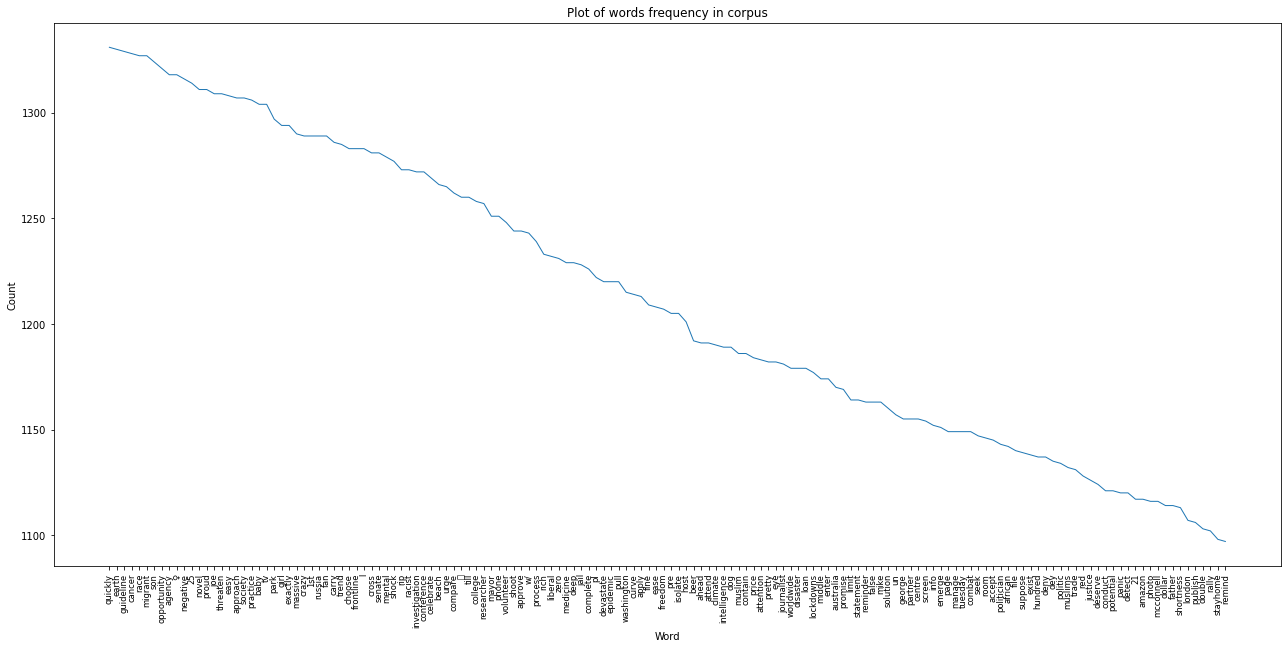

Pulling out indivdual words.
Words extracted.
['cdc', 'announce', 'corona', 'spread', 'instagram', 'story', 'challenge', ':-/', 'time', 'corona', 'important', '#', 'staysafestayhealthy', '.', 'st.dr', '.', 'singh', 'ji', 'insan', 'inspire', 'eat', 'immunity', 'booster', 'meditation', 'regular']


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128312 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128312 missing from current font.
  font.set_text(s, 0, flags=flags)


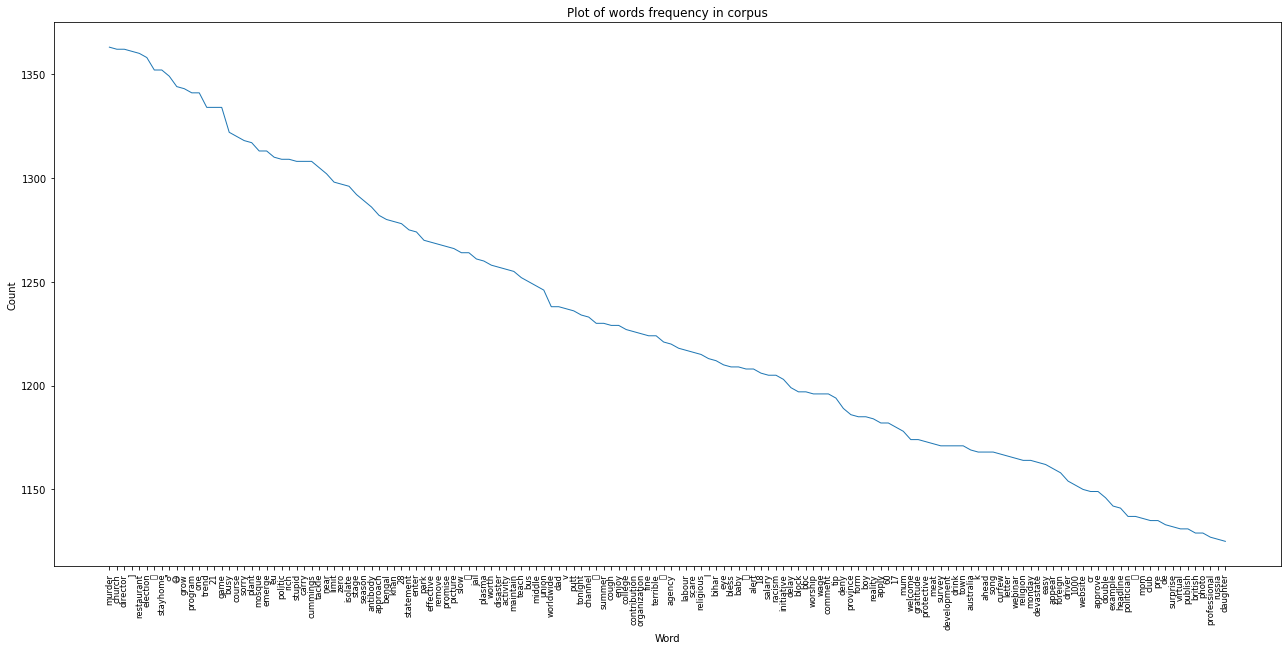

Pulling out indivdual words.
Words extracted.
['#', 'santrampalji_canendcoronacorona', 'virus', 'eradicate', 'pray', 'sant', 'rampal', 'ji', 'maharaj', 'ji', '.', 'htt', '…', 'datum', 'suggest', 'hot', 'country', 'massive', 'numb', 'case', ',', 'virus', 'countries.lim', '…', '#']


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8294 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2325 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2379 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2352 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2344 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2366 missing from current font.
  font.set_text(s

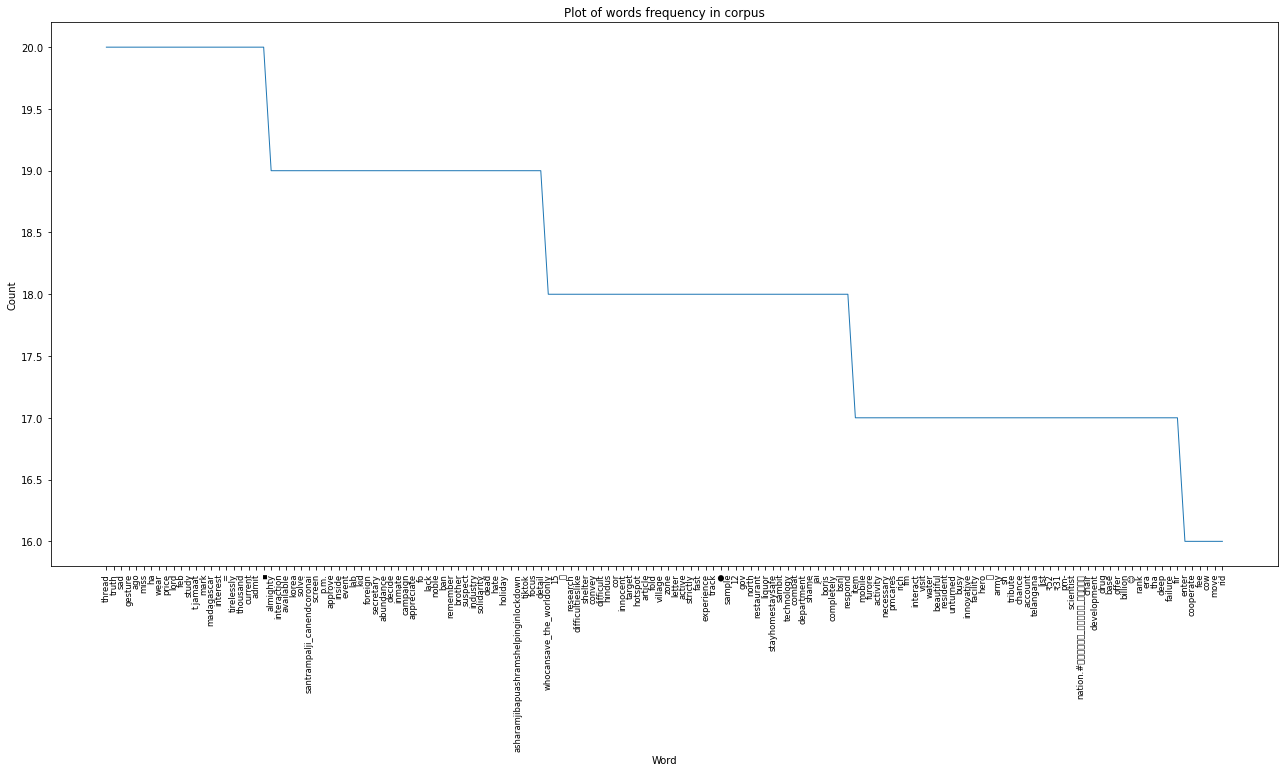

Pulling out indivdual words.
Words extracted.
[',', 'give', 'begin', ',', 'entire', 'yearly', 'salary', ',', '$', '400,000', '$', '450,000', ',', 'government', '.', '…', 'mean', 'get', 'wear', 'mask', '...', '🤷', '🏽\u200d', '♂', '️']


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128148 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127757 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128148 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127757 missing from current font.
  font.set_text(s, 0, flags=flags)


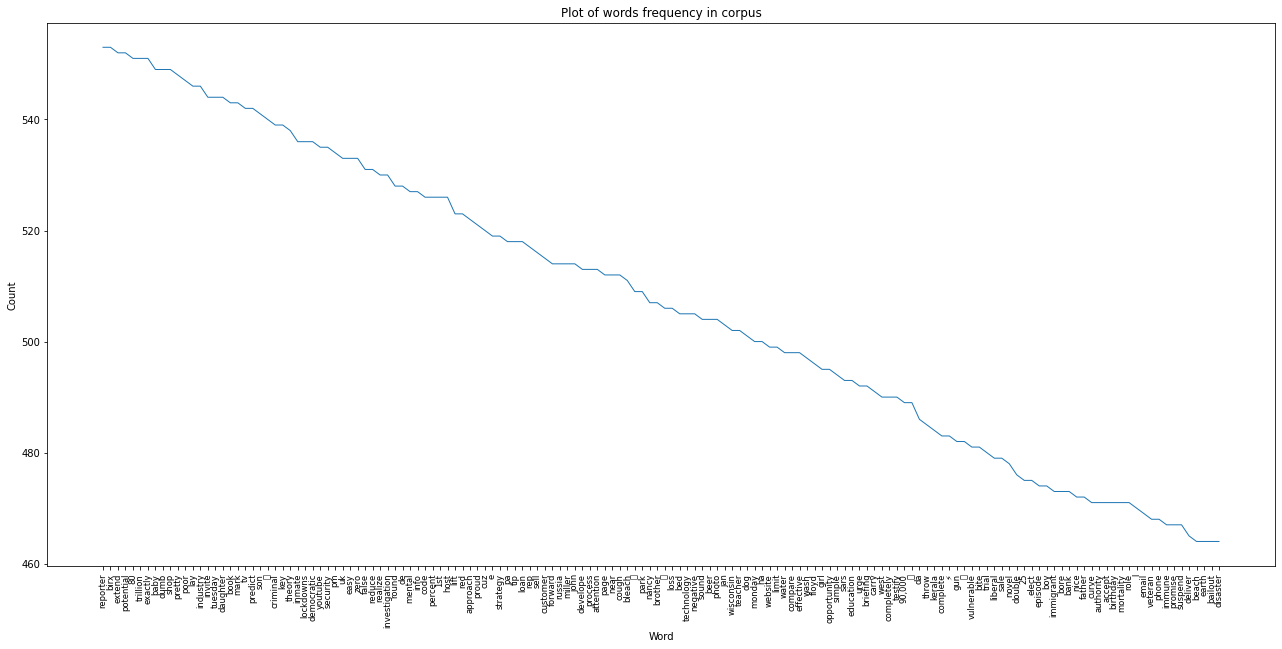

Pulling out indivdual words.
Words extracted.
['.', 'investigate', 'china', 'covid-19', '.', 'discover', 'learn', 'new', 'cnn', 'special', 'report', '–', 'china', 'deadly', 'secret', '.', 't', '…', 'ba', 'catch', 'corona', 'virus', ',', 'give', 'begin']


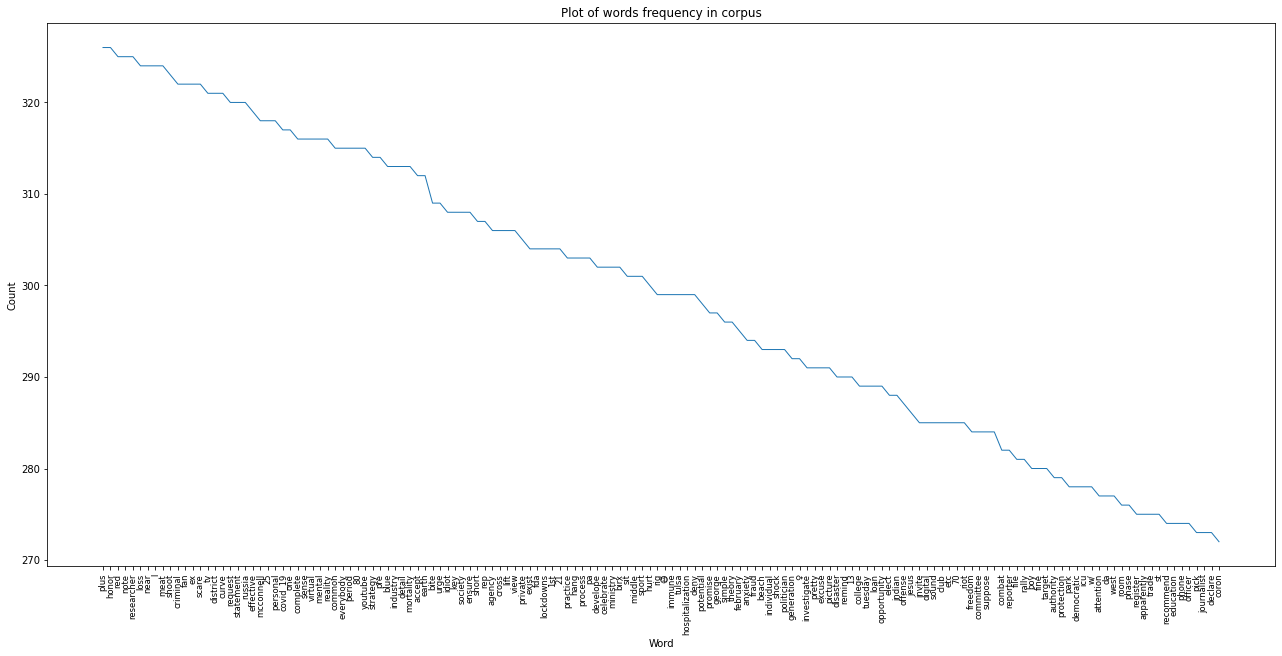

Pulling out indivdual words.
Words extracted.
['$', '5,000', 'toy', 'donation', 'brighten', 'coronavirus', 'quarantine', 'dozen', 'portland', 'foster', 'child', 'weird', 'people', 'mourn', 'covid', 'death', 'people', 'have', 'cookouts', '.', 'weird', 'time', '.', '#', 'master']


Pulling out indivdual words.
Words extracted.
[',', 'give', 'begin', ',', 'entire', 'yearly', 'salary', ',', '$', '400,000', '$', '450,000', ',', 'government', '.', '…', 'weird', 'people', 'mourn', 'covid', 'death', 'people', 'have', 'cookouts', '.']


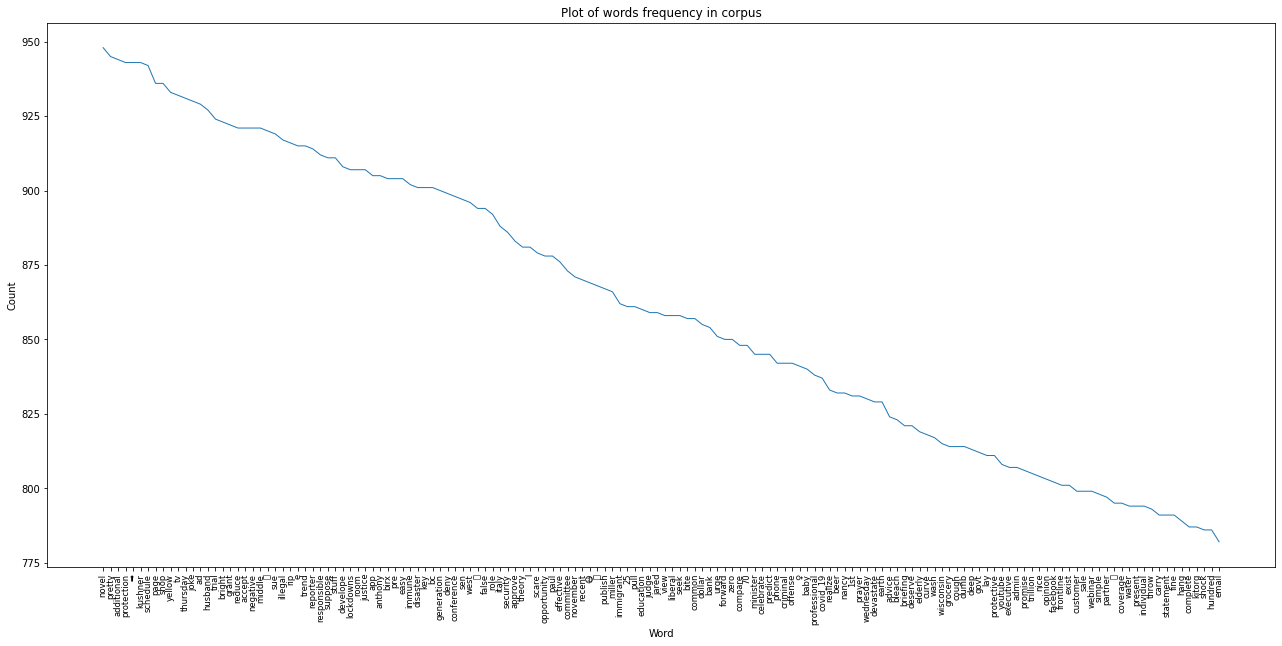

Pulling out indivdual words.
Words extracted.
['(', '1/2', ')', 'brazil', 'strong', 'partner', 'world', '.', 'implement', 'temporary', 'restriction', 'foreign', 'n', '…', 'comment', '!', '😿', '#', 'moi', '#', 'mariateresavierar', '#', 'cuarentenas', '#', 'covid19']


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128681 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128681 missing from current font.
  font.set_text(s, 0, flags=flags)


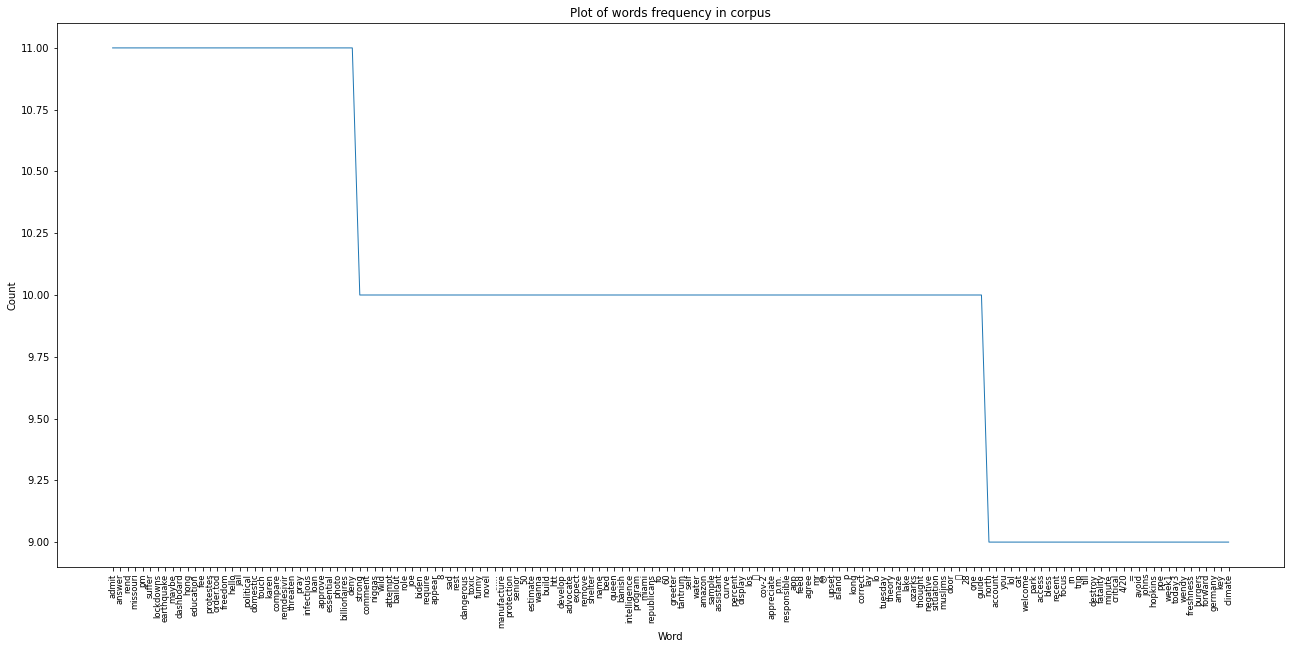

Pulling out indivdual words.
Words extracted.
['hear', 'lot', 'minister', 'protect', 'vulnerablethat', 'include', 'homeless', '&', 'amp', ';', 'rough', 'sleepersth', '…', 'bore', 'bore', 'guy', '!', 'get', 'job', 'definitely', 'worth', '!', 'bat', '11', 'let']


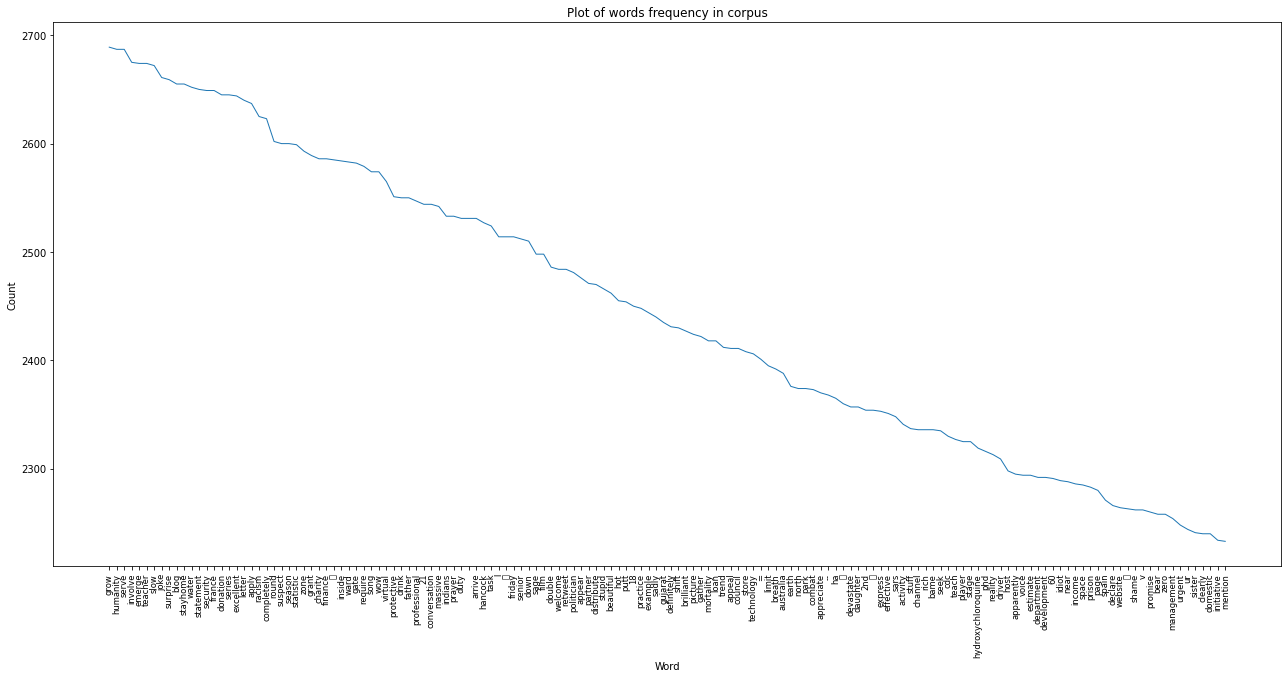

Pulling out indivdual words.
Words extracted.
['nuclear', 'level', 'piss', '-', 'bs!dying', 'wwii', 'veteran', 'deny', 'family', 'visitation', 'coronavirus', '#', 'howtoend_coronapandemiconly', 'saint', 'rampal', 'ji', 'maharaj', 'save', 'world', 'terrible', 'disease', 'like', 'corona', 'philosophy', 'mum']


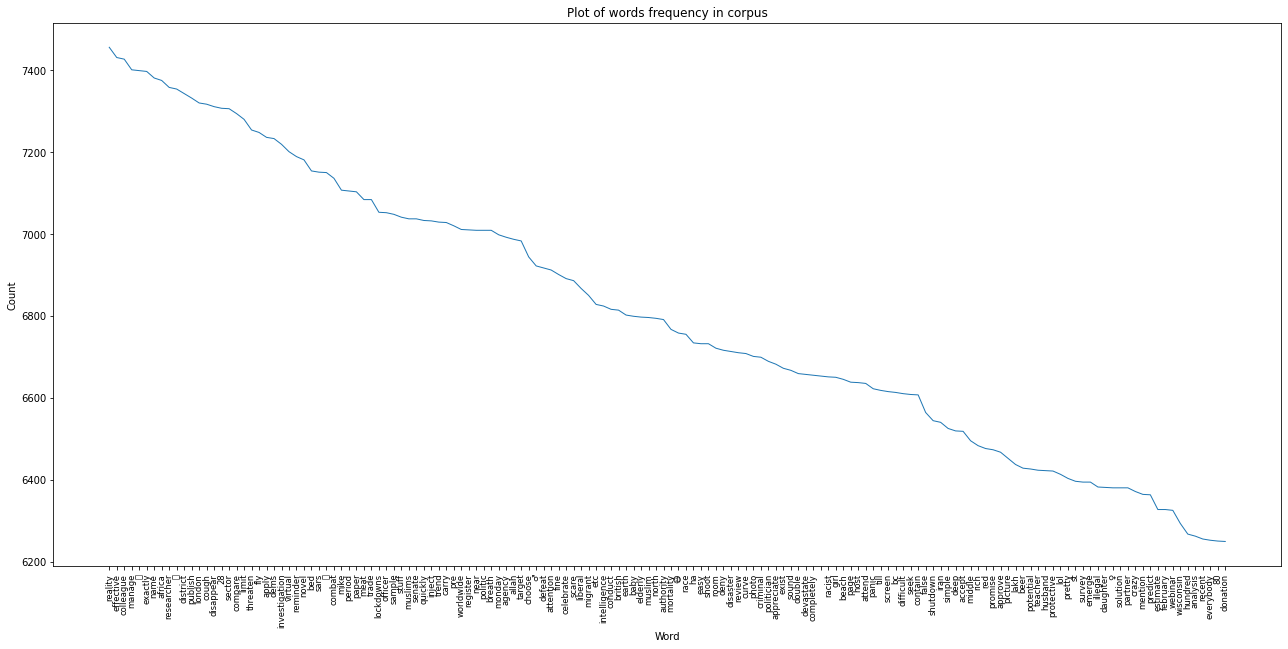

Pulling out indivdual words.
Words extracted.
['killer', 'murdochs', 'act', 'private', 'live', 'protect', 'corona', 'shortness', 'breath', ',', 'headache', ',', 'sore', 'throat', '—', 'add', '“', 'beat', '2', 'hour', '”', 'corona', 'symptom', 'wh', '…']


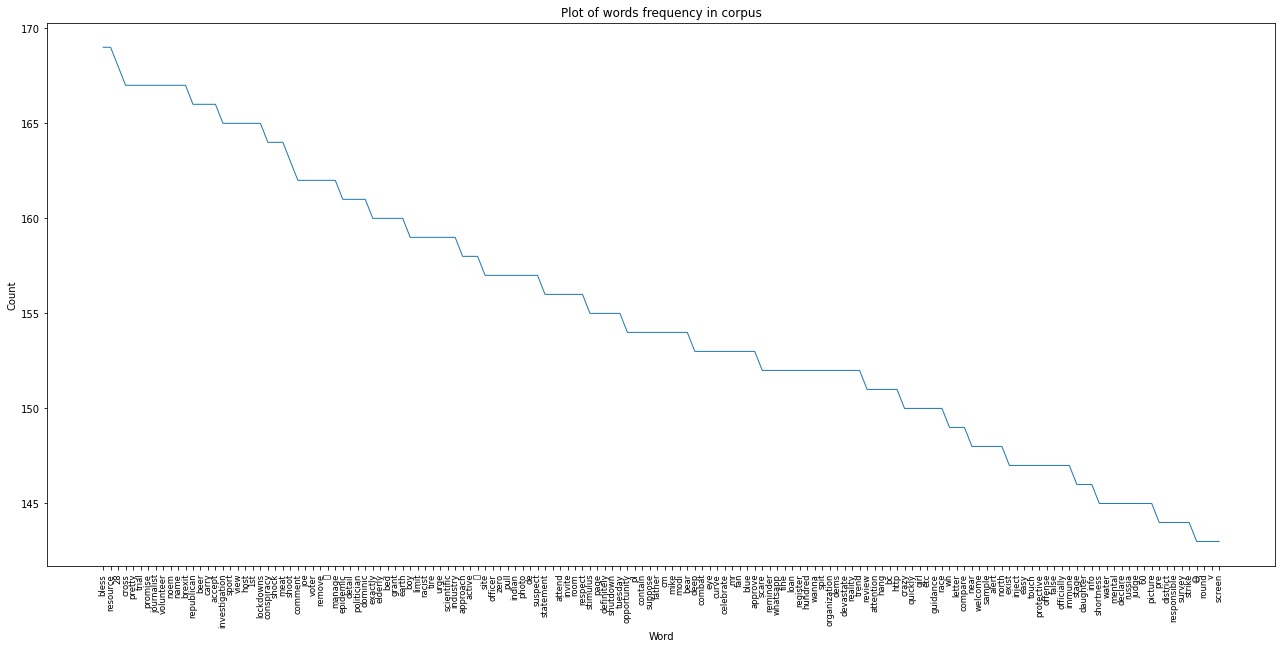

Pulling out indivdual words.
Words extracted.
['careful', '.', 'crazy', 'nancy', 'total', 'disaster', ',', 'usa', 'communist', 'country', '!', 'ht', '…', 'think', '.', 'desciphering', 'excess', 'death', 'covid', '.', 'case', '.', 'grant', 'people', 'dye']


In [ ]:
df_tweet.groupby('State').apply(
    lambda x: count_word(x)
)

### Cluster

In [ ]:
df_c=df_tweet['Processed_Tweet'].to_frame()

In [ ]:
# vectorize the text
vect = TfidfVectorizer(ngram_range=(1,2),min_df=.01, max_df=.95, norm='l2', stop_words='english')
titles_vect = vect.fit_transform(df_c['Processed_Tweet'])
titles_vect.shape

(19116365, 113)

#### Elbow Method

In [ ]:
# Run the Kmeans algorithm, printing out the SSE to identify the inflection "elbow"
sse = []
list_k = list(range(1, 20))

for k in list_k:
    km = MiniBatchKMeans(n_clusters=k, batch_size=200, random_state=3) # use for larger datasets, not as accurate
    #km = KMeans(n_clusters=k)
    km.fit(titles_vect)
    sse.append(km.inertia_)

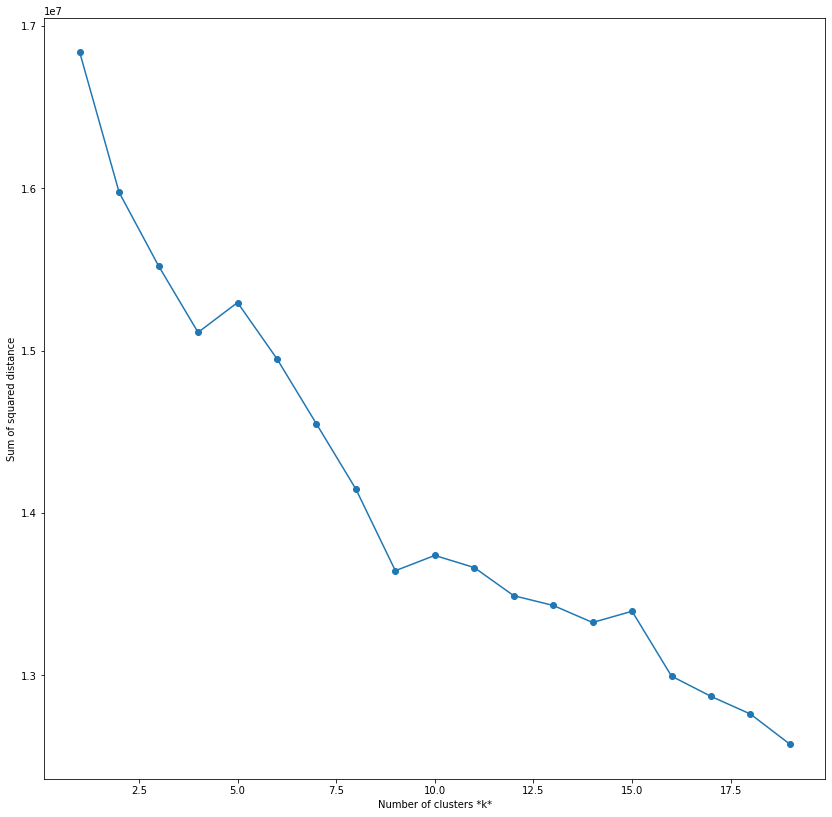

In [ ]:
# Plot sse against k
plt.figure(figsize=(14, 14))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')
plt.show()

Run Kmeans Method

In [ ]:
# cluster the document using KMeans
from sklearn.cluster import KMeans, MiniBatchKMeans
# instantiate the model
km = KMeans(n_clusters=9, random_state=42)
# fit the model with data
# clustering is unsupervised so we do not have labels to add during .fit()
km.fit(titles_vect)
# predict the cluster of each section_title
df_c['clusters'] = km.predict(titles_vect)

In [ ]:
from sklearn.decomposition import TruncatedSVD # to work with sparse matrices
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

sk_tsvd = TruncatedSVD(n_components= 2)

y_tsvd = sk_tsvd.fit_transform(titles_vect)

km = KMeans(n_clusters=9, random_state=42)

# fit to TruncSVD values
km.fit(y_tsvd)

# predict clusters
svd_clusters = km.predict(y_tsvd)

# plot results
plt.scatter(y_tsvd[:, 0], y_tsvd[:, 1], c=svd_clusters, s=50, cmap='magma')
plt.savefig('Cluster.png')
plt.show()

In [ ]:
a=df_tweet[df_tweet['Processed_Tweet'].str.contains('world')]['Processed_Tweet']

In [ ]:
a=a.reset_index()

In [ ]:
a['Processed_Tweet'][3]

'miss . visionary speak world lead healthcare professional'

34 w 29 w

In [ ]:
len(df_tweet)

19116365

Print top 10 tweets in every cluster

In [ ]:
def review_clusters(df, n_clusters):
    for cl_num in range(n_clusters):
        print(cl_num)
        print(df_c[df.clusters == cl_num]['Processed_Tweet'].values[0:50])
        print()

review_clusters(df_c, n_clusters=9)

0
['joe biden choose defend china day credibly accuse try hack company try …'
 'live footage corona shutdown day 12 . work home , find overwilliammorrissed .'
 'lazy morbidly obese wife cheat lie pussy grab pos beak hard day golf 100,000americans die # covid19 # trumpliespeopledie'
 'hospital far northern california spend couple day , doctor report see …'
 '3 day weekend.it nice outside.that mean # covid19 go away.wash hands.stay 6 foot apart . …'
 'corona , officially day week1 . yesterday 2 . today3 . tomorrow'
 'corona , officially day week1 . yesterday 2 . today3 . tomorrow'
 'corona get 11 day cause bitch bday go outsideeee today'
 'quarantine drink day “ load coronarita . ” freeze margarita fish bowl corona beer turn upside …'
 '28 day realistic wait covid symptom manifest .'
 'coronavirus kill mexico mexico die day'
 'right . work home . see friend 10 day . beer hour outside pub , ei …'
 'see headline " spike case wi election"i check   add arrow 14 day l …'
 'day negotiation emo

Show wordcloud in each cluster

0:
Generating WordCloud across 45415285 characters.


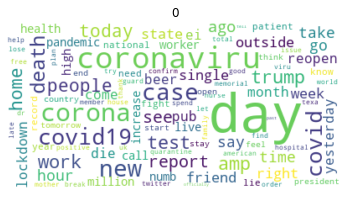

1:
Generating WordCloud across 572105745 characters.


2:
Generating WordCloud across 223667303 characters.


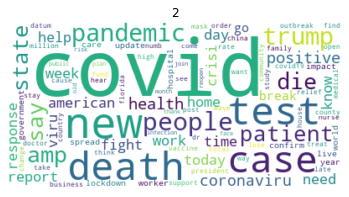

3:
Generating WordCloud across 215575794 characters.


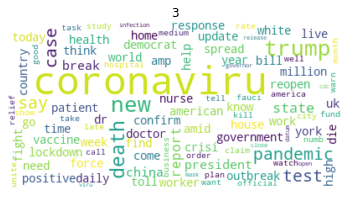

4:
Generating WordCloud across 86575139 characters.


5:
Generating WordCloud across 46541276 characters.


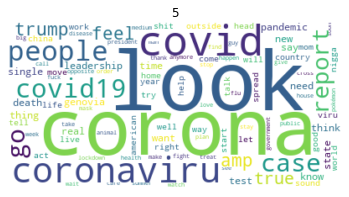

6:
Generating WordCloud across 119416904 characters.


7:
Generating WordCloud across 89986972 characters.


8:
Generating WordCloud across 80320919 characters.


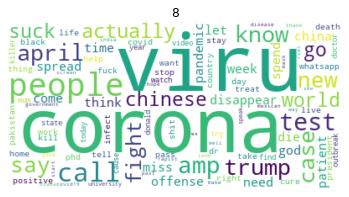

Empty DataFrame
Columns: []
Index: []

In [ ]:
df_c.groupby('clusters').apply(
    lambda x: show_wordcloud(x,title=f"{x.name}")
)

Show word count graph of clusters

['day', '.', ',', '…', '#', 'coronavirus', '-', ':', '!', 'corona', 'case', 'covid19', 'new', 'death', 'covid', '"', '?', ';', 'work', '&', 'test', 'trump', 'amp', 'home', 'people', 'today', 'report', '...', 'see', '2', '“', '(', 'ago', '10', 'take', 'hour', 'go', 'say', '😭', 'time', 'single', '3', 'state', ')', 'right', 'like', 'friend', 'week', 'outside', '”', 'get', '1', 'reopen', 'lockdown', 'beer', '5', 'die', 'come', 'pub', 'ei', '14', 'yesterday', 'increase', 'month', 'pandemic', 'high', "'", 'numb', 'million', 'call', 'live', 'worker', 'know', 'health', 'patient', 'fight', 'national', 'record', 'have', 'need', 'president', 'end', 'tomorrow', '/', 'feel', 'start', 'news', 'think', 'country', 'open', 'late', 'be', 'quarantine', '️', 'world', 'year', 'twitter', 'hospital', '4', 'stay', 'texas', 'issue', 'good', 'nurse', '20', 'mother', 'memorial', 'positive', 'spend', 'try', 'virus', 'house', 'break', 'confirm', 'thank', '%', 'find', '—', 'lose', '30', '+', 'help', 'free', 'family

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128079 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128680 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127482 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127480 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9989 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127995 missing from current font.
  font.

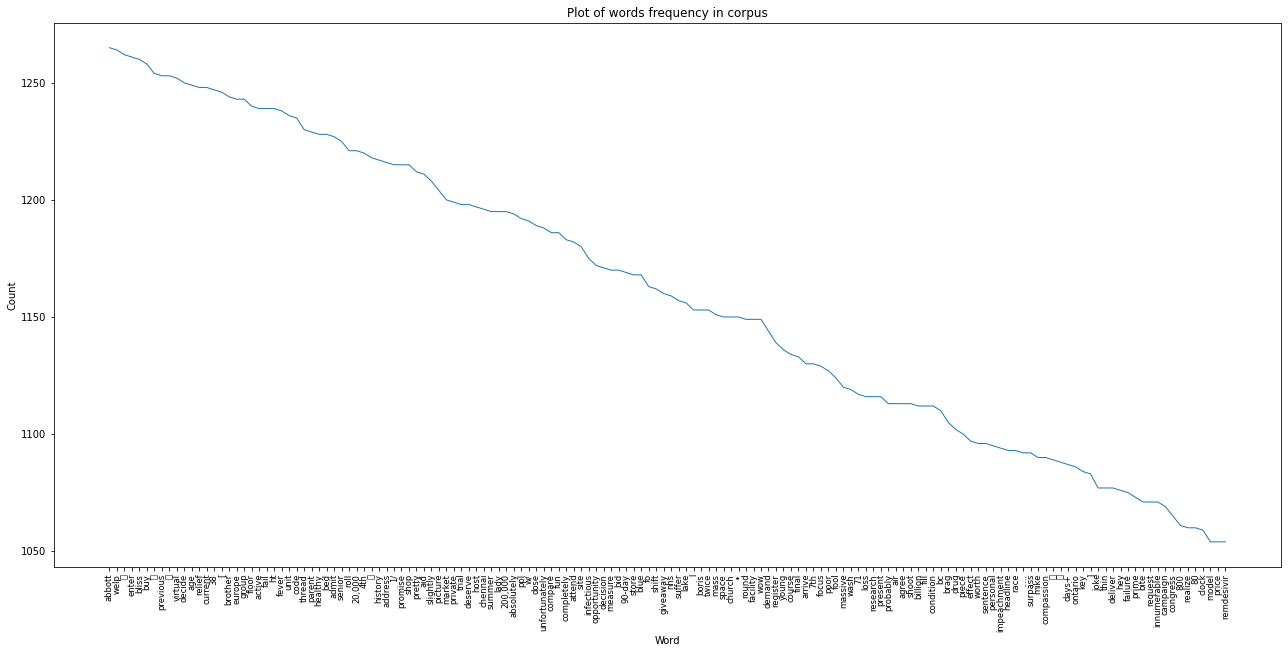

['.', '…', ',', '#', '-', ':', '!', '?', 'covid', '"', ';', '&', 'amp', 'trump', '“', 'corona', 'say', '...', 'new', 'test', 'know', 'death', 'time', 'state', 'need', 'home', 'work', '”', '(', 'go', 'get', 'health', 'want', ')', "'", 'pandemic', 'think', 'today', 'week', 'help', 'case', 'president', 'country', 'live', 'right', 'government', 'world', 'come', 'news', 'year', 'care', 'fuck', 'stay', 'americans', 'worker', 'tell', 'mask', 'thank', 'let', '$', 'good', 'dr', 'china', '%', 'report', 'die', 'coronavirus', 'break', 'thing', 'nurse', 'patient', '/', 'million', 'great', 'hospital', 'look', '2', '—', 'open', 'month', 'virus', 'take', 'house', 'call', 'lockdown', 'ask', 'way', 'family', 'doctor', '*', 'support', 'public', 'man', 'give', 'well', 'try', 'reopen', 'business', 'stop', 'america', 'leave', 'fight', 'wrong', 'read', 'order', '’', '😂', 'crisis', 'start', 'plan', 'big', 't', 'social', 'positive', '..', 'kill', 'life', 'medium', 'make', 'face', 'watch', 'lie', 'high', 'white

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127996 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128580 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127996 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128580 missing from current font.
  font.set_text(s, 0, flags=flags)


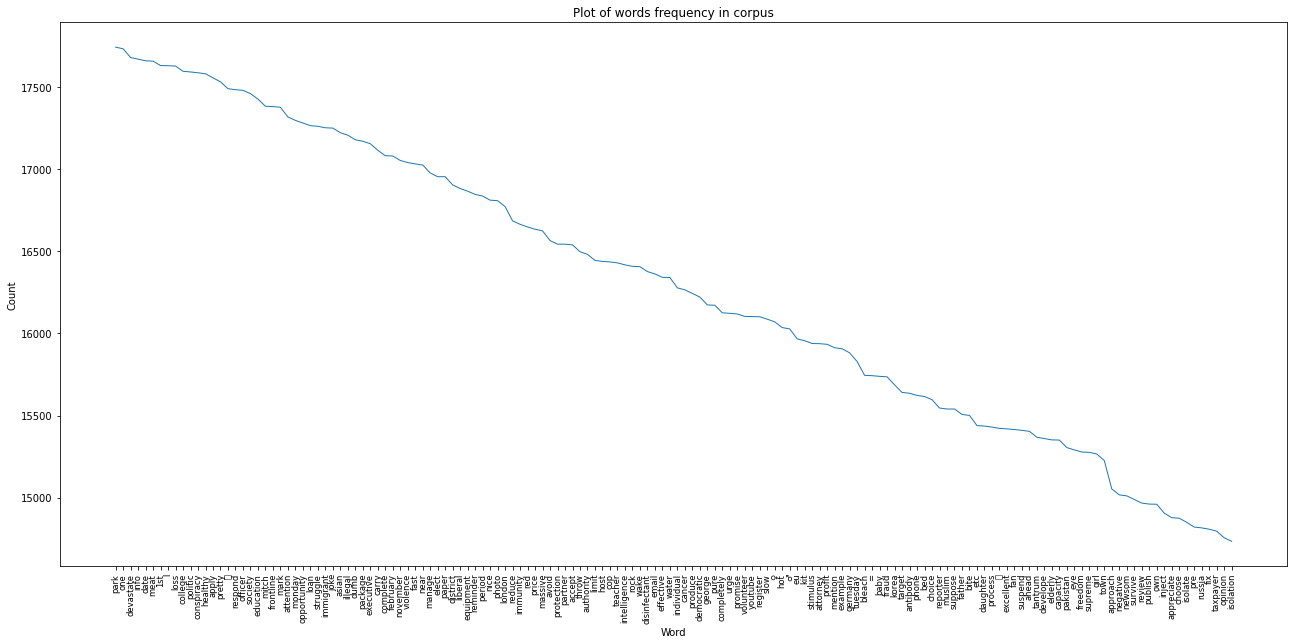

['covid-19', '.', ',', '…', '#', ':', '-', 'covid', 'test', '?', '"', '!', 'death', 'case', 'new', 'people', '19', ';', 'pandemic', 'trump', "'", '“', 'die', '&', '(', 'amp', 'say', 'patient', 'state', ')', 'positive', 'health', '”', 'coronavirus', 'report', 'home', '%', '...', 'help', 'day', 'time', 'get', 'fight', 'today', 'need', 'crisis', 'know', 'news', 'work', '—', 'response', 'virus', 'break', 'week', 'go', '$', '2', '|', 'world', 'update', 'like', 'live', '’', 'spread', 'hospital', '1', '/', 'confirm', 'impact', 'worker', 'government', 'care', 'president', 'think', 'rate', 'datum', 'come', 'doctor', 'county', 'country', 'nurse', 'want', 'florida', '‘', 'take', 'support', 'find', 'million', 'lose', 'outbreak', 'community', 'vaccine', 'business', 'americans', 'lockdown', 'cause', 'total', 'high', 'family', 'relief', 'have', 'numb', 'fund', 'year', 'china', 'be', 'order', '*', 'see', 'mask', 'way', 'covid19', '2020', 'study', 'treat', 'hear', 'medical', 'stay', 'wave', 'change', '

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129300 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129315 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 129300 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 129315 missing from current font.
  font.set_text(s, 0, flags=flags)


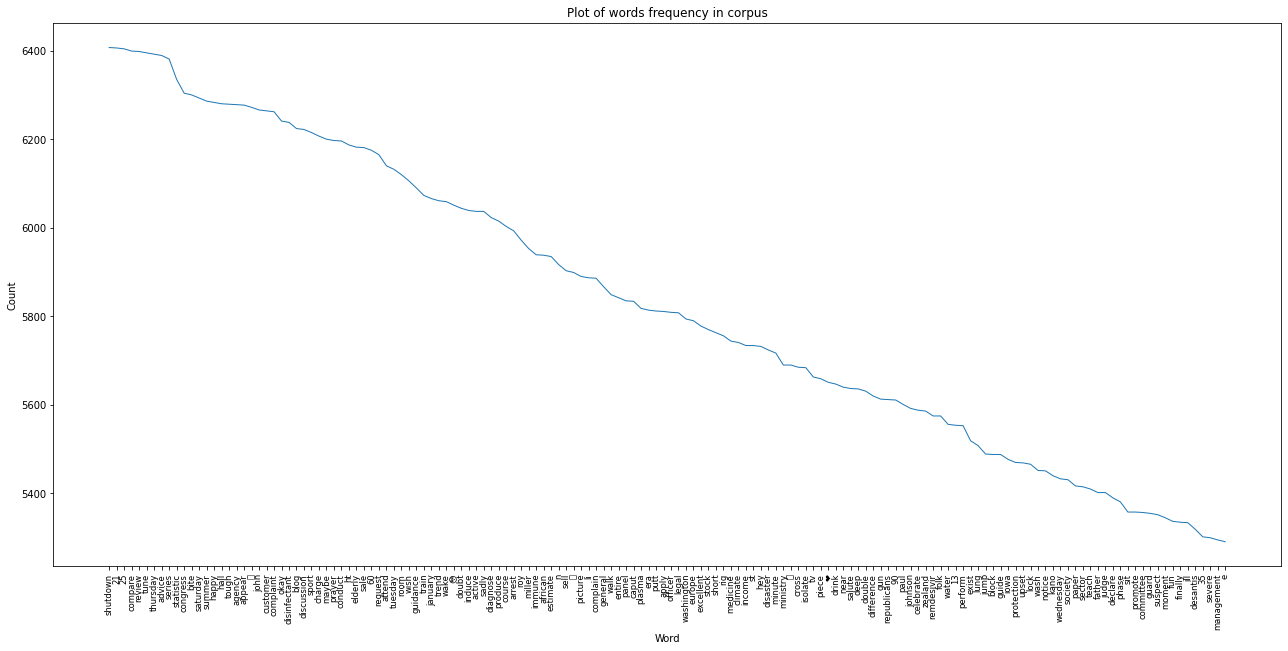

['coronavirus', '.', '…', ',', '#', ':', '-', 'trump', '"', 'death', 'new', "'", 'say', 'test', 'case', 'pandemic', '?', '!', 'state', '“', 'report', 'break', 'president', 'china', 'news', '”', 'response', ';', 'time', '’', 'u.s', 'world', 'house', '$', 'die', '‘', 'home', '...', 'spread', '(', 'lockdown', 'crisis', '%', 'patient', 'positive', '|', 'vaccine', 'outbreak', 'million', 'health', 'get', 'week', 'country', 'force', 'live', ')', '&', 'government', 'go', '—', 'americans', 'help', 'amp', 'white', 'know', 'bill', 'fight', 'reopen', '2', 'work', 'amid', 'york', 'uk', 'today', 'nurse', 'think', 'update', 'toll', 'dr', 'democrat', 'come', 'doctor', 'worker', 'need', 'confirm', 'find', 'high', 'daily', 'official', 'relief', 'plan', 'call', 'hospital', 'tell', 'task', 'claim', 'numb', 'month', 'take', 'study', 'rate', 'late', 'fund', 'america', 'fauci', 'warn', 't', 'kill', 'unite', 'watch', 'business', 'good', 'city', 'want', 'order', 'medium', 'show', 'governor', 'well', 'open', 'c

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129440 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128293 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 129440 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128293 missing from current font.
  font.set_text(s, 0, flags=flags)


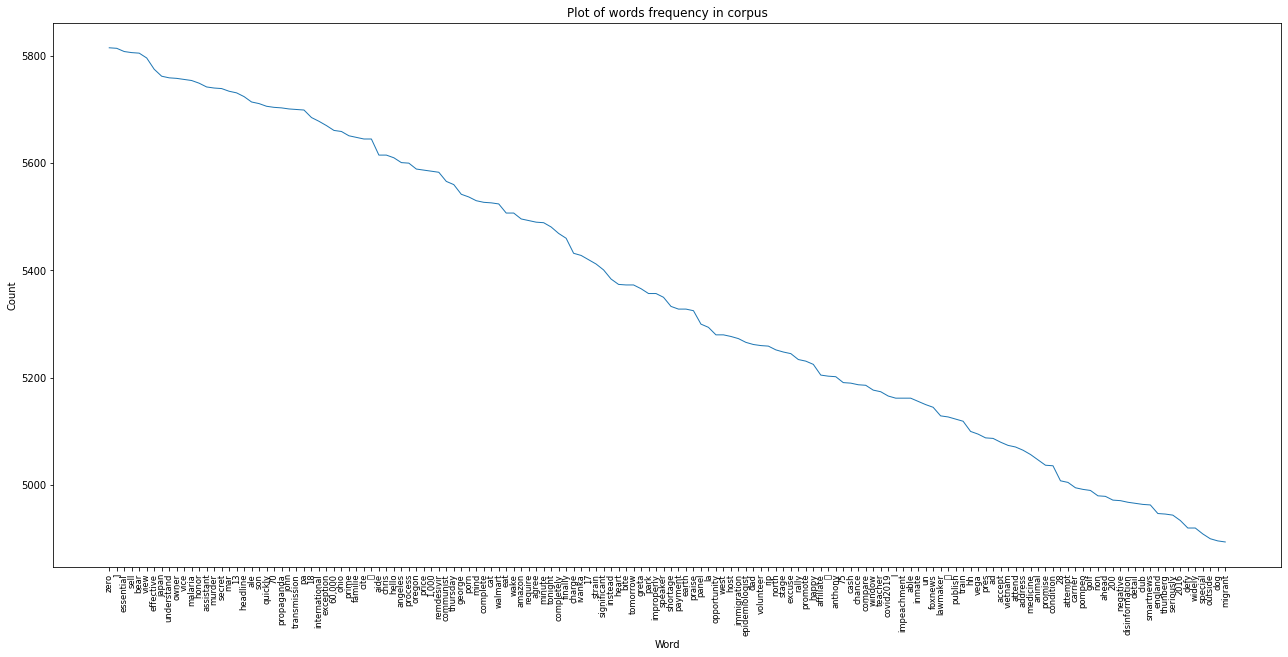

['people', '.', '…', ',', '#', 'coronavirus', '“', '”', 'corona', 'call', '?', '-', ':', 'trump', '!', '"', 'die', 'covid19', 'covid', 'black', 'virus', 'think', ';', '&', 'test', 'tell', 'need', 'amp', 'say', 'chinese', 'donald', 'time', 'know', 'thug', 'death', 'video', 'home', 'pandemic', '...', 'work', 'mask', 'get', 'go', 'today', 'state', 'want', 'help', 'dye', 'million', 'live', 'new', 'kill', '..', 'literally', ')', '(', "'", 'wear', '%', 'come', 'stop', 'care', 'update', 'country', 'start', 'aud', 'health', 'fire', 'stay', 'government', 'american', 'rac', 'ask', 'mean', 'positive', 'right', 'thousand', 'great', 'take', 'numb', 'social', 'world', 'infect', 'spread', 'fedex', 'reposting', '—', 'case', 'thing', 'let', 'lockdown', 'distance', 'lose', 'believe', 'week', 'big', 'have', 'unite', '2', 'news', 'way', 'young', 'try', 'money', 'year', 'old', 'lot', '$', 'white', '*', 'look', '1', 'wrong', 'flu', '/', 'risk', 'protect', 'city', 'history', 'good', 'sign', 'crisis', 'presid

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129335 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 129335 missing from current font.
  font.set_text(s, 0, flags=flags)


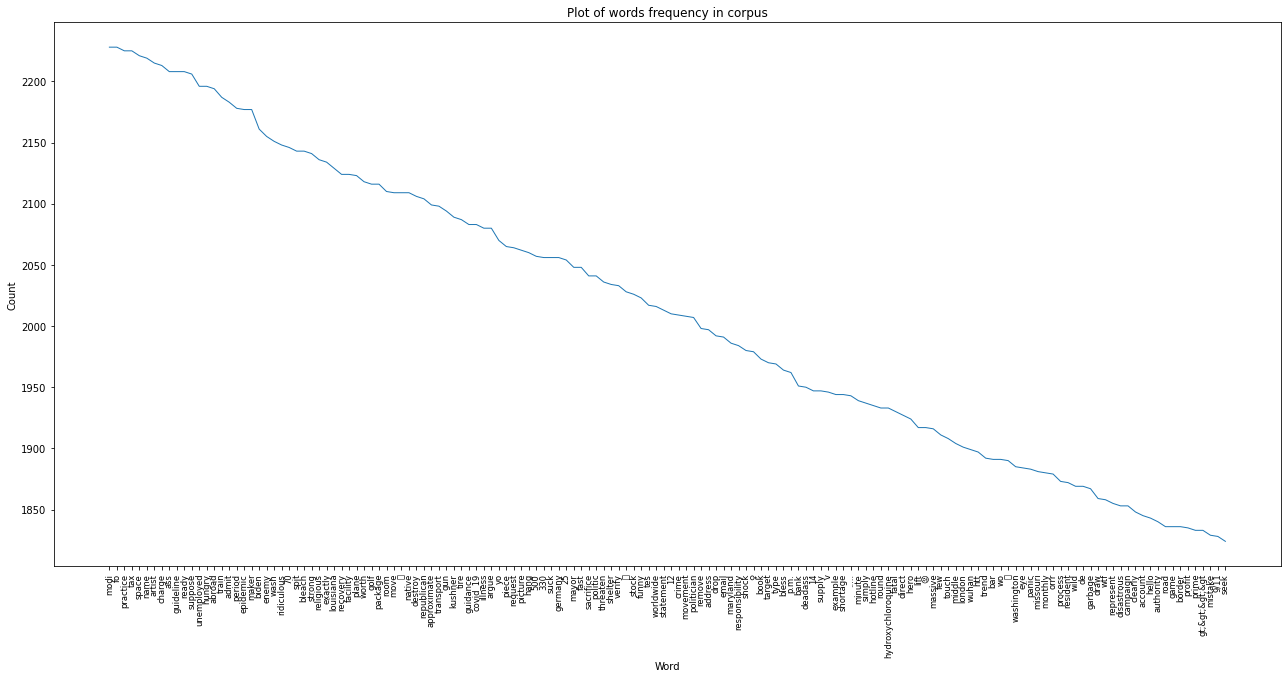

['like', '.', ',', '…', '#', 'look', 'corona', 'coronavirus', '?', '-', '!', 'covid', '"', 'people', ':', '...', 'covid19', 'case', 'go', '*', 'covid-19', '“', ';', 'report', '&', 'trump', 'get', 'amp', 'feel', 'true', 'leadership', 'state', '”', 'time', 'thing', 'single', 'genovia', 'say', 'know', 'need', 'think', 'want', '(', 'test', 'pandemic', 'real', 'death', "'", 'new', ')', 'try', 'country', 'work', 'virus', 'come', 'move', 'let', 'well', 'home', 'right', 'life', 'world', 'live', '😂', 'sound', 'year', 'tell', 'spread', 'shit', 'outside', 'good', 'americans', 'act', '..', 'talk', '/', 'help', 'head', 'way', 'mom', 'start', 'china', 'will', 'niggas', 'anymore', '‘', 'fuck', 'summer', 'animal', '’', 'treat', '.....', 'call', 'see', 'president', 'government', 'week', 'cross', 'news', 'find', 'house', 'fight', 'take', '$', 'order', 'wait', 'happen', 'have', 'mask', '😭', 'flu', 'make', 'guy', 'health', 'disease', 'love', 'stop', 'opposite', '—', 'give', 'plan', 'medium', 'man', 'pokém

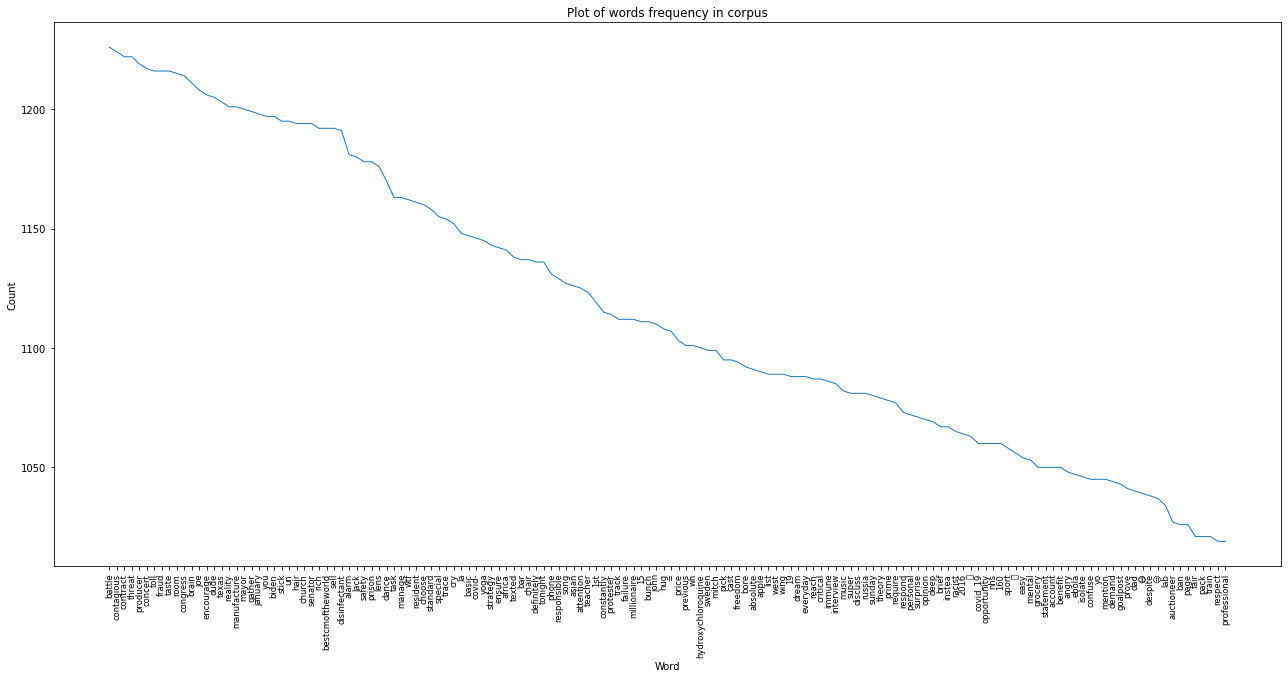

['#', 'covid19', '.', ',', '…', ':', '-', ';', '!', '&', 'amp', '?', 'case', 'coronavirus', 'new', 'test', '"', 'pandemic', 'death', '(', 'help', 'today', ')', 'need', 'health', 'work', 'time', 'patient', 'state', '...', 'fight', 'know', 'home', 'report', 'crisis', 'live', '“', '%', '/', 'trump', 'thank', 'response', 'die', 'corona', 'say', 'positive', "'", 'world', 'spread', 'update', 'country', 'lockdown', 'support', 'virus', 'go', 'impact', 'late', 'get', '2', 'care', '️', 'week', '”', 'total', 'confirm', 'take', 'worker', 'news', 'government', 'come', 'woman', 'mask', 'community', 'join', 'continue', '$', 'hospital', 'think', 'want', 'datum', '1', 'face', 'stay', 'high', 'risk', 'look', 'vaccine', 'family', 'share', 'business', 'find', 'global', 'way', 'well', 'break', 'great', 'nurse', 'have', 'protect', 'right', 'dr', 'numb', 'let', 'learn', 'daily', 'china', 'open', 'year', 'public', 'use', '2020', 'social', 'india', 'americans', 't', 'good', 'rate', 'child', 'healthcare', 'watc

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127475 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127464 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127998 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128077 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128313 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127470 missing from current font.
  fon

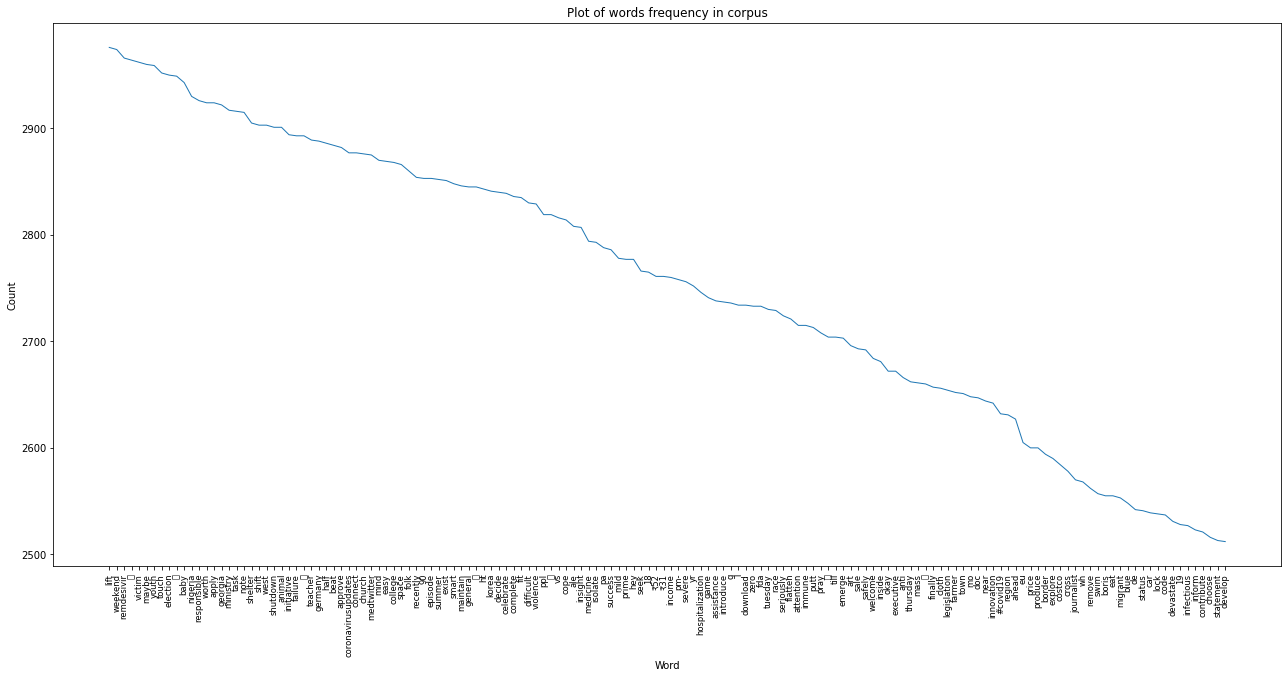

['corona', '.', ',', '#', '…', '!', '?', ':', '-', '😂', 'go', 'come', 'get', 'outside', '"', '...', 'shit', 'time', '“', 'know', '(', 'say', ';', '..', 'want', '&', '😭', 'take', 'amp', '”', "'", ')', 'fight', 'fuck', 'spread', '3', 'trump', 'think', 'case', '️', 'house', 'stop', 'ass', 'need', 'let', '🤣', 'tell', '/', 'be', 'home', 'away', 'stay', 'well', '....', 'man', 'to', 'believe', 'new', 'right', 'big', 'hey', 'u', 'relief', 'blow', 'early', 'pandemic', 'hand', 'quarantine', 'death', 'future', 'cuz', 'pro', 'thing', 'test', 'da', 'invite', 'challenge', 'bitch', 'world', 'flu', 'hear', 'nasty', '2', 'leave', 'find', 'hang', '*', 'call', 'flaky', 'grandpa', 'fat', 'lockdown', 'grandson', 'bang', 'hope', 'story', 'corona?”me', 'lead', 'end', 'live', 'announce', 'crisis', 'see', 'sick', '%', 'india', 'miss', 'ppl', 'die', 'work', 'today', 'guy', 'cdc', 'post', 'cause', 'year', 'have', 'month', 'not', 'way', 'instagram', 'racism', 'catch', 'kill', 'help', 'life', 'song', 'talk', 'good

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128588 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128064 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128175 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128170 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128588 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128064 missing from current font.
  font.

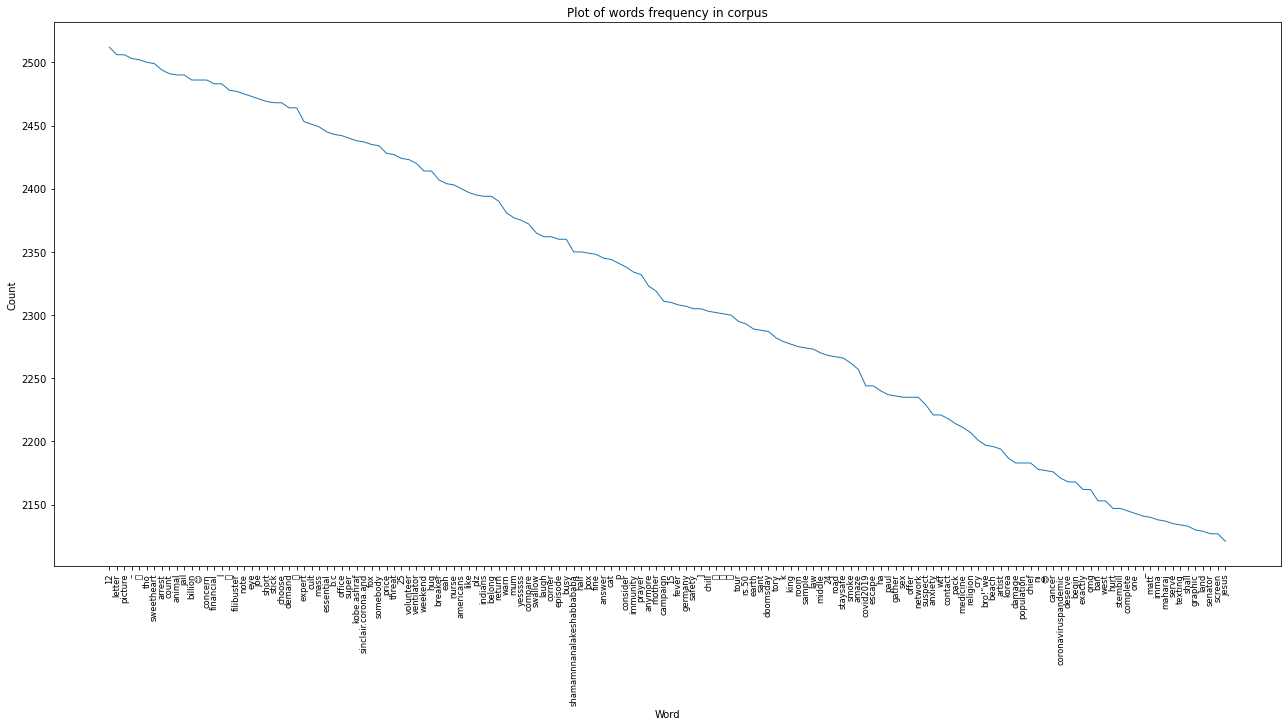

['virus', 'corona', '.', ',', '…', '#', '!', '?', '“', ':', 'people', '-', '”', '"', 'call', '...', ';', 'test', '&', 'get', 'amp', 'like', 'know', 'april', 'case', 'trump', 'say', 'fight', 'actually', '😂', 'chinese', 'suck', 'go', 'disappear', 'spread', '..', 'world', 'offense', 'china', 'patient', '😭', 'week', 'think', 'time', 'need', 'come', 'die', '(', 'god', 'pandemic', 'miss', 'spend', ')', 'whatsapp', 'black', 'help', 'positive', 'let', 'phd', 'work', 'right', 'want', 'dr', 'home', 'fuck', 'day', 'thing', 'stay', 'death', 'pakistan', 'treat', 'new', 'stop', 'shit', 'president', 'take', '️', 'w', 'cure', 'live', 'life', '🙏', 'infect', 'kill', 'pass', 'tell', 'news', 'state', 'country', 'try', 'watch', 'mum', 'find', 'video', 'donald', 'cause', 'doctor', '%', 'killer', 'university', "'", 'speak', 'past', 'government', 'year', '\U0001f9a0', 'way', 'today', '*', 'usama', 'riaz', 'screen', 'india', 'see', 'make', 'rapist', 'mexicans', 'hope', 'thank', 'well', 'start', 'good', 'mask',

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129396 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128165 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128128 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 129396 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128165 missing from current font.
  font.se

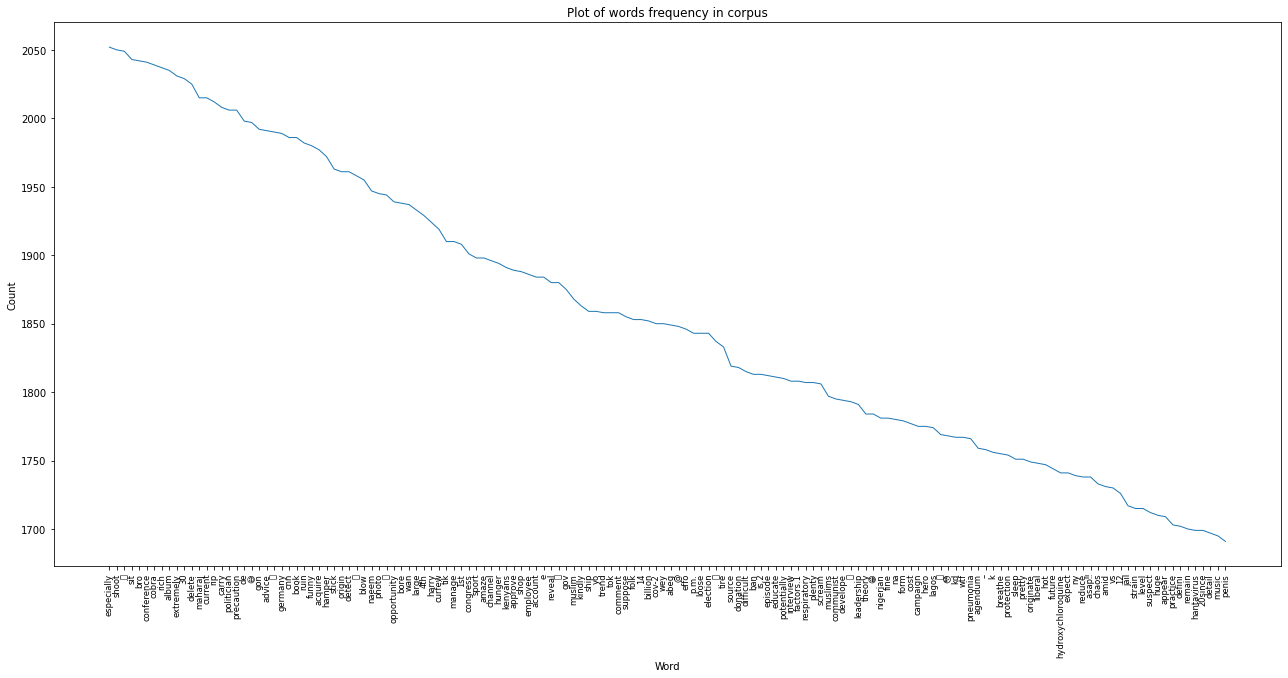

Empty DataFrame
Columns: []
Index: []

In [ ]:
df_c.groupby('clusters').apply(
    lambda x: count_word(x)
)

### Sentiment Analysis

In [ ]:
!pip install vaderSentiment

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from collections import Counter
import re

#### Sentiment analysis on first 10000 tweets by state

In [ ]:
state_list=df_tweet['State'].unique()

polarities = list()

for state in state_list:
    compound = .0
    df_state=df_tweet[df_tweet['State']==state]
    for sentence in df_state['Processed_Tweet'][:10000]:
        compound += SentimentIntensityAnalyzer().polarity_scores(sentence)['compound']

    polarities.append(compound)
    print('One state done')

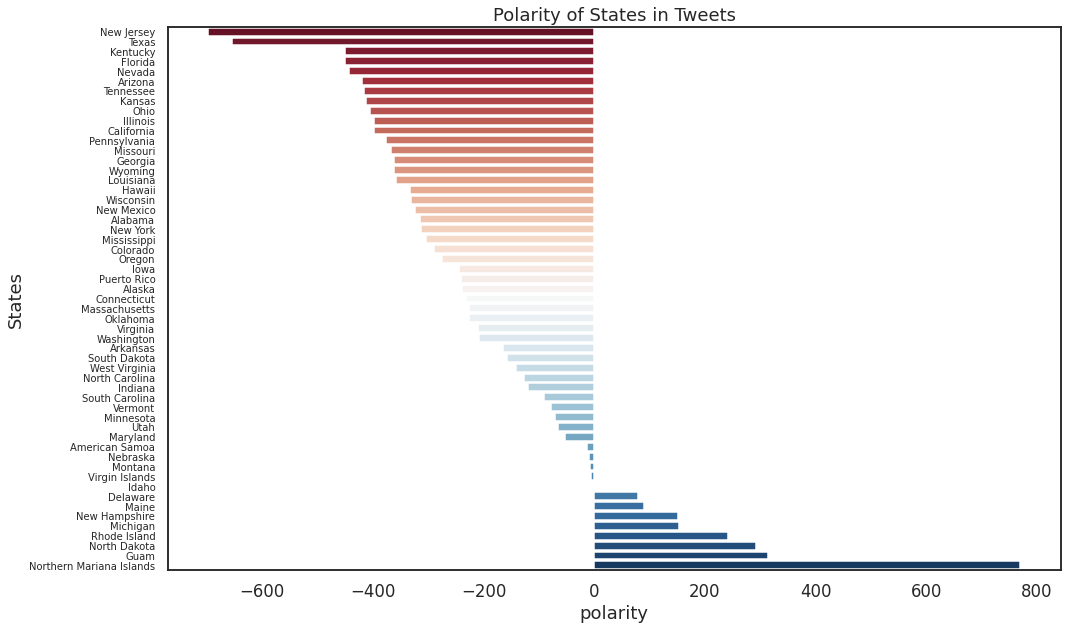

In [ ]:
state_list = pd.DataFrame(state_list)
polarities = pd.DataFrame(polarities)
tags_sentiment = pd.concat([state_list,polarities],axis=1)
tags_sentiment.columns = ['state','polarity']
tags_sentiment=tags_sentiment.sort_values('polarity').reset_index()

plt.figure(figsize=(16,10))
sns.set(style="white",context="talk")
ax = sns.barplot(x=tags_sentiment['polarity'],y=tags_sentiment['state'], data=tags_sentiment,orient='h',palette="RdBu")
ax.set_yticklabels(ax.get_yticklabels(),fontsize=10)
plt.ylabel("States")
plt.xlabel("polarity")
plt.title("Polarity of States in Tweets")
plt.savefig('sentiment_10000.png')
plt.show()

#### Sentiment Analysis on Mask

In [ ]:
df_mask=df_tweet[df_tweet['Processed_Tweet'].str.contains('mask')]

In [ ]:
df_mask['score'] = df_mask['Processed_Tweet'].apply(lambda sentence: SentimentIntensityAnalyzer().polarity_scores(sentence)['compound'])
df_mask['V_Sentiment'] = df_mask['score'].apply(lambda c: 'pos' if c >=0.05 else ('neu' if c > -0.05 else 'neg'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
pos_mask=df_mask.groupby('State').apply(lambda g: g[g['V_Sentiment']=='pos']['V_Sentiment'].count()/g['V_Sentiment'].count()).to_frame()
neu_mask=df_mask.groupby('State').apply(lambda g: g[g['V_Sentiment']=='neu']['V_Sentiment'].count()/g['V_Sentiment'].count()).to_frame()
neg_mask=df_mask.groupby('State').apply(lambda g: g[g['V_Sentiment']=='neg']['V_Sentiment'].count()/g['V_Sentiment'].count()).to_frame()

In [ ]:
per_mask = pd.concat([pos_mask,neu_mask,neg_mask],axis=1)
per_mask=per_mask.reset_index()
per_mask.columns = ['state','pos','neu','neg']
per_mask=per_mask.sort_values('pos').reset_index(drop=True)

In [ ]:
def draw_bar(df,name):
  plt.figure(figsize=(16,10))
  plt.barh(df['state'], df['pos'], color="#79a4d2",label='pos')  
  # careful: notice "bottom" parameter became "left"
  plt.barh(df['state'], df['neu'], left=df['pos'], color="#339933",label='neu')
  plt.barh(df['state'], df['neg'], left=df['pos']+df['neu'], color="#e68a00",label='neg')
  # we also need to switch the labels
  plt.xlabel('Sentiments')  
  plt.ylabel('state')
  plt.title("Sentiments of States in Tweets ("+name+")")
  plt.savefig(name+'.png')
  plt.show()

In [ ]:
def draw_bar_neg(df,name):
  plt.figure(figsize=(16,10))
  plt.barh(df['state'], df['neg'], color="#e68a00",label='neg')  
  # careful: notice "bottom" parameter became "left"
  plt.barh(df['state'], df['neu'], left=df['neg'], color="#339933",label='neu')
  plt.barh(df['state'], df['pos'], left=df['neg']+df['neu'], color="#79a4d2",label='pos')
  # we also need to switch the labels
  plt.xlabel('Sentiments')  
  plt.ylabel('state')
  plt.title("Sentiments of States in Tweets ("+name+")")
  plt.savefig(name+' neg.png')
  plt.show()

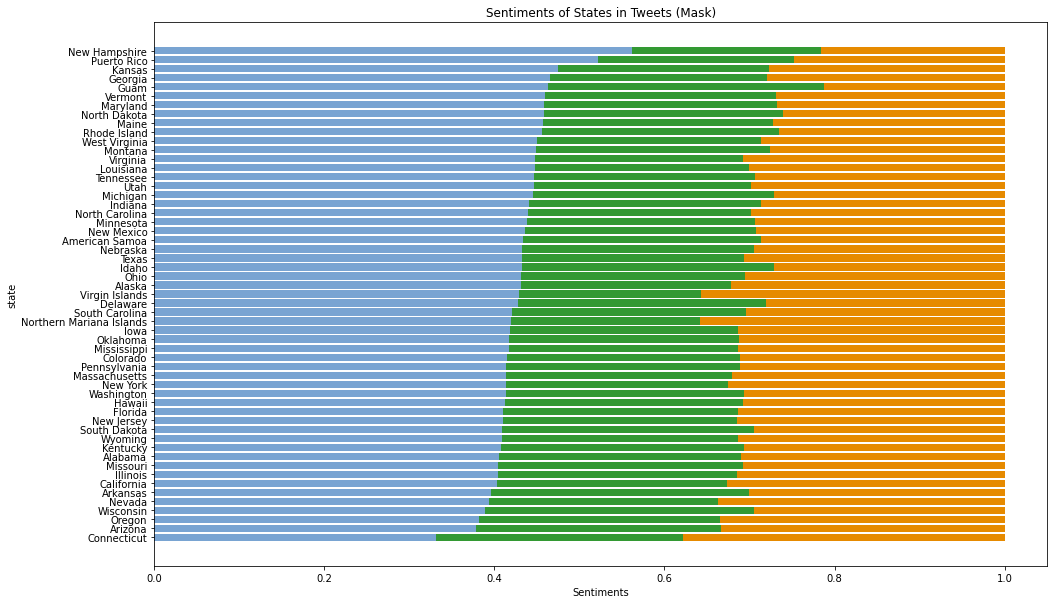

In [ ]:
draw_bar(per_mask,'Mask')

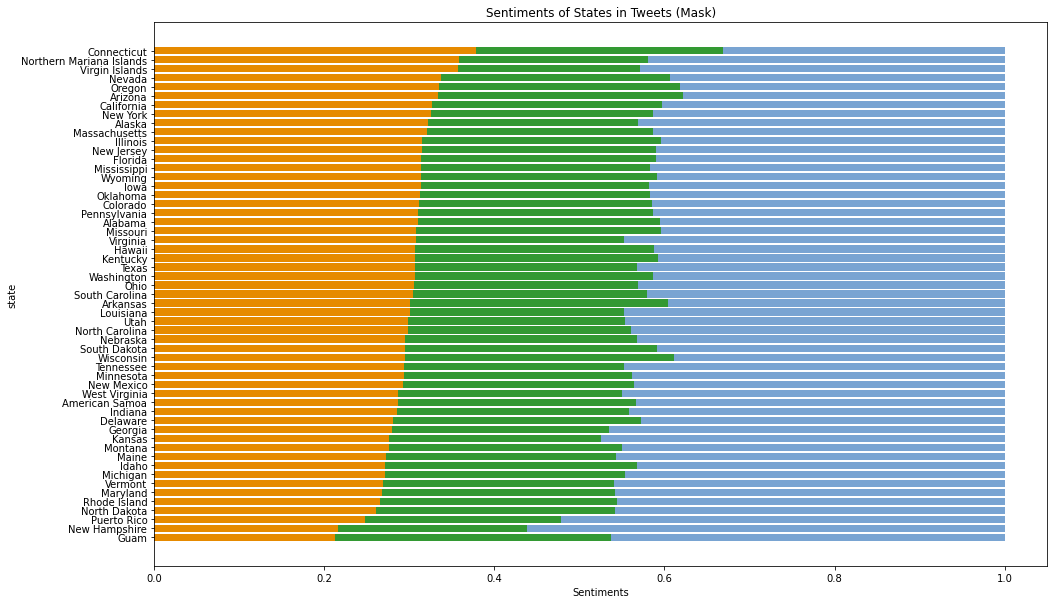

In [ ]:
draw_bar_neg(per_mask.sort_values('neg').reset_index(drop=True),'Mask')

#### Sentiment Analysis On Social Distance

In [ ]:
df_distance=df_tweet[df_tweet['Processed_Tweet'].str.contains('social distance')]

In [ ]:
df_distance['score'] = df_distance['Processed_Tweet'].apply(lambda sentence: SentimentIntensityAnalyzer().polarity_scores(sentence)['compound'])
df_distance['V_Sentiment'] = df_distance['score'].apply(lambda c: 'pos' if c >=0.05 else ('neu' if c > -0.05 else 'neg'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
pos_dis=df_distance.groupby('State').apply(lambda g: g[g['V_Sentiment']=='pos']['V_Sentiment'].count()/g['V_Sentiment'].count()).to_frame()
neu_dis=df_distance.groupby('State').apply(lambda g: g[g['V_Sentiment']=='neu']['V_Sentiment'].count()/g['V_Sentiment'].count()).to_frame()
neg_dis=df_distance.groupby('State').apply(lambda g: g[g['V_Sentiment']=='neg']['V_Sentiment'].count()/g['V_Sentiment'].count()).to_frame()

In [ ]:
per_distance = pd.concat([pos_dis,neu_dis,neg_dis],axis=1)
per_distance=per_distance.reset_index()
per_distance.columns = ['state','pos','neu','neg']
per_distance=per_distance.sort_values('pos').reset_index(drop=True)

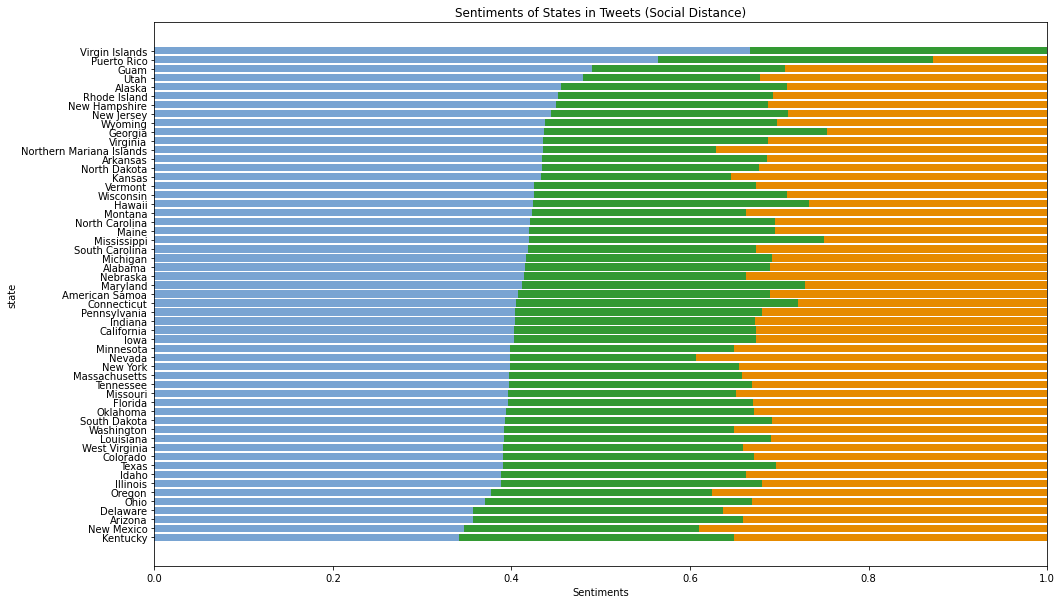

In [ ]:
draw_bar(per_distance,'Social Distance')

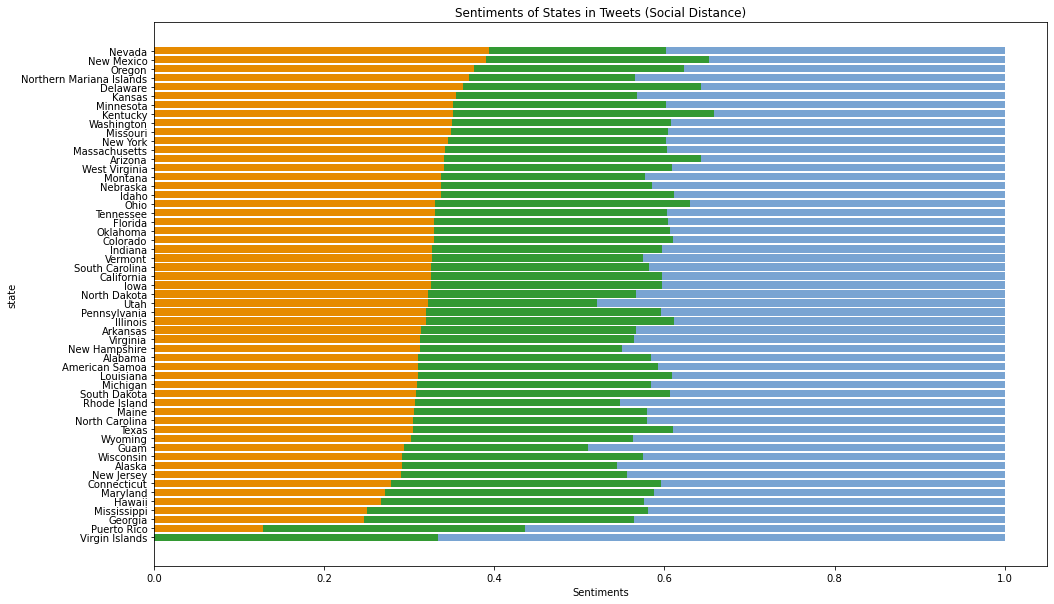

In [ ]:
draw_bar_neg(per_distance.sort_values('neg').reset_index(drop=True),'Social Distance')

#### Sentiment Analysis On Reopen

In [ ]:
df_re=df_tweet[df_tweet['Processed_Tweet'].str.contains('reopen')]

In [ ]:
df_re['score'] = df_re['Processed_Tweet'].apply(lambda sentence: SentimentIntensityAnalyzer().polarity_scores(sentence)['compound'])
df_re['V_Sentiment'] = df_re['score'].apply(lambda c: 'pos' if c >=0.05 else ('neu' if c > -0.05 else 'neg'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_re

ID          State  ...   score  V_Sentiment
213       1.0261826158779228e+18   Pennsylvania  ... -0.1759          neg
537                   38639718.0        Montana  ...  0.0000          neu
602                  625101594.0  West Virginia  ...  0.0000          neu
740                   24566597.0    Mississippi  ... -0.3612          neg
763                   35768011.0       New York  ...  0.3612          pos
...                          ...            ...  ...     ...          ...
20619924             2.21625e+09     New Jersey  ... -0.6705          neg
20619960             2.34122e+09        Georgia  ...  0.3612          pos
20620130             3.00453e+07       New York  ...  0.4404          pos
20620260             1.73282e+08      Tennessee  ... -0.7650          neg
20620316             8.24268e+17         Oregon  ...  0.0772          pos

[247710 rows x 5 columns]

In [ ]:
pos=df_re.groupby('State').apply(lambda g: g[g['V_Sentiment']=='pos']['V_Sentiment'].count()/g['V_Sentiment'].count()).to_frame()
neu=df_re.groupby('State').apply(lambda g: g[g['V_Sentiment']=='neu']['V_Sentiment'].count()/g['V_Sentiment'].count()).to_frame()
neg=df_re.groupby('State').apply(lambda g: g[g['V_Sentiment']=='neg']['V_Sentiment'].count()/g['V_Sentiment'].count()).to_frame()

In [ ]:
per_re = pd.concat([pos,neu,neg],axis=1)
per_re=per_re.reset_index()
per_re.columns = ['state','pos','neu','neg']
per_re=per_re.sort_values('pos').reset_index(drop=True)

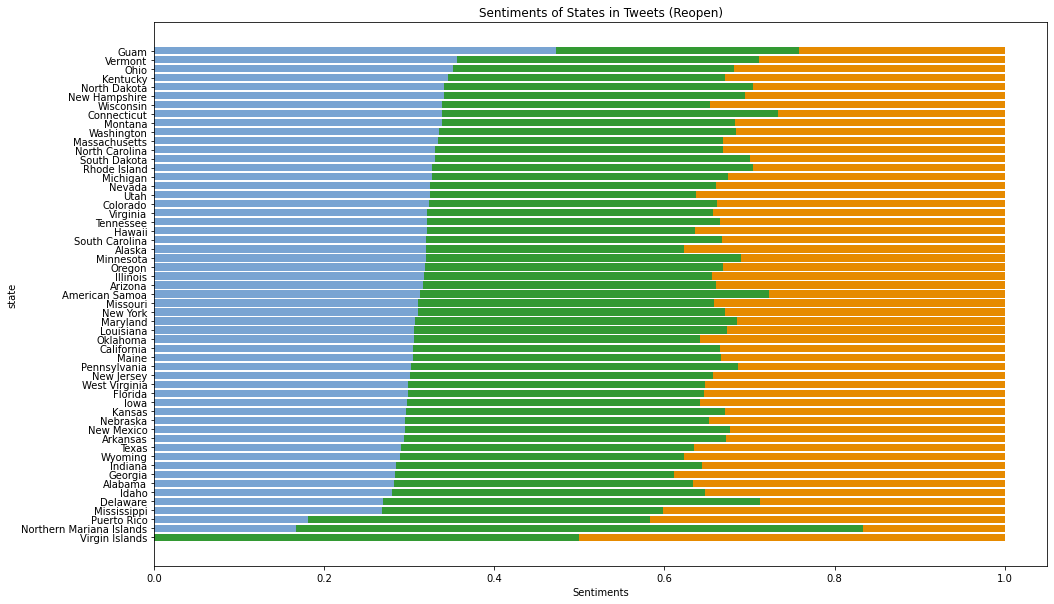

In [ ]:
draw_bar(per_re,'Reopen')

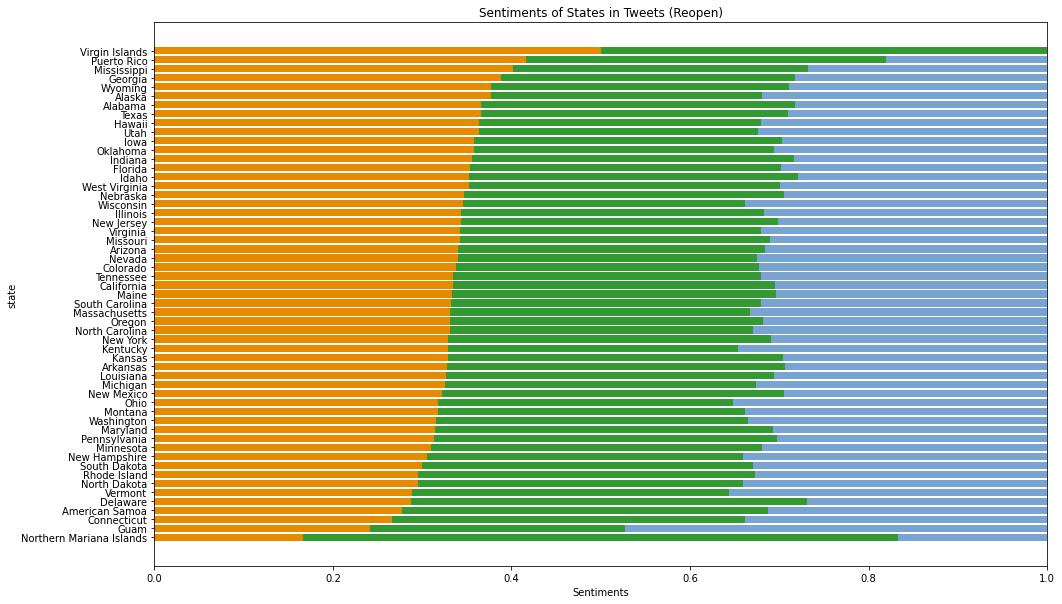

In [ ]:
draw_bar_neg(per_re.sort_values('neg').reset_index(drop=True),'Reopen')